## PART 1: Data Processing 

#### 1. Import poetry dataset as a Pandas data frame.

In [1]:
import pandas as pd
import numpy as np 
poems = pd.read_csv('poems.csv',sep=",",encoding='unicode_escape')

#### 2. Check counts of each feature

In [2]:
poems.describe()

author  \
count                   573   
unique                   67   
top     WILLIAM SHAKESPEARE   
freq                     71   

                                                  content poem name  \
count                                                 573       571   
unique                                                516       508   
top     When I was fair and young, then favor graced m...  Canto IV   
freq                                                    3         3   

                age  type  
count           573   573  
unique            2     3  
top     Renaissance  Love  
freq            315   326

#### 2.A There are fewer entries in column "poem name" (see 'count' in row) - these will be called 'Untitled'

In [3]:
poems["poem name"].fillna("Untitled", inplace=True)
poems.describe()

author  \
count                   573   
unique                   67   
top     WILLIAM SHAKESPEARE   
freq                     71   

                                                  content poem name  \
count                                                 573       573   
unique                                                516       509   
top     When I was fair and young, then favor graced m...  Canto IV   
freq                                                    3         3   

                age  type  
count           573   573  
unique            2     3  
top     Renaissance  Love  
freq            315   326

#### 3. Check if any authors only have ONE (1) instance in dataset; remove.

In [4]:
import copy as copy 

poets_unique = np.unique(poems["author"])

poets_1entry = []
print("these poets must be removed from dataset when training models for poetry classification:")
for p in range(len(poets_unique)):
    if len(poems["author"][poems["author"] == poets_unique[p]]) == 1:
        print(poets_unique[p])
        poets_1entry.append(np.where(poems["author"]==poets_unique[p])[0][0])

#indices to keep (create new dataset after vectorization procedure.)
to_keep = [ elem for elem in list(range(poems.shape[0])) if elem not in poets_1entry]

print("indices:", poets_1entry)

#make copy of original dataset 
poems_original = copy.deepcopy(poems)

poems = poems.drop(poems.index[poets_1entry])
poems.reset_index(inplace=True,drop=True)

these poets must be removed from dataset when training models for poetry classification:
FORD MADOX FORD
GIOVANNI BATTISTA GUARINI
ISABELLA WHITNEY
JOHN FLETCHER
KATHERINE MANSFIELD
MALCOLM COWLEY
ORLANDO GIBBONS
ROBERT SOUTHWELL, SJ
SECOND BARON VAUX OF HARROWDEN THOMAS, LORD VAUX
SIR EDWARD DYER
THOMAS HEYWOOD
THOMAS LODGE
WILLIAM BYRD
indices: [320, 162, 135, 201, 425, 408, 37, 28, 95, 163, 159, 172, 29]


In [5]:
print("Final dataset count after removing poets with one entry:", poems.shape[0])

Final dataset count after removing poets with one entry: 560


#### 4. Isolate features (contents) and different labels (author, age, and type)

In [6]:
#make copies of references to 'poems' to preserve original dataset prior to processing

poem_content = copy.copy(poems["content"])
poem_author = copy.copy(poems["author"])
poem_age = copy.copy(poems["age"])
poem_type = copy.copy(poems["type"])

#### 5. Process poem content: remove "\r\n" (dilineating line break), punctuation, and stop words. "Tokenize" word entries 

In [7]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
nltk.download('punkt')

punctuation = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

for r in range(poem_content.shape[0]):
    #convert list into string 
    poem_content[r] = str(poem_content[r])
    #removing line break symbol
    poem_content[r] = poem_content[r].replace("\r\n", " ")
    #removing punctuation 
    for p in punctuation:
        poem_content[r] = poem_content[r].replace(p,"")
    #removing stop words 
    tokens = copy.deepcopy(nltk.word_tokenize(poem_content[r]))
    poem_content[r] = [w for w in tokens if not w in stop]
    #convert all words to lower case 
    for t in range(len(poem_content[r])):
        poem_content[r][t] = poem_content[r][t].lower()


[nltk_data] Downloading package punkt to C:\Users\Cassandra .DESKTOP-
[nltk_data]     UDR64AF\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### 6. Convert contents of each poem to Bag of Words (BoW) object

In [8]:
#determining all terms used by consolidated poems dataset ('vocab')
vocab = []
for r in range(poem_content.shape[0]):
    for w in poem_content[r]:
        if not w in vocab:
            vocab.append(w)


#convert each 'poem content' list into a numerical vector describing the frequency of each 'vocab' term in the poem 
poem_word_freq = np.zeros((poem_content.shape[0],len(vocab)))
for r in range(poem_content.shape[0]):
    for word in range(len(vocab)):
        poem_word_freq[r,word] = poem_content[r].count(vocab[word]) 


In [9]:
print("total number of non-stop words in dataset:", poem_word_freq.shape[1])

total number of non-stop words in dataset: 15032


#### 7. Convert contents of each poem into a vector utilizing TF-IDF 

In [10]:
import math 

poem_word_tfidf = np.zeros((poem_content.shape[0],len(vocab)))
for r in range(poem_content.shape[0]):
    for w in range(len(vocab)):
        #find term frequency (TF) 
        #TF in this application is defined as the log transform of the total word count 
        tf = math.log(1+poem_word_freq[r,w])
        #find inverse document frequency (IDF)
        idf=math.log(poem_content.shape[0]/(1 + np.count_nonzero(poem_word_freq[:,w])))
        poem_word_tfidf[r,w]=tf*idf 


#### 8. Break dataset into training and testing sets 

In [11]:
#returns: BoW(train)[[0]], BoW(test)[[1]], BoWtfidf(train)[[2]], BoWtfidf(test)[[3]], auth(train)[[4]] , auth(test)[[5]], era(train)[[6]], era(test)[[7]], sub(test)[[8]], sub(test)[[9]]
def partition(BoW, BoW_tfidf,auth, era, sub, t=.15):
    #shuffling indices of feature object randomly
    shuffled_ind = np.random.permutation(BoW.shape[0])
    #size of to-be test set
    test_size = int(BoW.shape[0]*t)
    #shuffled indice lists after separating into training and testing lists
    test_ind = shuffled_ind[:test_size]
    train_ind = shuffled_ind[test_size:]
    #slicing feature and target objects according to the indices above and returning
    return BoW[train_ind], BoW[test_ind], BoW_tfidf[train_ind], BoW_tfidf[test_ind], auth[train_ind], auth[test_ind], era[train_ind], era[test_ind], sub[train_ind], sub[test_ind]



BoW_train, BoW_test, BoW_tfidf_train, BoW_tfidf_test, auth_train, auth_test, era_train, era_test, sub_train, sub_test = partition(poem_word_freq, poem_word_tfidf, poem_author, poem_age, poem_type)


In [12]:

#check if any authors appear in test set that model was not trained on 
test_only = set(auth_test) - set(auth_train)

#If an author exists in the test set that does not exist in the training set
#continue to repartition data
while len(test_only) > 0:
    BoW_train, BoW_test, BoW_tfidf_train, BoW_tfidf_test, auth_train, auth_test, era_train, era_test, sub_train, sub_test = partition(poem_word_freq, poem_word_tfidf, poem_author, poem_age, poem_type)
    test_only = set(auth_test) - set(auth_train)


## PART 2: Compare classification methods in classification of AUTHOR, ERA and SUBJECT 

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import itertools
import collections 

#### 1. Instantiate models; create grid of parameters that will be tested in grid search for each model.

In [14]:
#K-Nearest Neighbors 
knn = KNeighborsClassifier()
Ks = list(range(1,50))
Wts = ['uniform','distance']
Ps = [1,2] #where p=1 specifies manhattan distance, and p=2 specifies euclidean distance
param_grid_knn = dict(n_neighbors=Ks,weights=Wts,p=Ps)

#Gaussian Naive Bayes
gNB = GaussianNB()
param_grid_gNB = {'var_smoothing': [0.001, 0.01, 0.1, 1.0]}

#Random Forest 
rf = RandomForestClassifier()
trees = [10,50,100,200]
maximum_feats = ['sqrt','log2',None]
crit = ['gini','entropy']
depths = [2,4,6,8,10,12]
param_grid_rf = dict(n_estimators=trees, max_features=maximum_feats, criterion=crit, max_depth=depths)

#Support Vector Machine 
svm = SVC()
cs = [2**exponent for exponent in range(-3,3,3)]
gammas = [2**exponent for exponent in range(-9,-3,3)]
kerns = ['linear', 'rbf']
param_grid_svm = dict(C=cs, gamma=gammas, kernel=kerns)

#Multinomial Regression 
mlr = LogisticRegression(max_iter=300)
solvers = ['lbfgs','liblinear']
Cs=[2**exponent for exponent in range(-6,0)]
param_grid_mlr = dict(solver=solvers,C=Cs)


#### 2. Create a function that takes the model and parameter grid as input; outputs best parameters 

In [15]:
def get_best_params(model,param_grid,label):
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
    
    #implment grid search procedure using BOTH BoW and TF-IDF lables
    grid_search_BoW = grid.fit(BoW_train,label)  
    
    grid_search_BoW_tfidf = grid.fit(BoW_tfidf_train,label)  
    
    #derive best parameters identified in grid search 
    best_params_BoW = grid_search_BoW.best_params_
    best_params_BoW_tfidf = grid_search_BoW_tfidf.best_params_
    
    return best_params_BoW, best_params_BoW_tfidf

#### 3. Determine best model parameters for each model & for each label (author, era, subject) being predicted. 
This fxn call takes a long time. Therefore actual grid search fxn has been commented out.

In [16]:
##K-Nearest Neighbors 
#AUTHOR
best_params_knn_auth = [{'n_neighbors': 8, 'p': 1, 'weights': 'distance'},
                        {'n_neighbors': 8, 'p': 1, 'weights': 'distance'}]
#best_params_knn_auth = get_best_params(knn,param_grid_knn,auth_train)
print("Best parameters KNN, BoW, AUTHOR:", best_params_knn_auth[0])
print("Best parameters KNN, TF-IDF, AUTHOR:", best_params_knn_auth[1])

#ERA
best_params_knn_era = [{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'},
                        {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}]
#best_params_knn_era = get_best_params(knn,param_grid_knn,era_train)
print("Best parameters KNN, BoW, ERA:", best_params_knn_era[0])
print("Best parameters KNN, TF-IDF, ERA:", best_params_knn_era[1])

#SUBJECT
best_params_knn_sub = [{'n_neighbors': 6, 'p': 1, 'weights': 'uniform'},
                       {'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}]
#best_params_knn_sub = get_best_params(knn,param_grid_knn,sub_train)
print("Best parameters KNN, BoW, SUBJECT:", best_params_knn_sub[0])
print("Best parameters KNN, TF-IDF, SUBJECT:", best_params_knn_sub[1])



#Gaussian Naive Bayes 
#AUTHOR
best_params_gNB_auth = [{'var_smoothing': 0.01},
                        {'var_smoothing': 0.01}]
#best_params_gNB_auth = get_best_params(gNB,param_grid_gNB,auth_train)
print("Best parameters gNB, BoW, AUTHOR:", best_params_gNB_auth[0])
print("Best parameters gNB, TF-IDF, AUTHOR:", best_params_gNB_auth[1])

#ERA
best_params_gNB_era = [{'var_smoothing': 0.01},
                       {'var_smoothing': 0.01}]
#best_params_gNB_era = get_best_params(gNB,param_grid_gNB,era_train)
print("Best parameters gNB, BoW, ERA:", best_params_gNB_era[0])
print("Best parameters gNB, TF-IDF, ERA:", best_params_gNB_era[1])

#SUBJECT
best_params_gNB_sub = [{'var_smoothing': 0.1},
                       {'var_smoothing': 0.1}]
#best_params_gNB_sub = get_best_params(gNB,param_grid_gNB,sub_train)
print("Best parameters gNB, BoW, SUBJECT:", best_params_gNB_sub[0])
print("Best parameters gNB, TF-IDF, SUBJECT:", best_params_gNB_sub[1])



#Random Forest
#AUTHOR
best_params_rf_auth = [{'criterion': 'entropy', 'max_depth': 12, 'max_features': None, 'n_estimators': 100},
                       {'criterion': 'entropy', 'max_depth': 12, 'max_features': None, 'n_estimators': 100}]
#best_params_rf_auth = get_best_params(rf,param_grid_rf,auth_train)
print("Best parameters rf, BoW, AUTHOR:", best_params_rf_auth[0])
print("Best parameters rf, TF-IDF, AUTHOR:", best_params_rf_auth[1])

#ERA
best_params_rf_era = [{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50},
                      {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}]
#best_params_rf_era = get_best_params(rf,param_grid_rf,era_train)
print("Best parameters rf, BoW, ERA:", best_params_rf_era[0])
print("Best parameters rf, TF-IDF, ERA:", best_params_rf_era[1])

#SUBJECT
best_params_rf_sub = [{'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'n_estimators': 100},
                      {'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'n_estimators': 100}]
#best_params_rf_sub = get_best_params(rf,param_grid_rf,sub_train)
print("Best parameters rf, BoW, SUBJECT:", best_params_rf_sub[0])
print("Best parameters rf, TF-IDF, SUBJECT:", best_params_rf_sub[1])



#Support Vector Machine  
#AUTHOR
best_params_svm_auth = [{'C': 0.125, 'gamma': 0.001953125, 'kernel': 'linear'},
                        {'C': 0.125, 'gamma': 0.001953125, 'kernel': 'linear'}]
#best_params_svm_auth = get_best_params(svm,param_grid_svm, auth_train)
print("Best parameters svm, BoW, AUTHOR:", best_params_svm_auth[0])
print("Best parameters svm, TF-IDF, AUTHOR:", best_params_svm_auth[1])

#ERA
best_params_svm_era = [{'C': 0.125, 'gamma': 0.001953125, 'kernel': 'linear'},
                       {'C': 0.125, 'gamma': 0.001953125, 'kernel': 'linear'}]
#best_params_svm_era = get_best_params(svm,param_grid_svm,era_train)
print("Best parameters svm, BoW, ERA:", best_params_svm_era[0])
print("Best parameters svm, TF-IDF, ERA:", best_params_svm_era[1])

#SUBJECT
best_params_svm_sub = [{'C': 0.125, 'gamma': 0.001953125, 'kernel': 'linear'},
                       {'C': 0.125, 'gamma': 0.001953125, 'kernel': 'linear'}]
#best_params_svm_sub = get_best_params(svm,param_grid_svm, sub_train)
print("Best parameters svm, BoW, SUBJECT:", best_params_svm_sub[0])
print("Best parameters svm, TF-IDF, SUBJECT:", best_params_svm_sub[1])


#Multinomial Regression 
#AUTHOR
best_params_mlr_auth = [{'C': 0.25, 'solver': 'liblinear'},
                        {'C': 0.25, 'solver': 'liblinear'}]
#best_params_mlr_auth = get_best_params(mlr,param_grid_mlr, auth_train)
print("Best parameters mlr, BoW, AUTHOR:", best_params_mlr_auth[0])
print("Best parameters mlr, TF-IDF, AUTHOR:", best_params_mlr_auth[1])

#ERA
best_params_mlr_era = [{'C': 0.03125, 'solver': 'lbfgs'},
                       {'C': 0.03125, 'solver': 'lbfgs'}]
#best_params_mlr_era = get_best_params(mlr,param_grid_mlr, era_train)
print("Best parameters mlr, BoW, ERA:", best_params_mlr_era[0])
print("Best parameters mlr, TF-IDF, ERA:", best_params_mlr_era[1])

#SUBJECT
best_params_mlr_sub = [{'C': 0.125, 'solver': 'liblinear'},
                       {'C': 0.125, 'solver': 'liblinear'}]
#best_params_mlr_sub = get_best_params(mlr,param_grid_mlr, sub_train)
print("Best parameters mlr, BoW, SUBJECT:", best_params_mlr_sub[0])
print("Best parameters mlr, TF-IDF, SUBJECT:", best_params_mlr_sub[1])

Best parameters KNN, BoW, AUTHOR: {'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
Best parameters KNN, TF-IDF, AUTHOR: {'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
Best parameters KNN, BoW, ERA: {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best parameters KNN, TF-IDF, ERA: {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best parameters KNN, BoW, SUBJECT: {'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}
Best parameters KNN, TF-IDF, SUBJECT: {'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}
Best parameters gNB, BoW, AUTHOR: {'var_smoothing': 0.01}
Best parameters gNB, TF-IDF, AUTHOR: {'var_smoothing': 0.01}
Best parameters gNB, BoW, ERA: {'var_smoothing': 0.01}
Best parameters gNB, TF-IDF, ERA: {'var_smoothing': 0.01}
Best parameters gNB, BoW, SUBJECT: {'var_smoothing': 0.1}
Best parameters gNB, TF-IDF, SUBJECT: {'var_smoothing': 0.1}
Best parameters rf, BoW, AUTHOR: {'criterion': 'entropy', 'max_depth': 12, 'max_features': None, 'n_estimators': 100}
Best parameters rf, TF-IDF

#### 4. Create a function that takes 2 models (1 each specifying the best parameters for BoW and TF-IDF labels) as input, returns evaluation metrics (accuracy, precision, recall, f1 score) for both BoW and TF-IDF, as well as predicted labels (to be passed in to another function later when constructing confusion matrix) as ouput (in dictionary form)

In [17]:
def fit_and_eval_model(model_BoW, model_tfidf,label_train, label_test):
    model_BoW.fit(BoW_train, label_train)
    model_tfidf.fit(BoW_tfidf_train, label_train)

    pred_BoW=model_BoW.predict(BoW_test) 
    pred_tfidf=model_tfidf.predict(BoW_tfidf_test) 
    
    accuracy_BoW=accuracy_score(label_test,pred_BoW)
    accuracy_tfidf=accuracy_score(label_test,pred_tfidf)

    #NOTE THAT THE PRECISION, RECALL & F1 SCORES BELOW ASSUME A 'WEIGHTED AVERAGE' STRATEGY:
    #FROM SCIKIT LEARN...."Calculate metrics for each label, 
    #and find their average weighted by support (the number of true instances for each label). 
    #This alters ‘macro’ to account for label imbalance; it can result in an F-score 
    #that is not between precision and recall."
    
    #replace values where denominator is 0 with 0 for precision, recall and f1
    precision_BoW=precision_score(label_test,pred_BoW,average='weighted',zero_division=0)
    precision_tfidf=precision_score(label_test,pred_tfidf,average='weighted',zero_division=0)
    
    recall_BoW=recall_score(label_test,pred_BoW,average='weighted',zero_division=0)
    recall_tfidf=recall_score(label_test,pred_tfidf,average='weighted',zero_division=0)
    
    f1_BoW=f1_score(label_test,pred_BoW,average='weighted',zero_division=0)
    f1_tfidf=f1_score(label_test,pred_tfidf,average='weighted',zero_division=0)
    
    #quick check of BoW statistics
    #print("BoW predictions")
    #print(pred_BoW)
    #print("accuracy: ", accuracy_BoW)
    #print("precision: ", precision_BoW)
    #print("recall: ", recall_BoW)
    
    #quick check of TF-IDF statistics
    #print("TF-IDF predictions")
    #print(pred_tfidf)
    #print("accuracy: ", accuracy_tfidf)
    #print("precision: ", precision_tfidf)
    #print("recall: ", recall_tfidf)
    
    
    return{
        'accuracy_BoW' : accuracy_BoW,
        'accuracy_tfidf' : accuracy_tfidf,
        'precision_BoW' : precision_BoW,
        'precision_tfidf' : precision_tfidf,
        'recall_BoW' : recall_BoW,
        'recall_tfidf' : recall_tfidf,
        'f1_BoW': f1_BoW,
        'f1_tfidf' : f1_tfidf,
        'predicted_labs_BoW' : pred_BoW,
        'predicted_labs_tfidf' : pred_tfidf
    }
    

#### 5. Fit and evaluate each model 

In [18]:
knn_perform_auth = fit_and_eval_model(KNeighborsClassifier(**best_params_knn_auth[0]),KNeighborsClassifier(**best_params_knn_auth[1]),auth_train, auth_test)
knn_perform_era = fit_and_eval_model(KNeighborsClassifier(**best_params_knn_era[0]),KNeighborsClassifier(**best_params_knn_era[1]),era_train, era_test)
knn_perform_sub = fit_and_eval_model(KNeighborsClassifier(**best_params_knn_sub[0]),KNeighborsClassifier(**best_params_knn_sub[1]),sub_train, sub_test)

gnb_perform_auth = fit_and_eval_model(GaussianNB(**best_params_gNB_auth[0]),GaussianNB(**best_params_gNB_auth[1]),auth_train,auth_test)
gnb_perform_era = fit_and_eval_model(GaussianNB(**best_params_gNB_era[0]),GaussianNB(**best_params_gNB_era[1]),era_train,era_test)
gnb_perform_sub = fit_and_eval_model(GaussianNB(**best_params_gNB_sub[0]),GaussianNB(**best_params_gNB_sub[1]),sub_train,sub_test)

rf_perform_auth = fit_and_eval_model(RandomForestClassifier(**best_params_rf_auth[0]),RandomForestClassifier(**best_params_rf_auth[1]),auth_train,auth_test)
rf_perform_era = fit_and_eval_model(RandomForestClassifier(**best_params_rf_era[0]),RandomForestClassifier(**best_params_rf_era[1]),era_train,era_test)
rf_perform_sub = fit_and_eval_model(RandomForestClassifier(**best_params_rf_sub[0]),RandomForestClassifier(**best_params_rf_sub[1]),sub_train,sub_test)

svm_perform_auth = fit_and_eval_model(SVC(**best_params_svm_auth[0]),SVC(**best_params_svm_auth[1]),auth_train,auth_test)
svm_perform_era = fit_and_eval_model(SVC(**best_params_svm_era[0]),SVC(**best_params_svm_era[1]),era_train,era_test)
svm_perform_sub = fit_and_eval_model(SVC(**best_params_svm_sub[0]),SVC(**best_params_svm_sub[1]),sub_train,sub_test)

mlr_perform_auth = fit_and_eval_model(LogisticRegression(**best_params_mlr_auth[0],multi_class='auto'),LogisticRegression(**best_params_mlr_auth[1],multi_class='auto'),auth_train,auth_test)
mlr_perform_era = fit_and_eval_model(LogisticRegression(**best_params_mlr_era[0],multi_class='auto'),LogisticRegression(**best_params_mlr_era[1],multi_class='auto'),era_train,era_test)
mlr_perform_sub = fit_and_eval_model(LogisticRegression(**best_params_mlr_sub[0],multi_class='auto'),LogisticRegression(**best_params_mlr_sub[1],multi_class='auto'),sub_train,sub_test)


#### 6.A Create a function that determined the frequency of predicted labels in the test set (for confusion matrix normalization)
#### 6.B Create a function that constructs a confusion matrix, taking predicted / true labels as input. 
Each cell contains the TOTAL number of prediction instances associated with each column and row  

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

all_authors = []
all_authors_freq = []
all_eras = []
all_eras_freq = []
all_subjects = []
all_subjects_freq = []

#function to determine frequency of predicted instances in test set
def determine_pred_counts(predicted_auth, predicted_era, predicted_sub):
    #AUTHORS 
    global all_authors, all_authors_freq, all_eras, all_eras_freq, all_subjects, all_subjects_freq
    all_authors = np.unique(predicted_auth) #include only authors that were predicted 
    all_authors_freq = np.zeros(len(all_authors))

    #ERAS
    all_eras = np.unique(predicted_era)
    all_eras_freq = np.zeros(len(all_eras))


    #SUBJECTS 
    all_subjects = np.unique(predicted_sub)
    all_subjects_freq = np.zeros(len(all_subjects))


    #determining frequency of authors within test set 
    count_poet_freq = collections.Counter(auth_test)
    for key, value in count_poet_freq.items():
        all_authors_freq[np.where(all_authors==key)] = value
    
    #determining frequency of eras within test set 
    count_era_freq = collections.Counter(era_test)
    for key, value in count_era_freq.items():
        all_eras_freq[np.where(all_eras==key)] = value
    
    #determining frequency of eras within test set 
    count_sub_freq = collections.Counter(sub_test)
    for key, value in count_sub_freq.items():
        all_subjects_freq[np.where(all_subjects==key)] = value


#function to construct confusion matrix for each model and label type:
def construct_conf_mat(label_test,label_predicted,label_set):
    conf_mat = confusion_matrix(label_test,label_predicted,labels=label_set)
    return conf_mat


#### 7. Function to plot Confusion Matrix 
Takes argument 'normalized' --> this is a boolean that, if TRUE,  divides the total count of conflations by the number of instances of that class in the testing set (in other words, the sum of instances corresponding with each row is the denominator, the cell value (from raw confusion matrix) is the numerator). 
Argument "frequency_vector" is a vector describing the counts of each class. For example, "all_authors_freq" describes the frequency of each class enumerated in the vector "all_authors". We use fxn determined in 6A. for this 

In [20]:
def plot_confusion_matrix(conf,training_set,classes,title,normalized,frequency_vector, file_name,font_sz):
    
    #if normalized, the 'temperature' printed on cells account for how many times actual class appears in df so that frequently appearing classes (in test set) are not overweighted by a high number of predictions
    if normalized:
        new_conf = conf.astype('float')
        for i in range(new_conf.shape[0]):
            for j in range(new_conf.shape[1]):
                if frequency_vector[i] > 0:
                    new_conf[i, j] = new_conf[i, j].astype('float')/frequency_vector[i].astype('float')
                else:
                    new_conf[i, j] = 0.           
    else:
        new_conf = copy.deepcopy(conf)

        
    #determining frequency of all predicted classes in training set (to understand if more frequent classes distort predictions)
    freq_count = np.zeros(len(classes))
    for a in range(len(classes)):
        freq_count[a]=(training_set==classes[a]).sum()
    
    tick_marks = np.arange(len(classes))
    
    plt.rcParams.update({'font.size': font_sz})
    
    #figsize=(18, 18)
    #setting up subplots
    fig, axs = plt.subplots(2, 1,sharex=True, gridspec_kw={'height_ratios': [2, 4],'wspace':0})
    plt.sca(axs[0])
    plt.bar(classes,freq_count,color="greenyellow")
    plt.xticks(tick_marks, classes, rotation=45,ha='right')

    plt.sca(axs[1])
    plt.imshow(new_conf, interpolation='nearest', cmap=plt.cm.Purples)
    plt.title(title)
    plt.colorbar()
    plt.xticks(tick_marks, classes, rotation=45,ha='right')
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    fmt = '.2f' 
    thresh = new_conf.max() / 2.
    for i, j in itertools.product(range(new_conf.shape[0]), range(new_conf.shape[1])):
        if(new_conf[i, j]>0):
            plt.text(j, i,round(new_conf[i, j],1),
                     horizontalalignment="center",
                     color="white" if new_conf[i, j] > thresh else "black")
            
    fig.suptitle('Author Classification with KNN')
    
    #fig = plt.gcf()
    fig.set_size_inches(18, 15, forward=True)
    fig.set_dpi(100)

    fig.savefig(file_name, bbox_inches = "tight", dpi=400)
    fig.show()
    


#### 8A. Plotting confusion matrices for each model and each label type (BoW models)

C:\Users\CASSAN~1.DES\AppData\Local\Temp/ipykernel_21072/2641585412.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\CASSAN~1.DES\AppData\Local\Temp/ipykernel_21072/2641585412.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\CASSAN~1.DES\AppData\Local\Temp/ipykernel_21072/2641585412.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(25, 25)


C:\Users\CASSAN~1.DES\AppData\Local\Temp/ipykernel_21072/2641585412.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\CASSAN~1.DES\AppData\Local\Temp/ipykernel_21072/2641585412.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\CASSAN~1.DES\AppData\Local\Temp/ipykernel_21072/2641585412.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\CASSAN~1.DES\AppData\Local\Temp/ipykernel_21072/2641585412.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\CASSAN~1.DES\AppData\Local\Temp/ipykernel_21072/2641585412.py:56: UserWarni

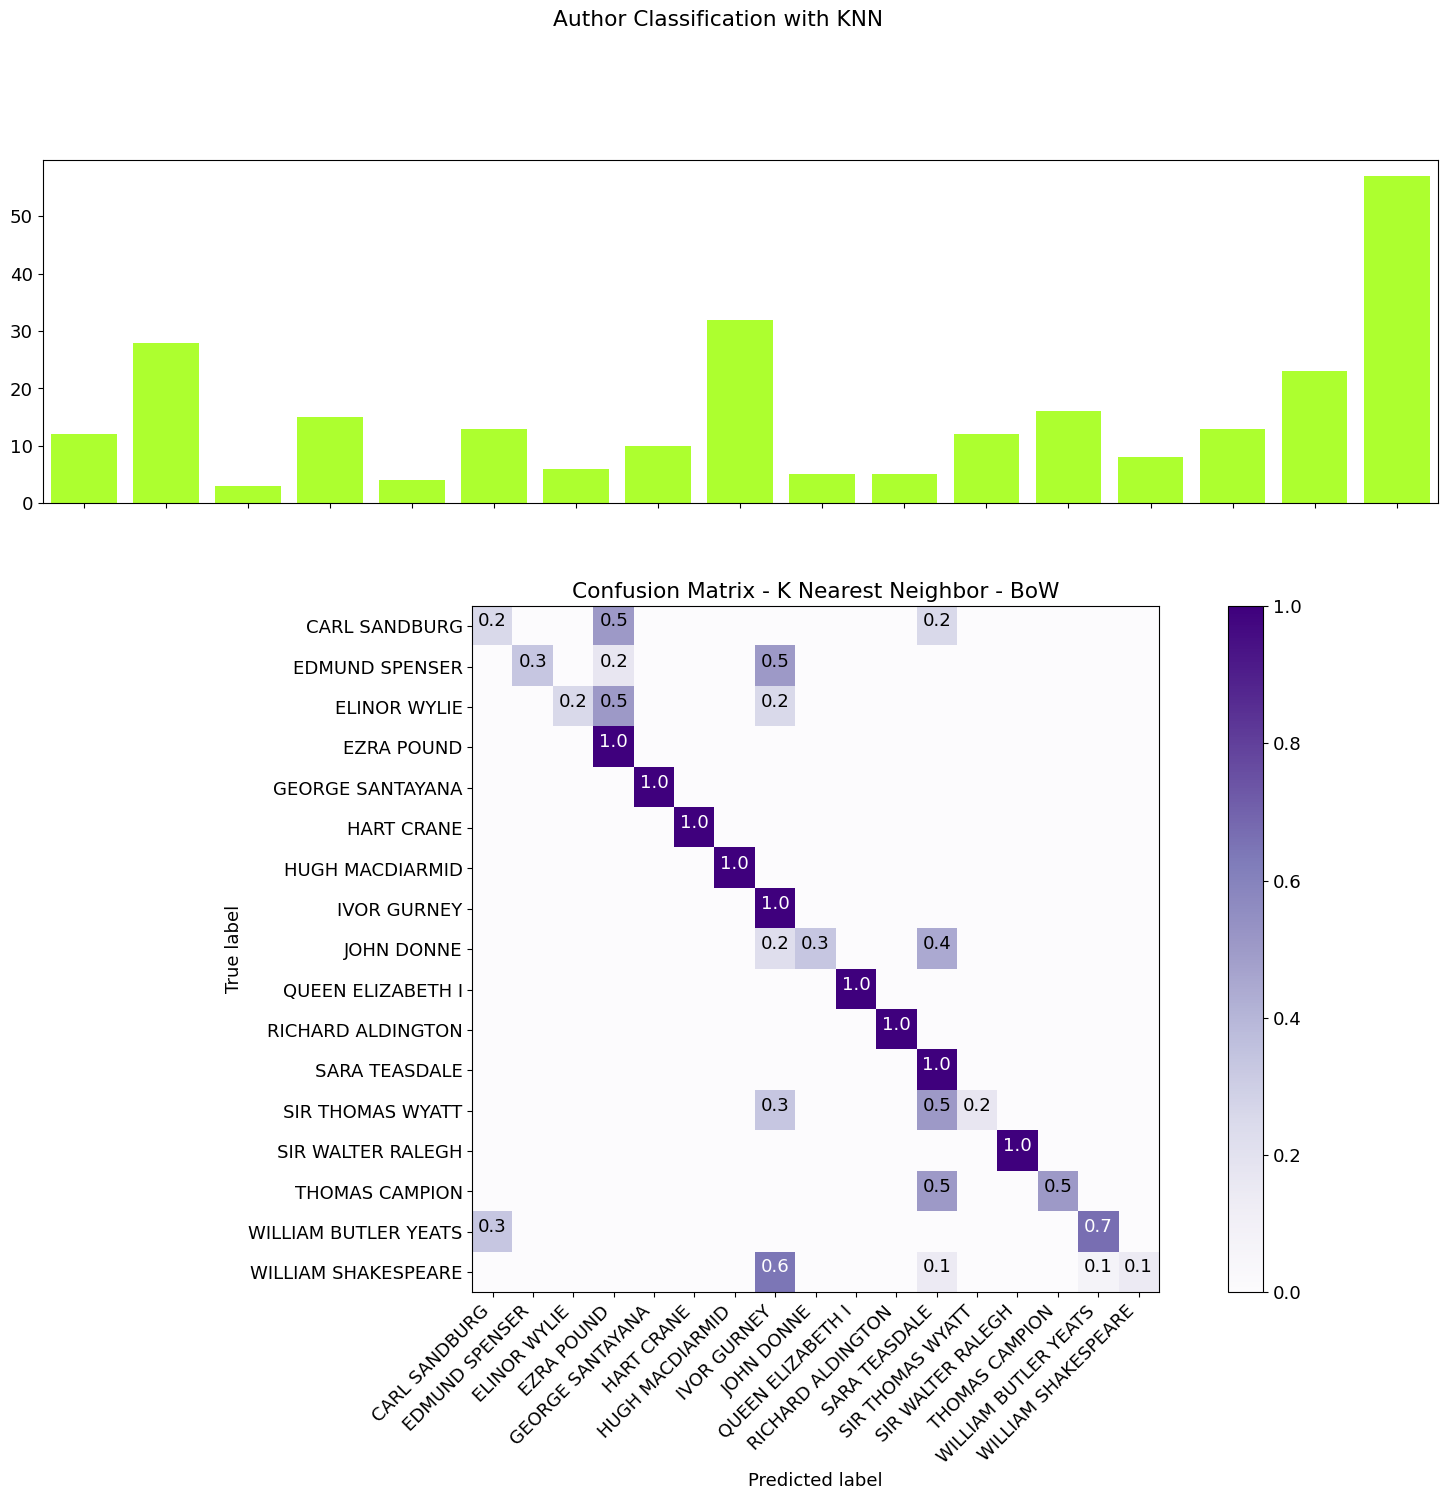

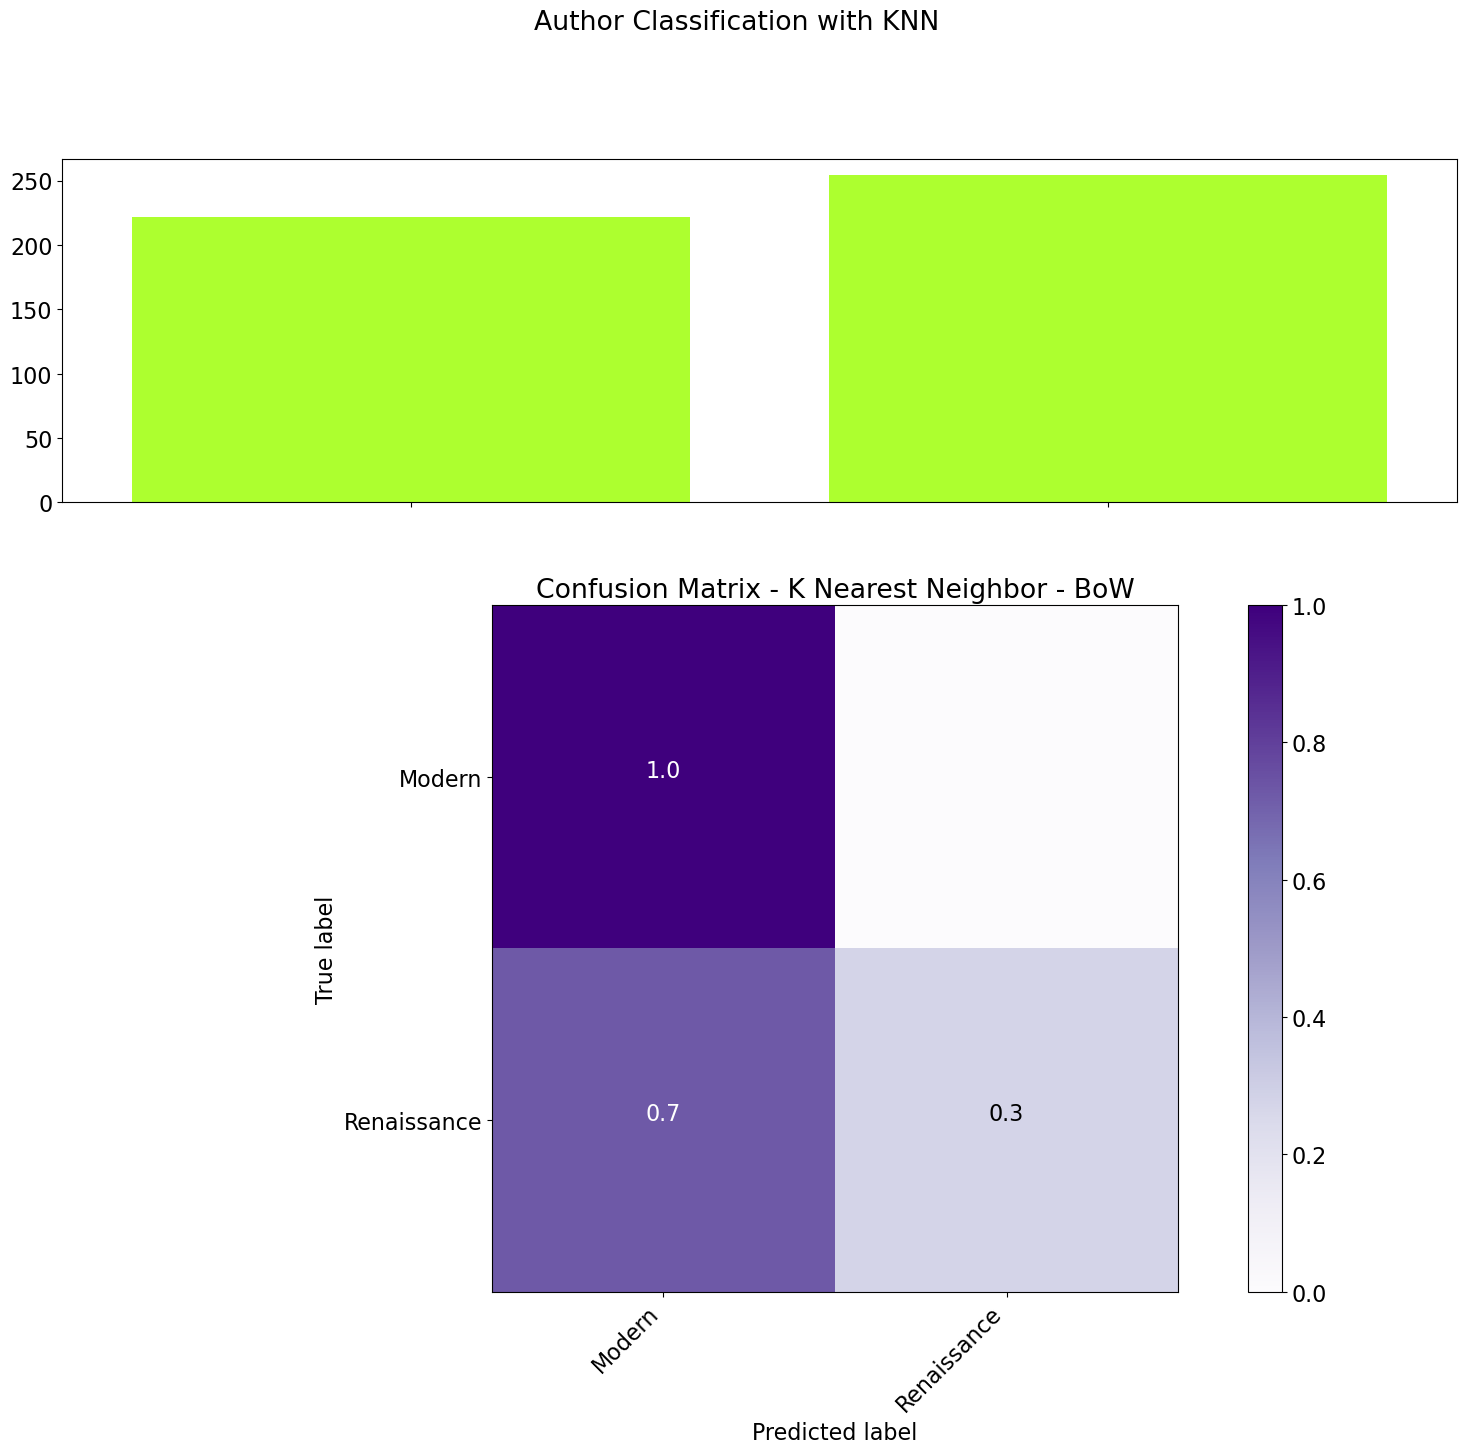

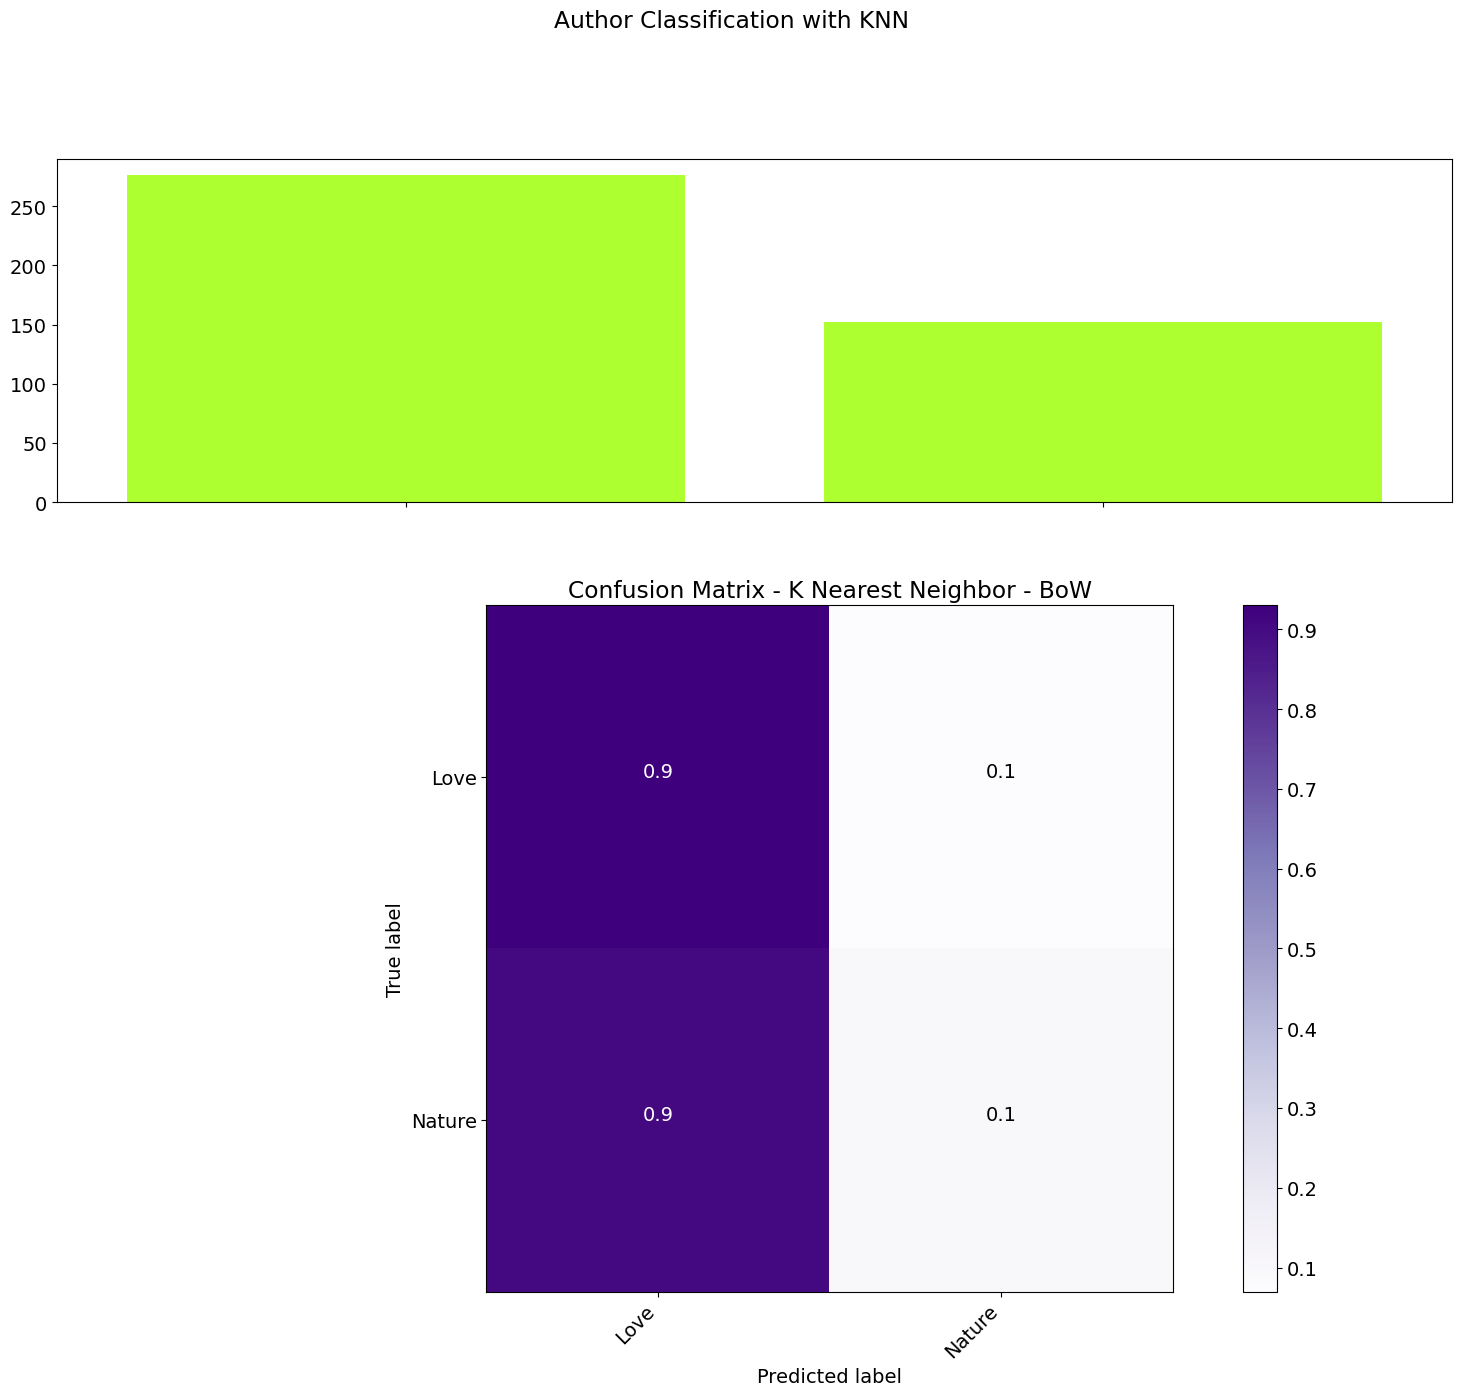

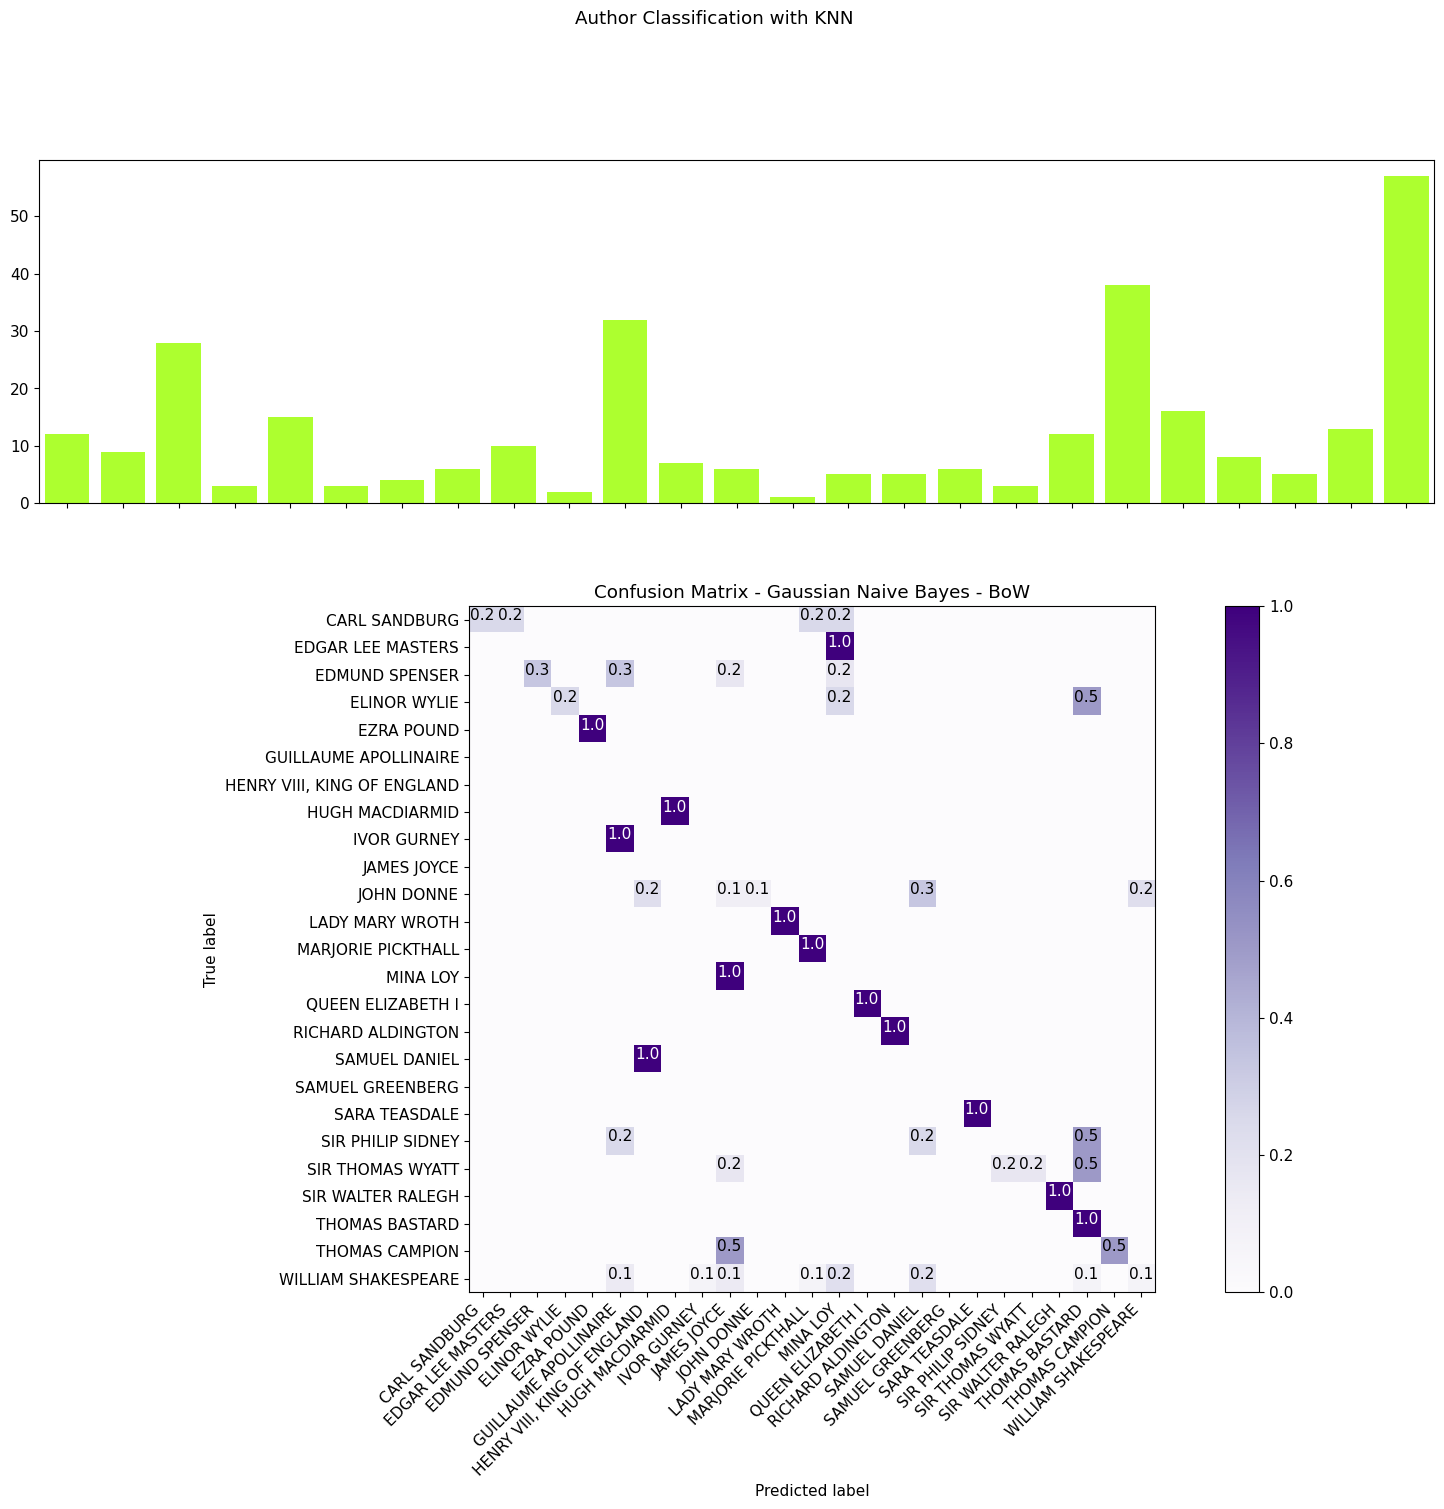

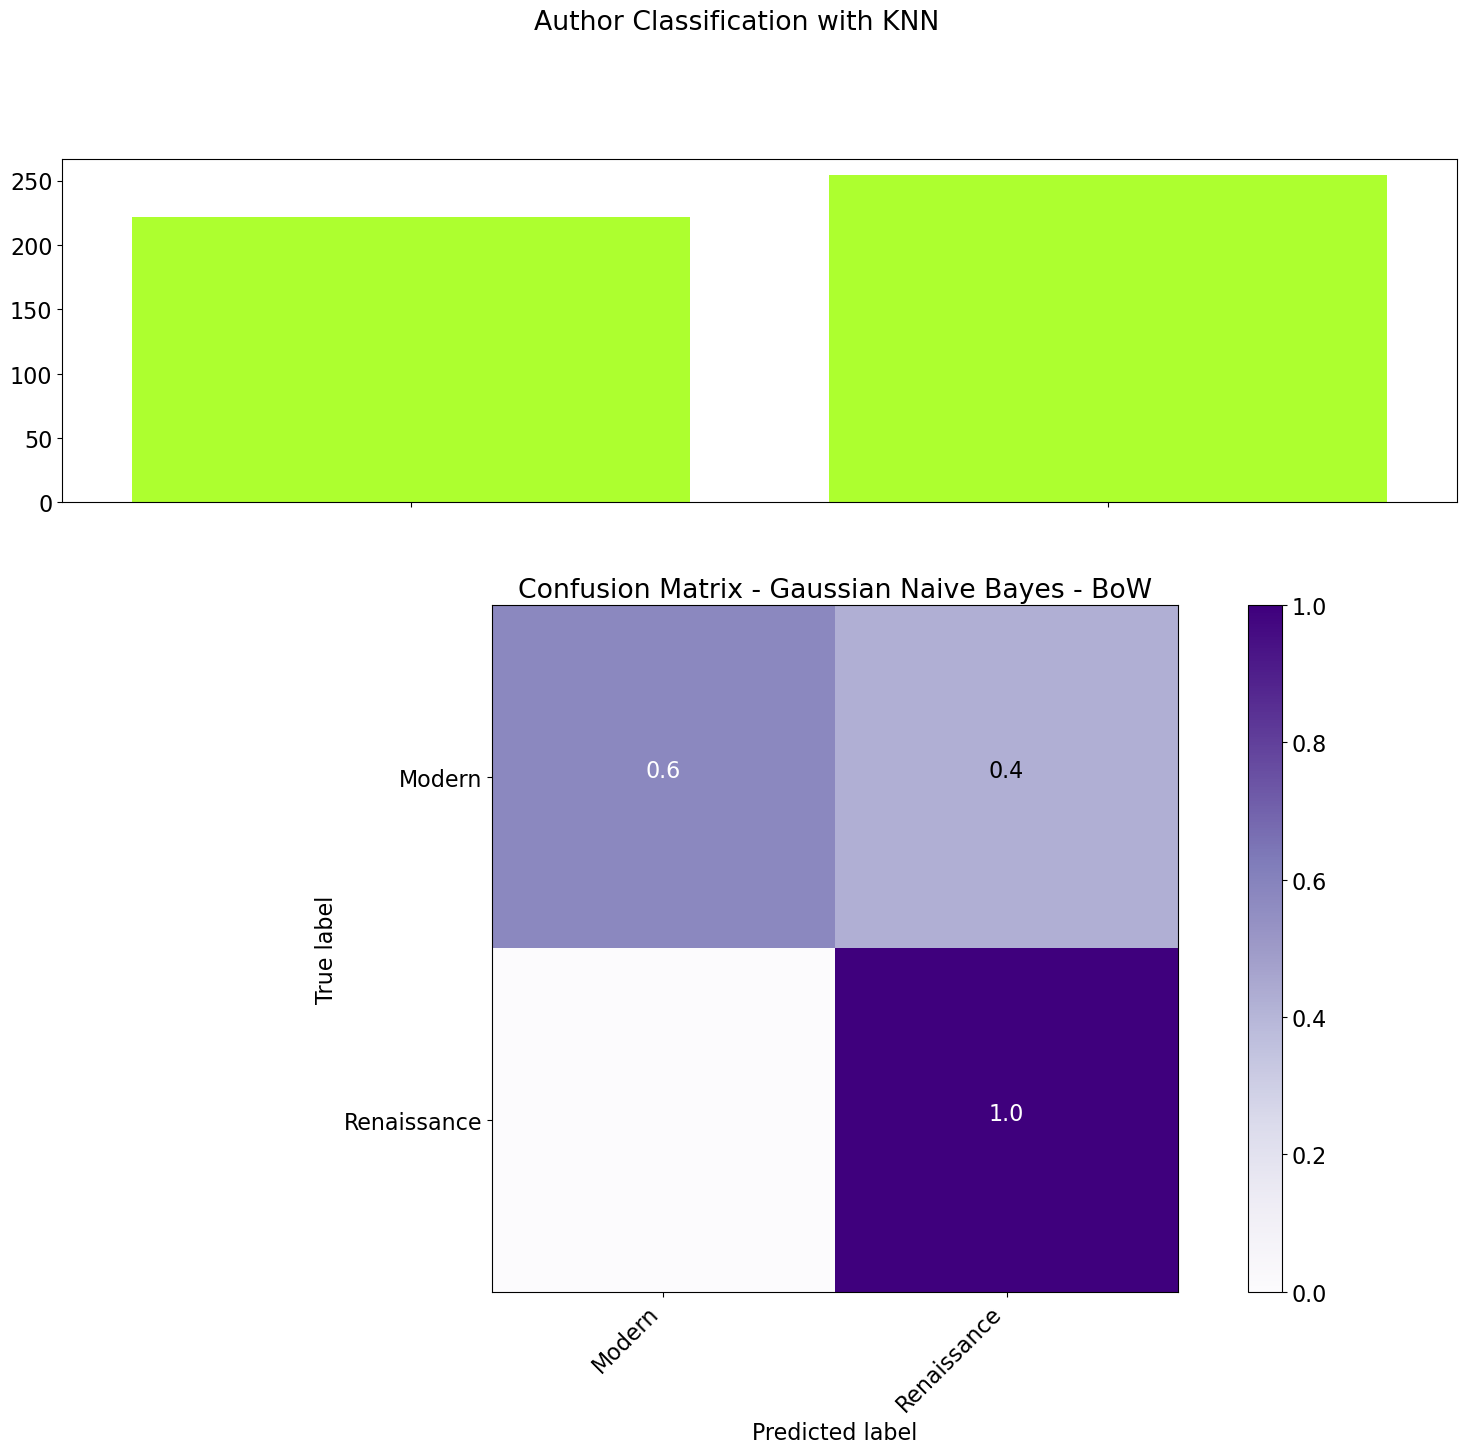

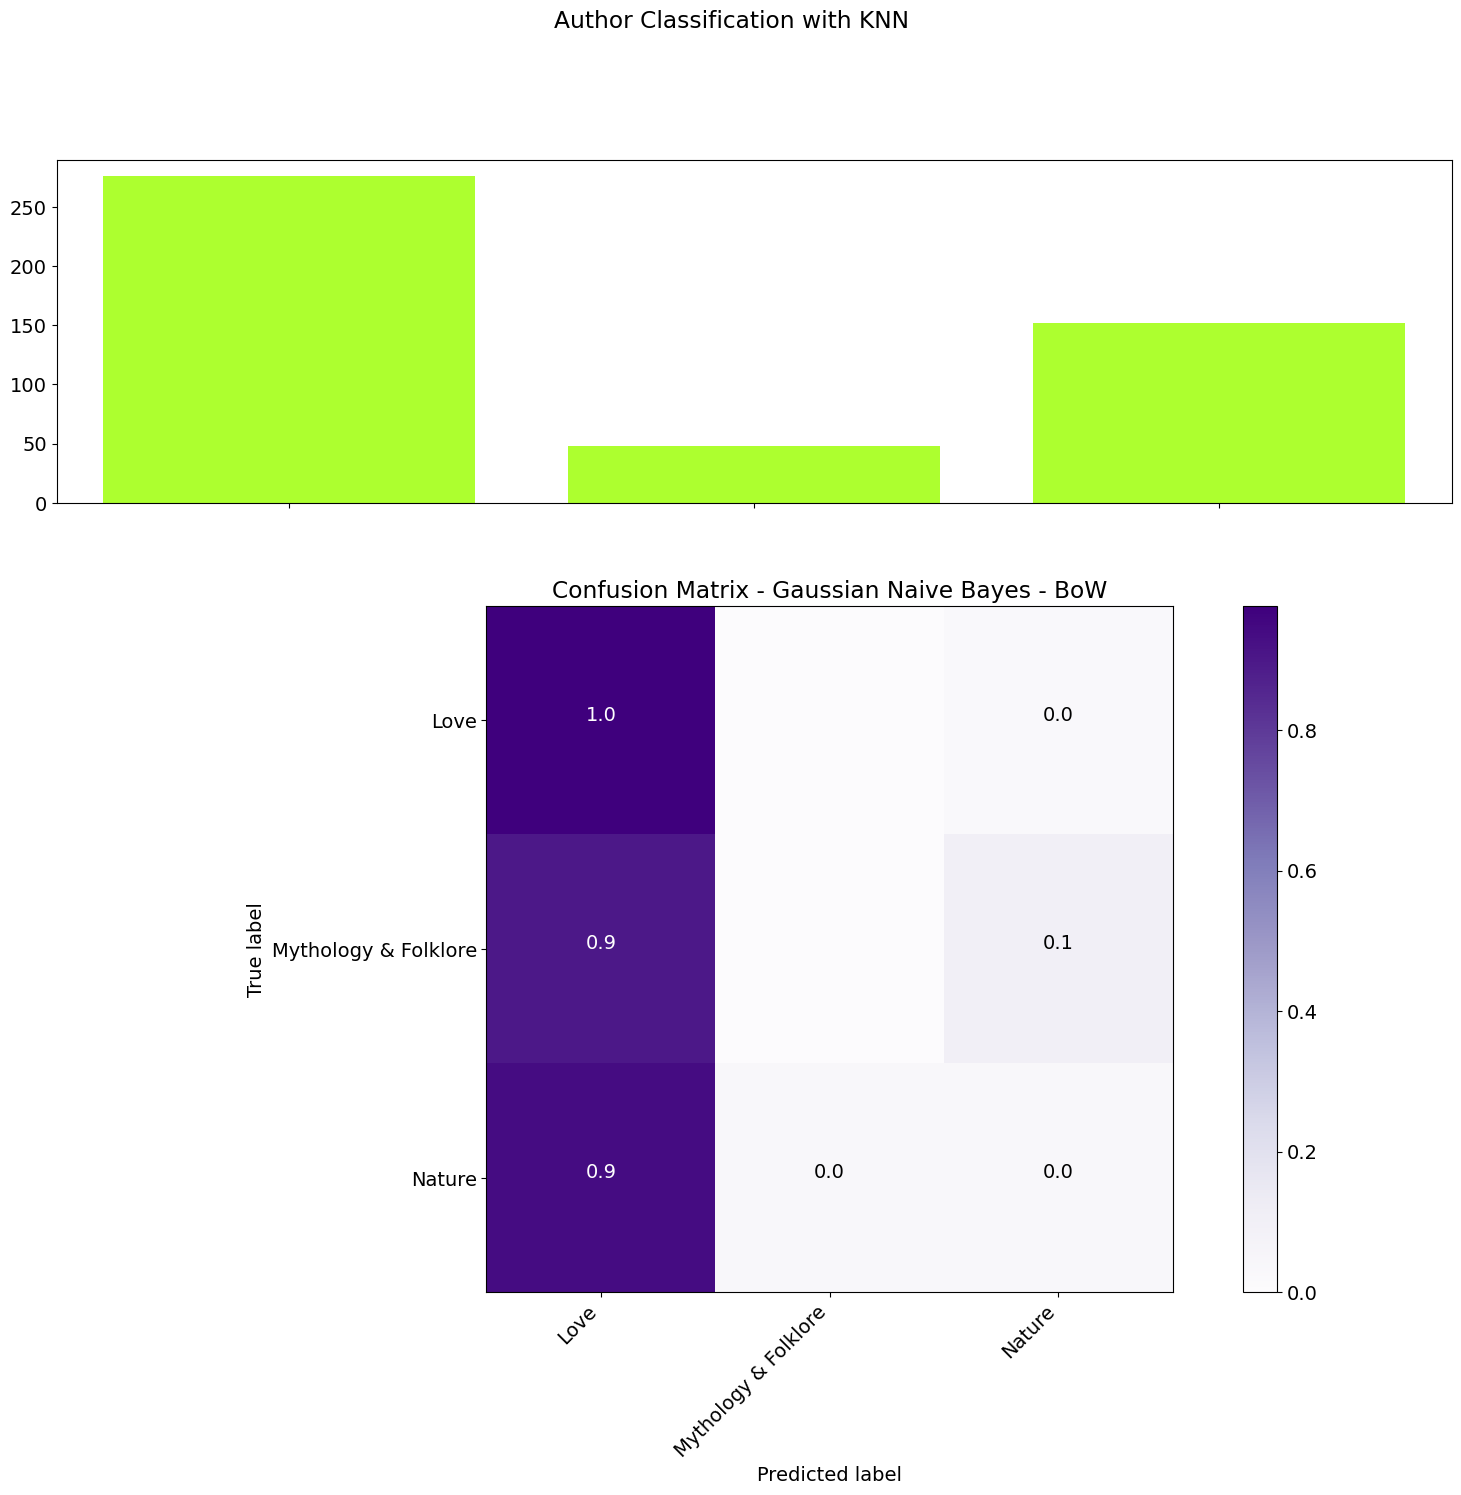

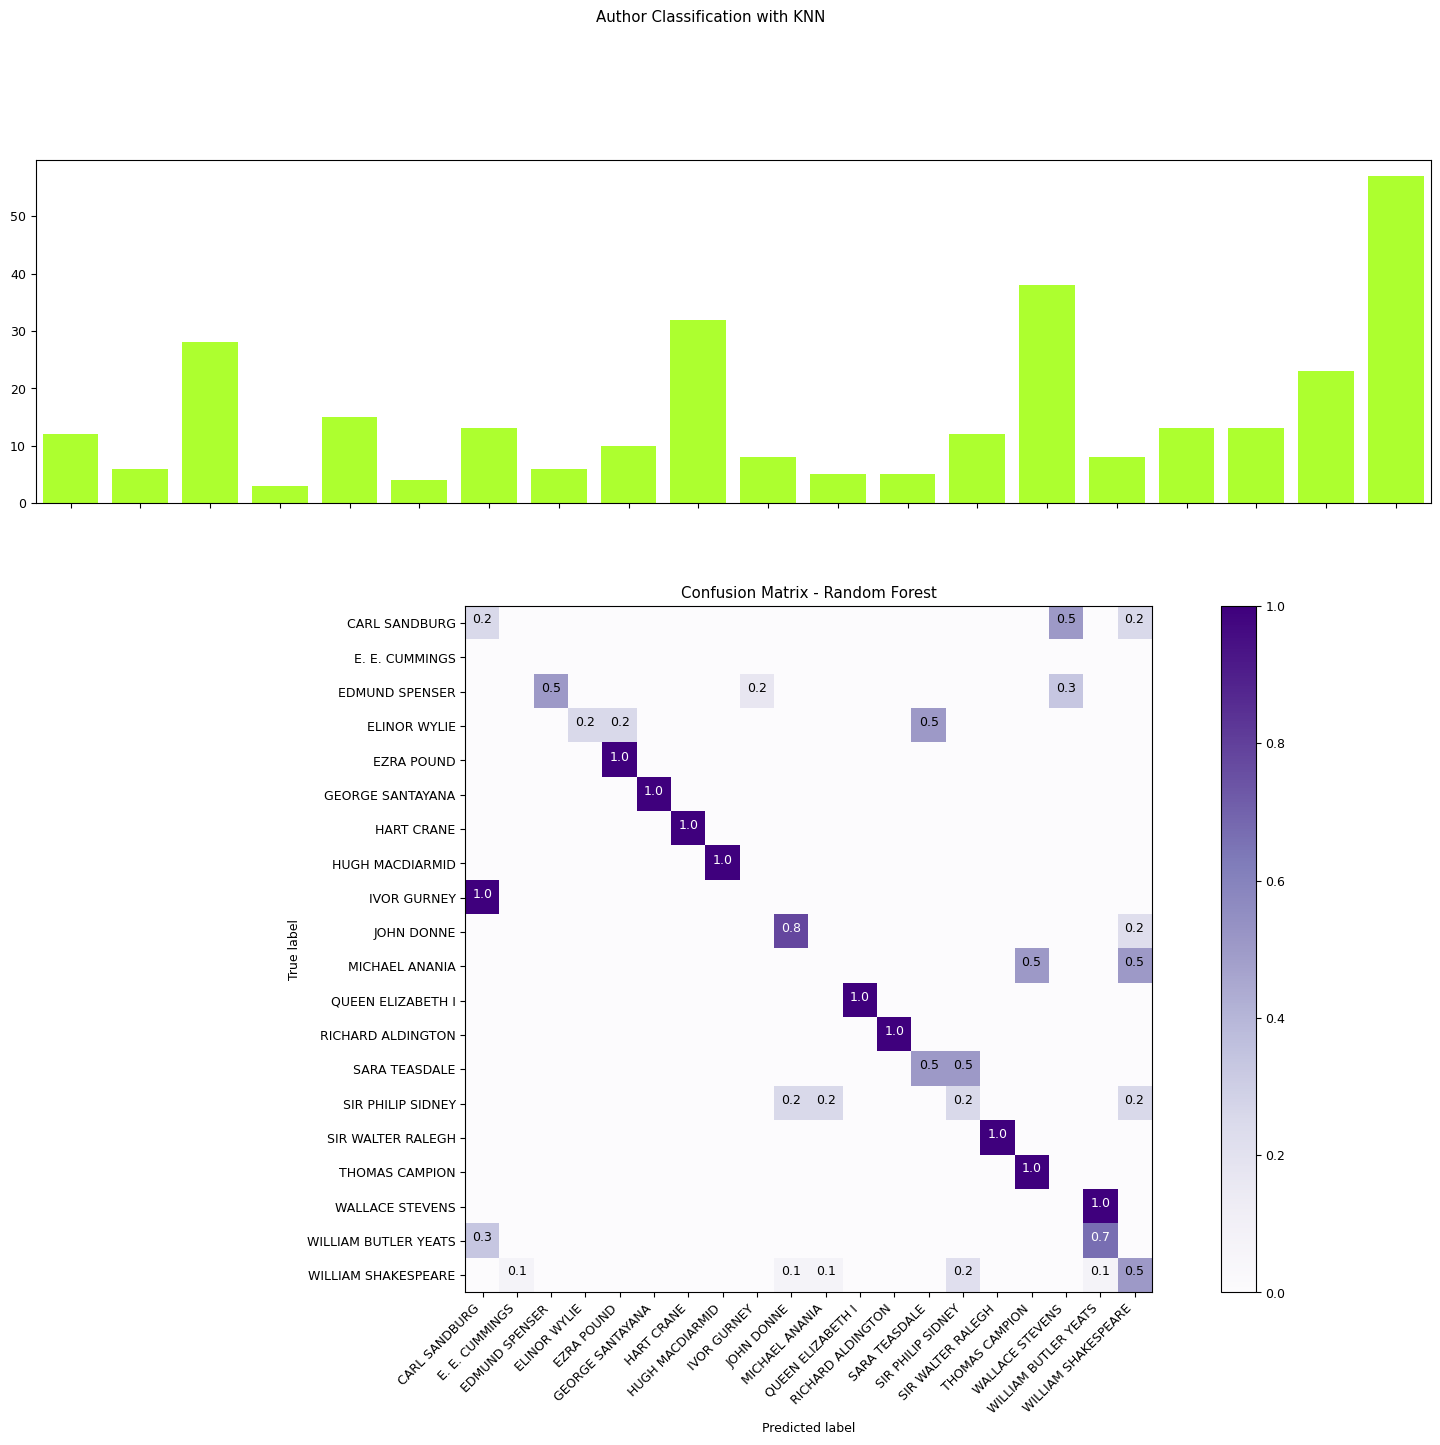

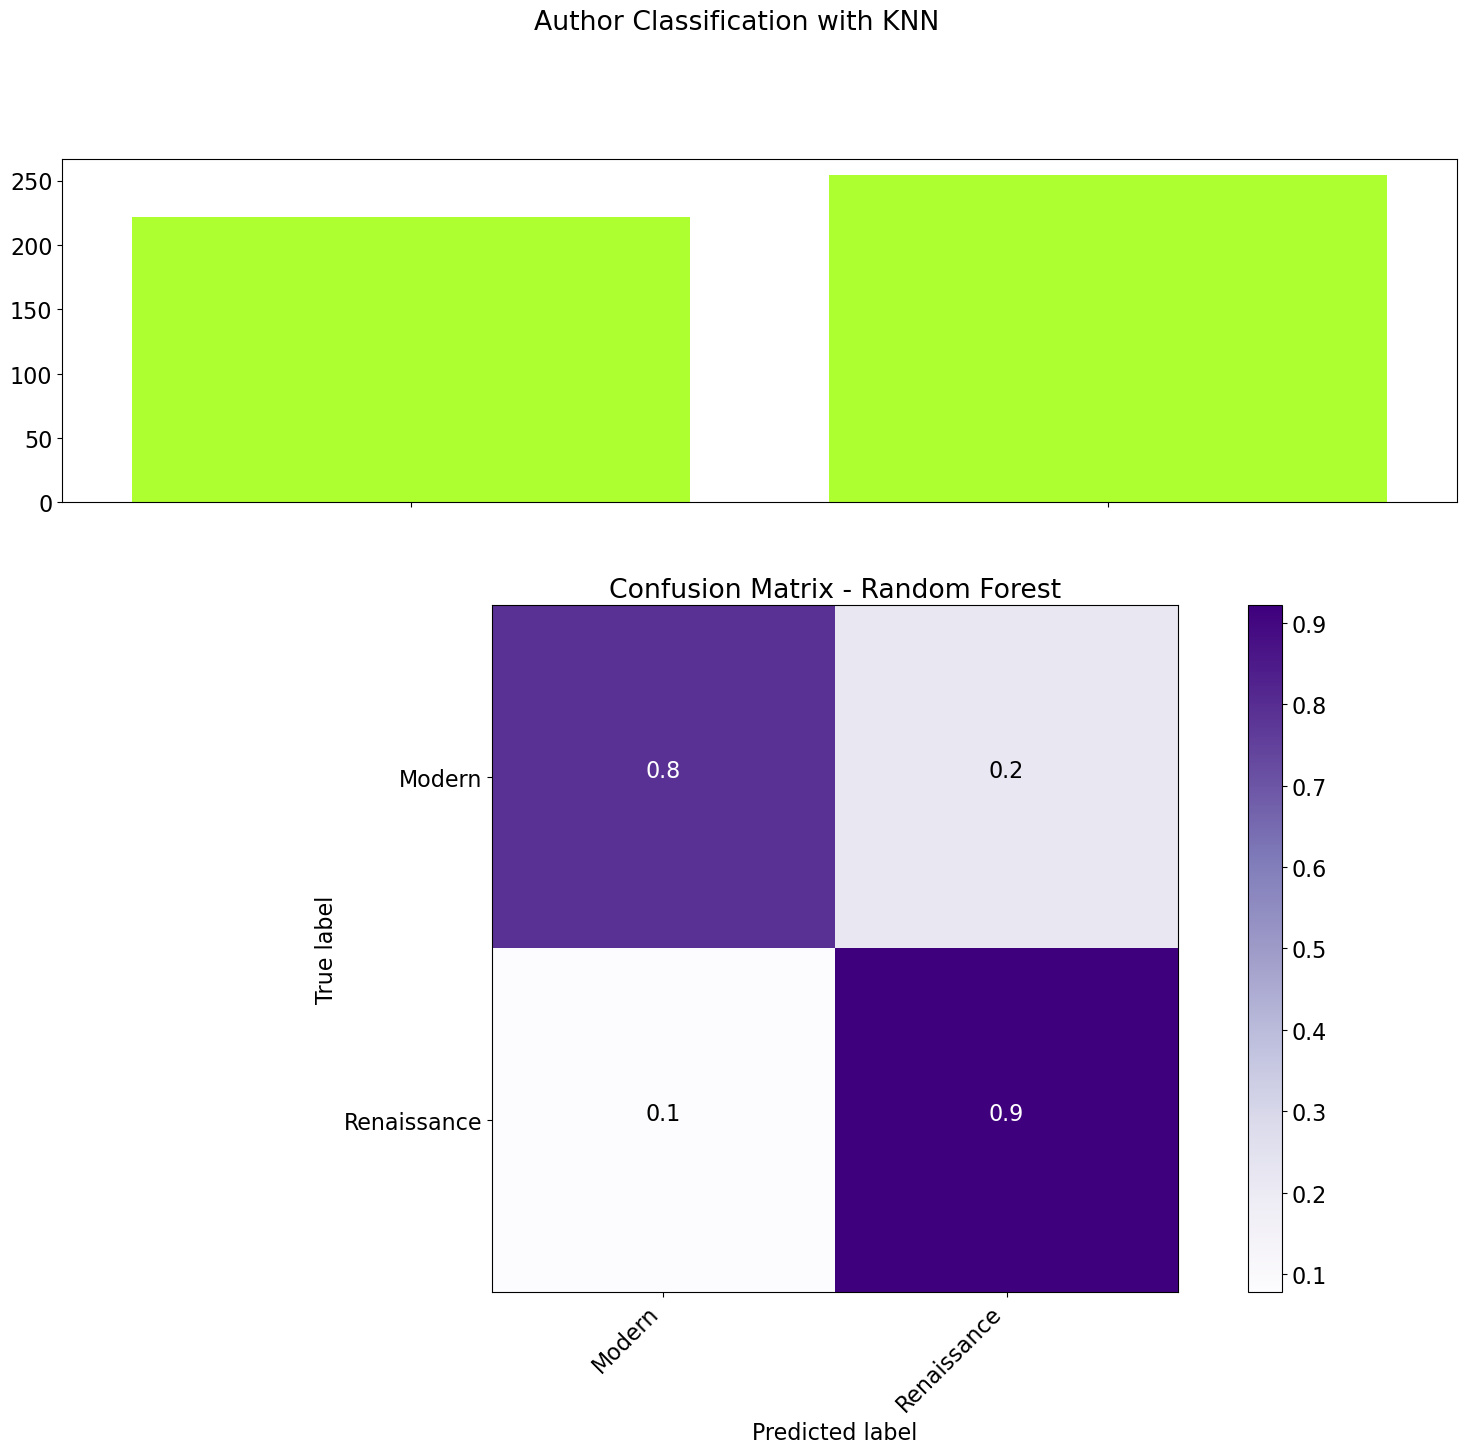

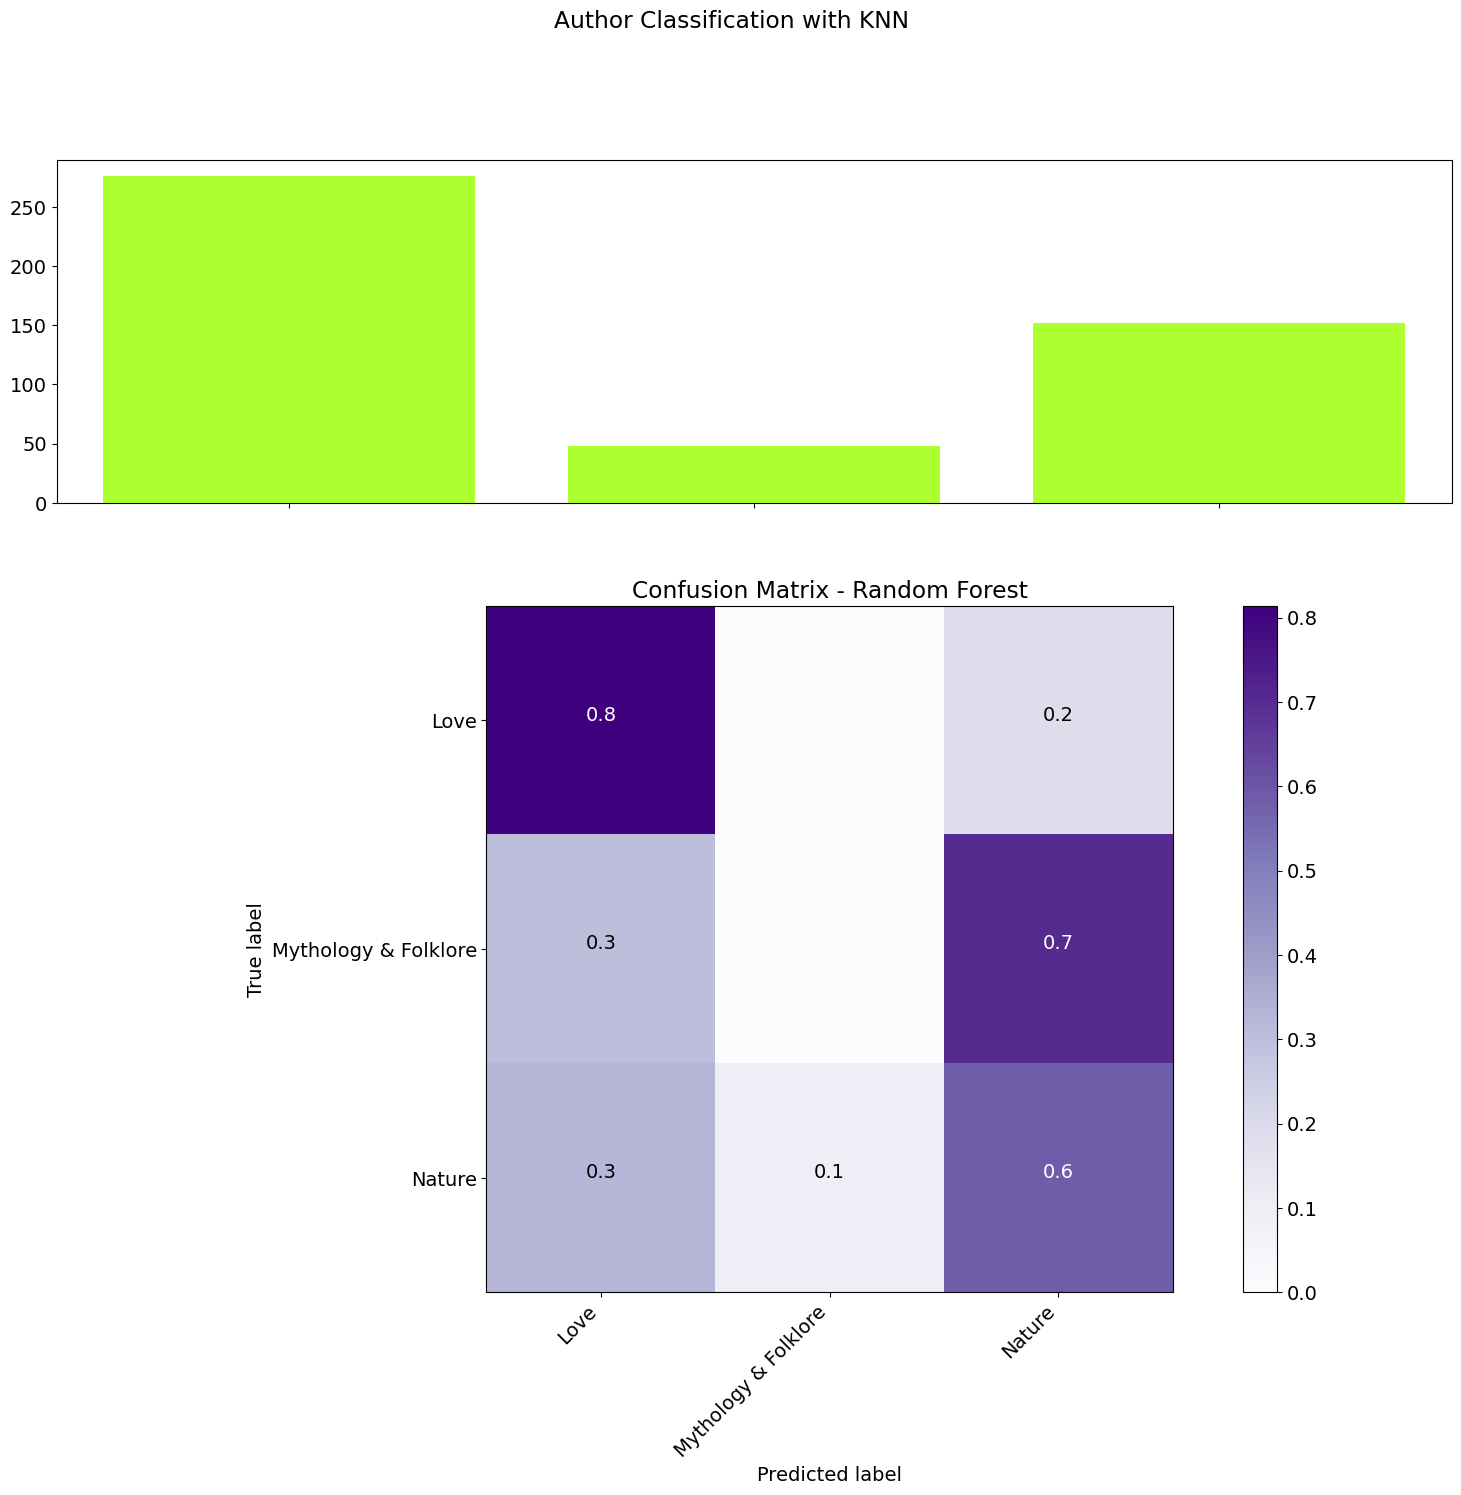

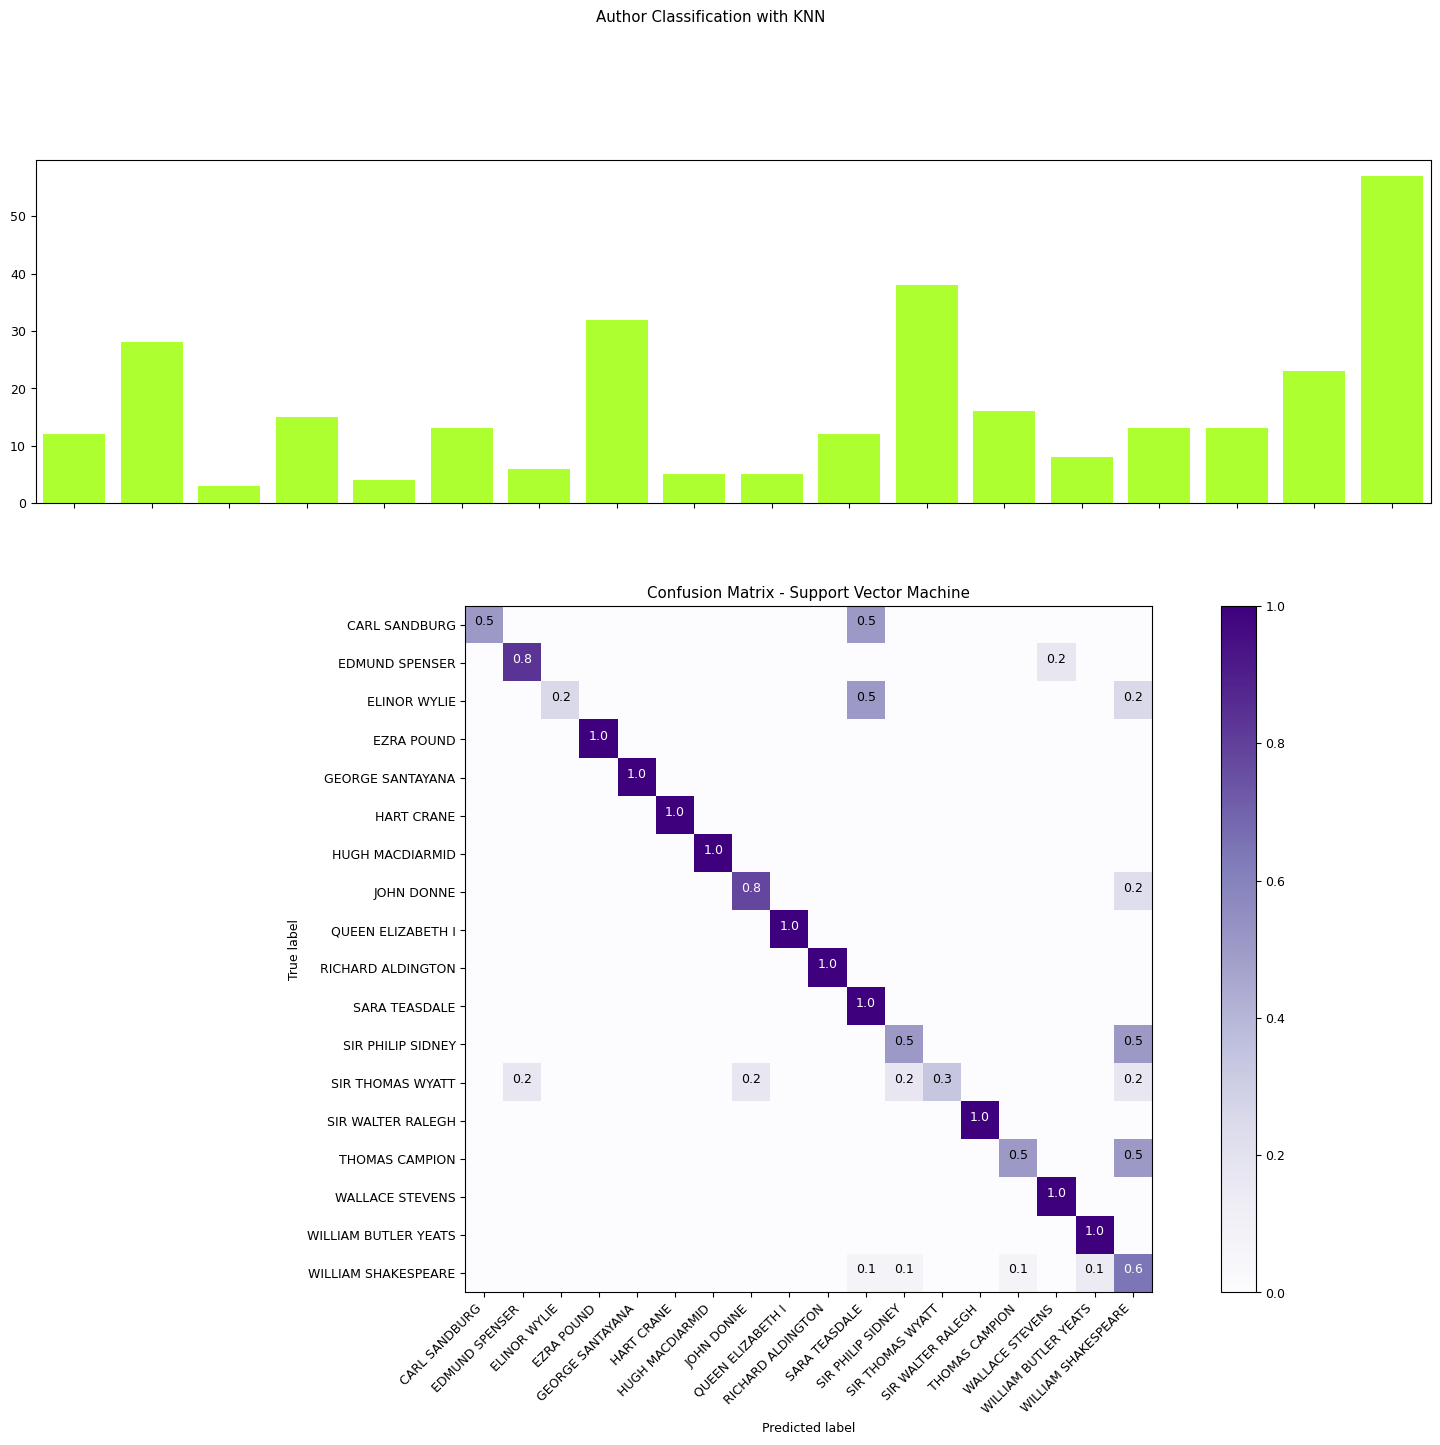

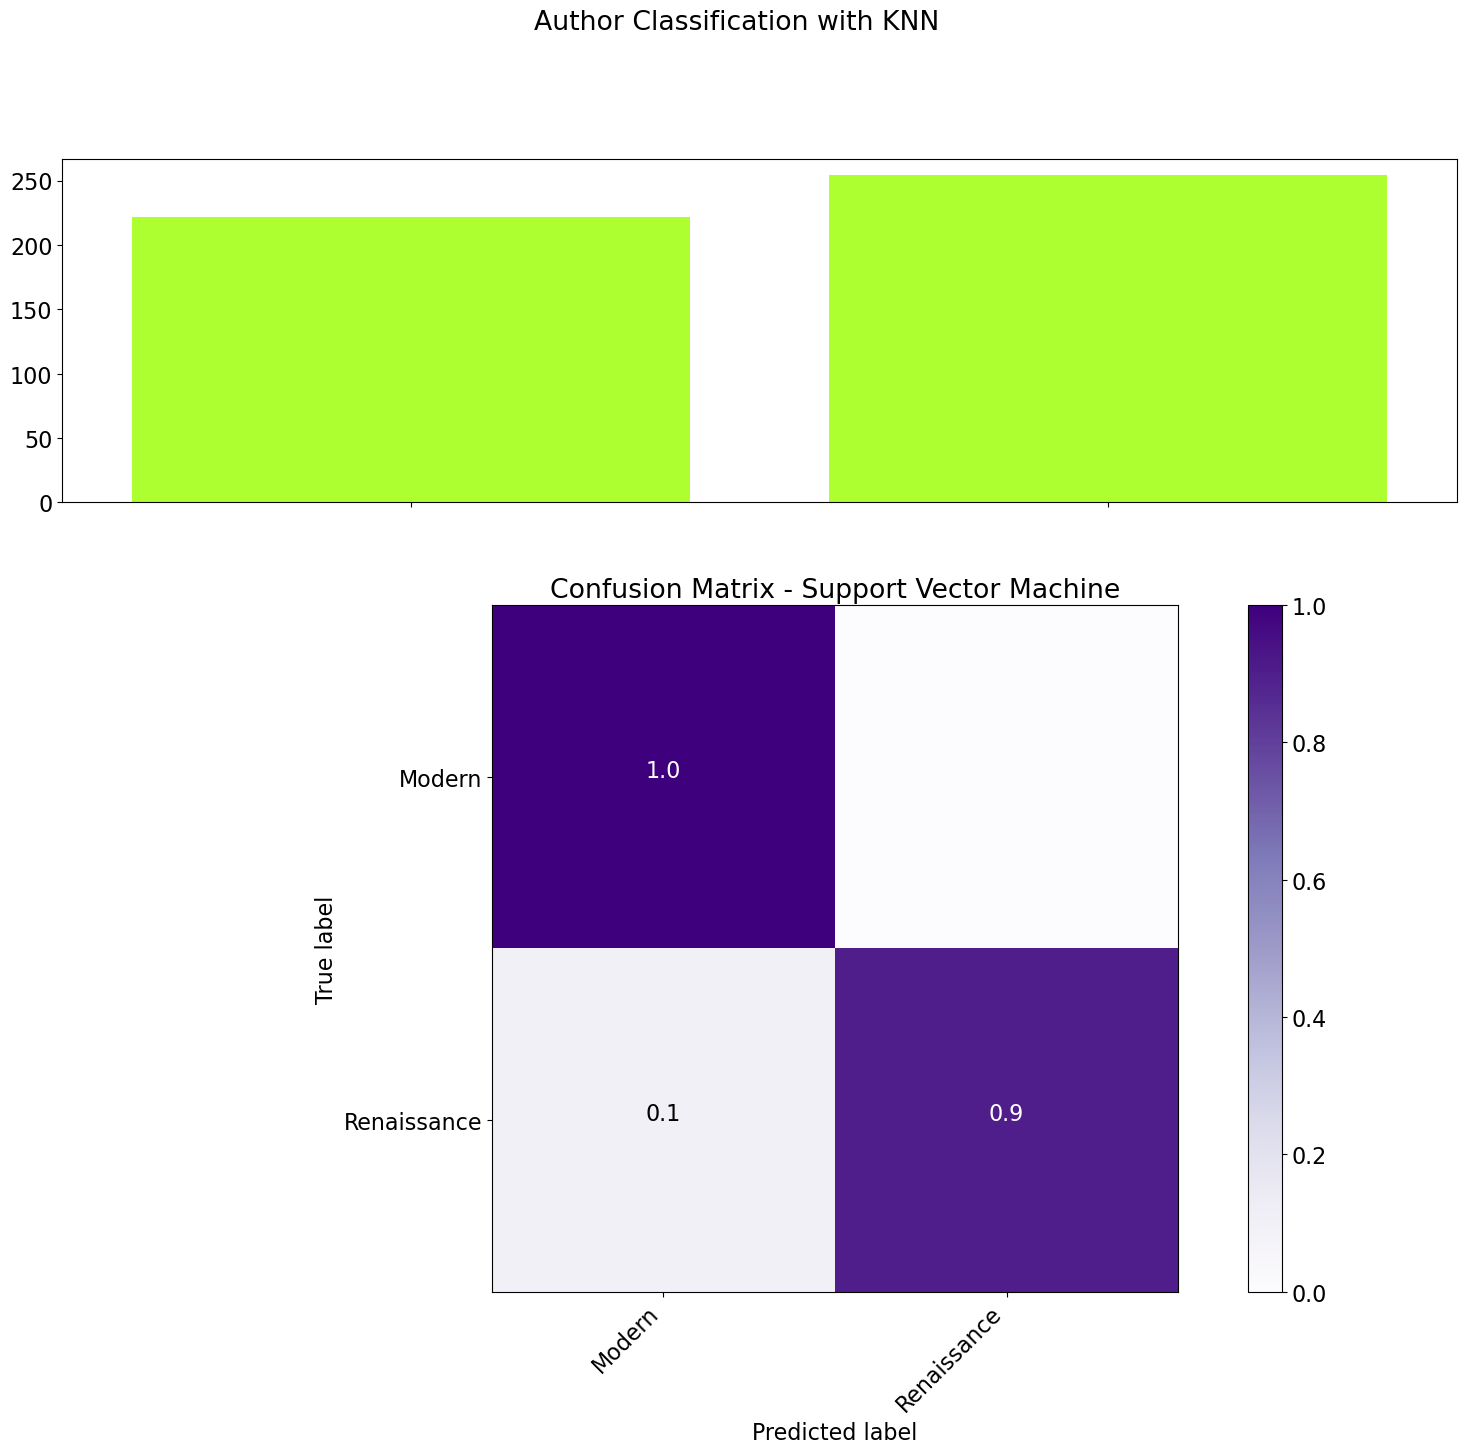

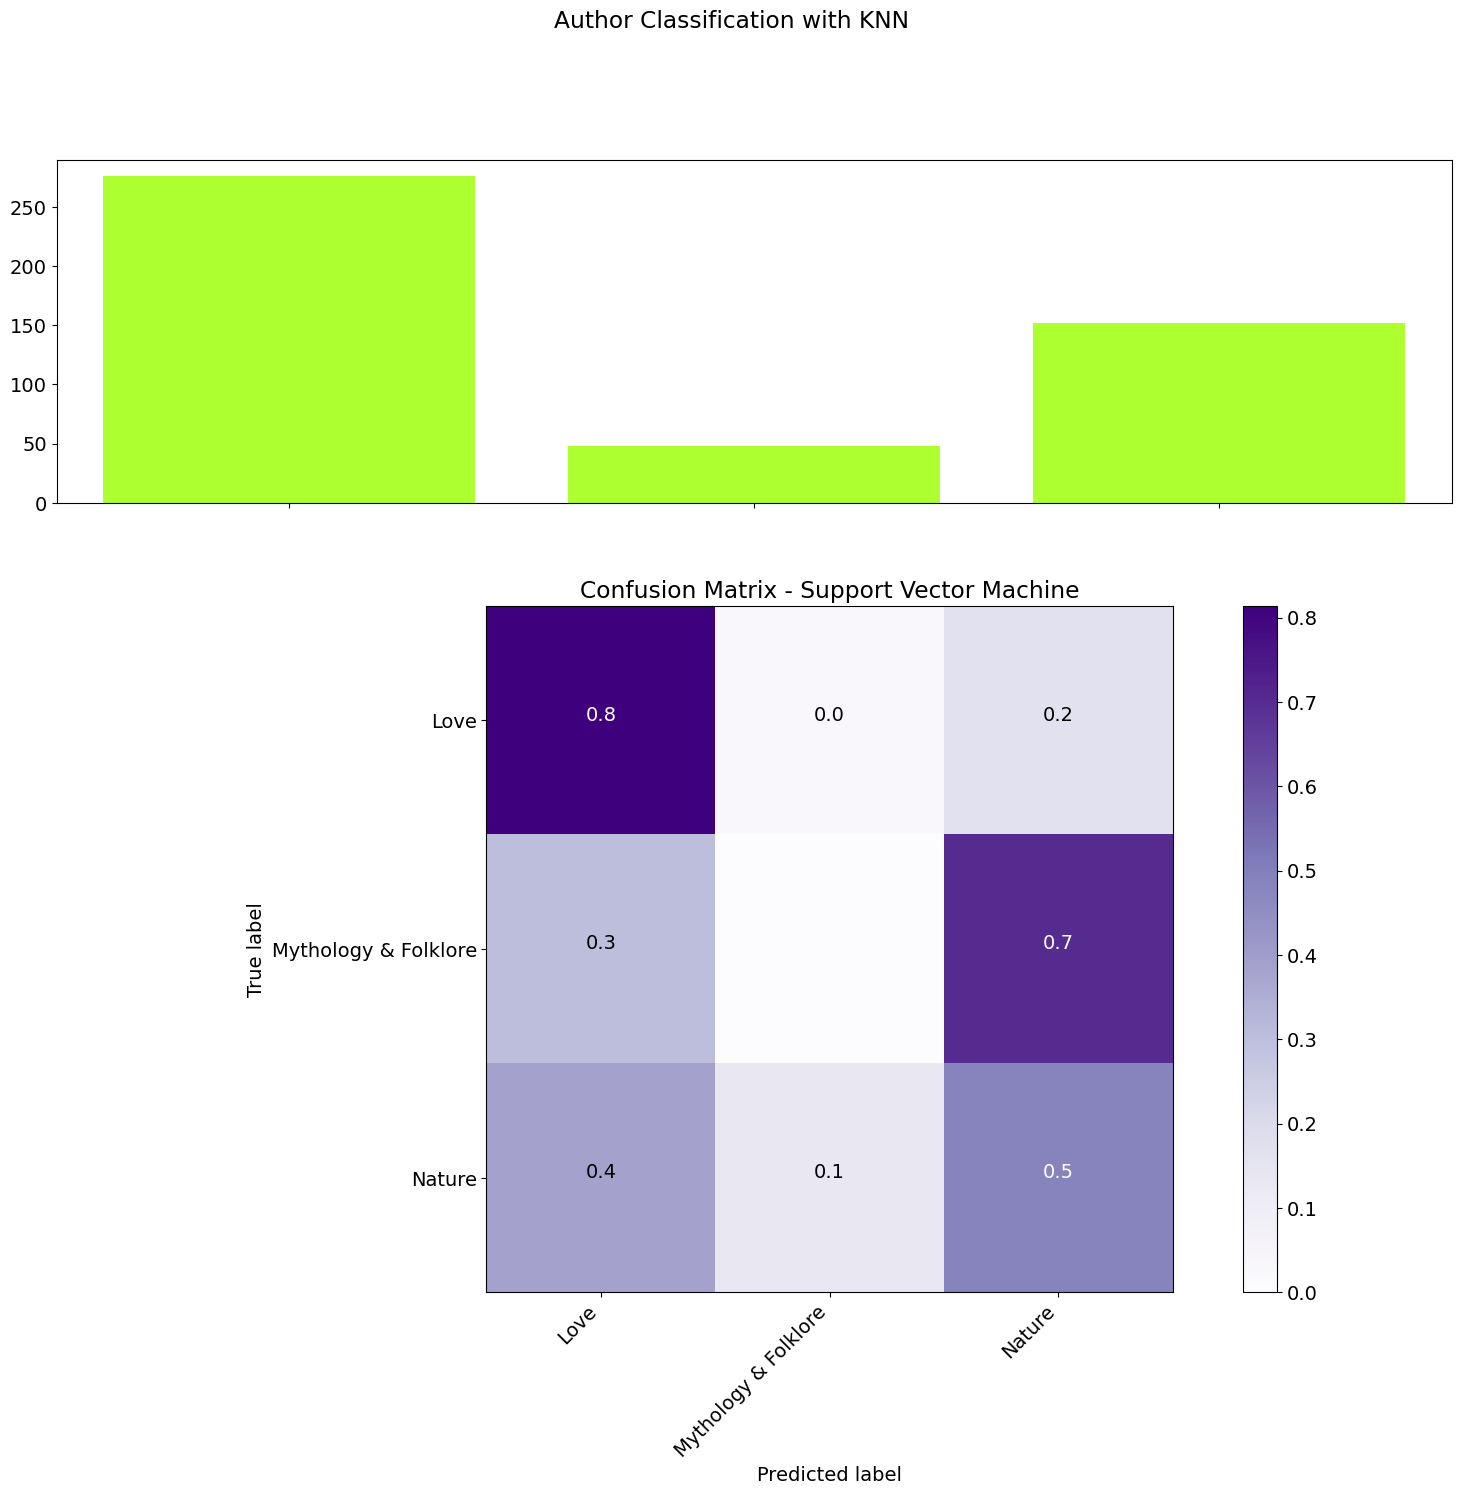

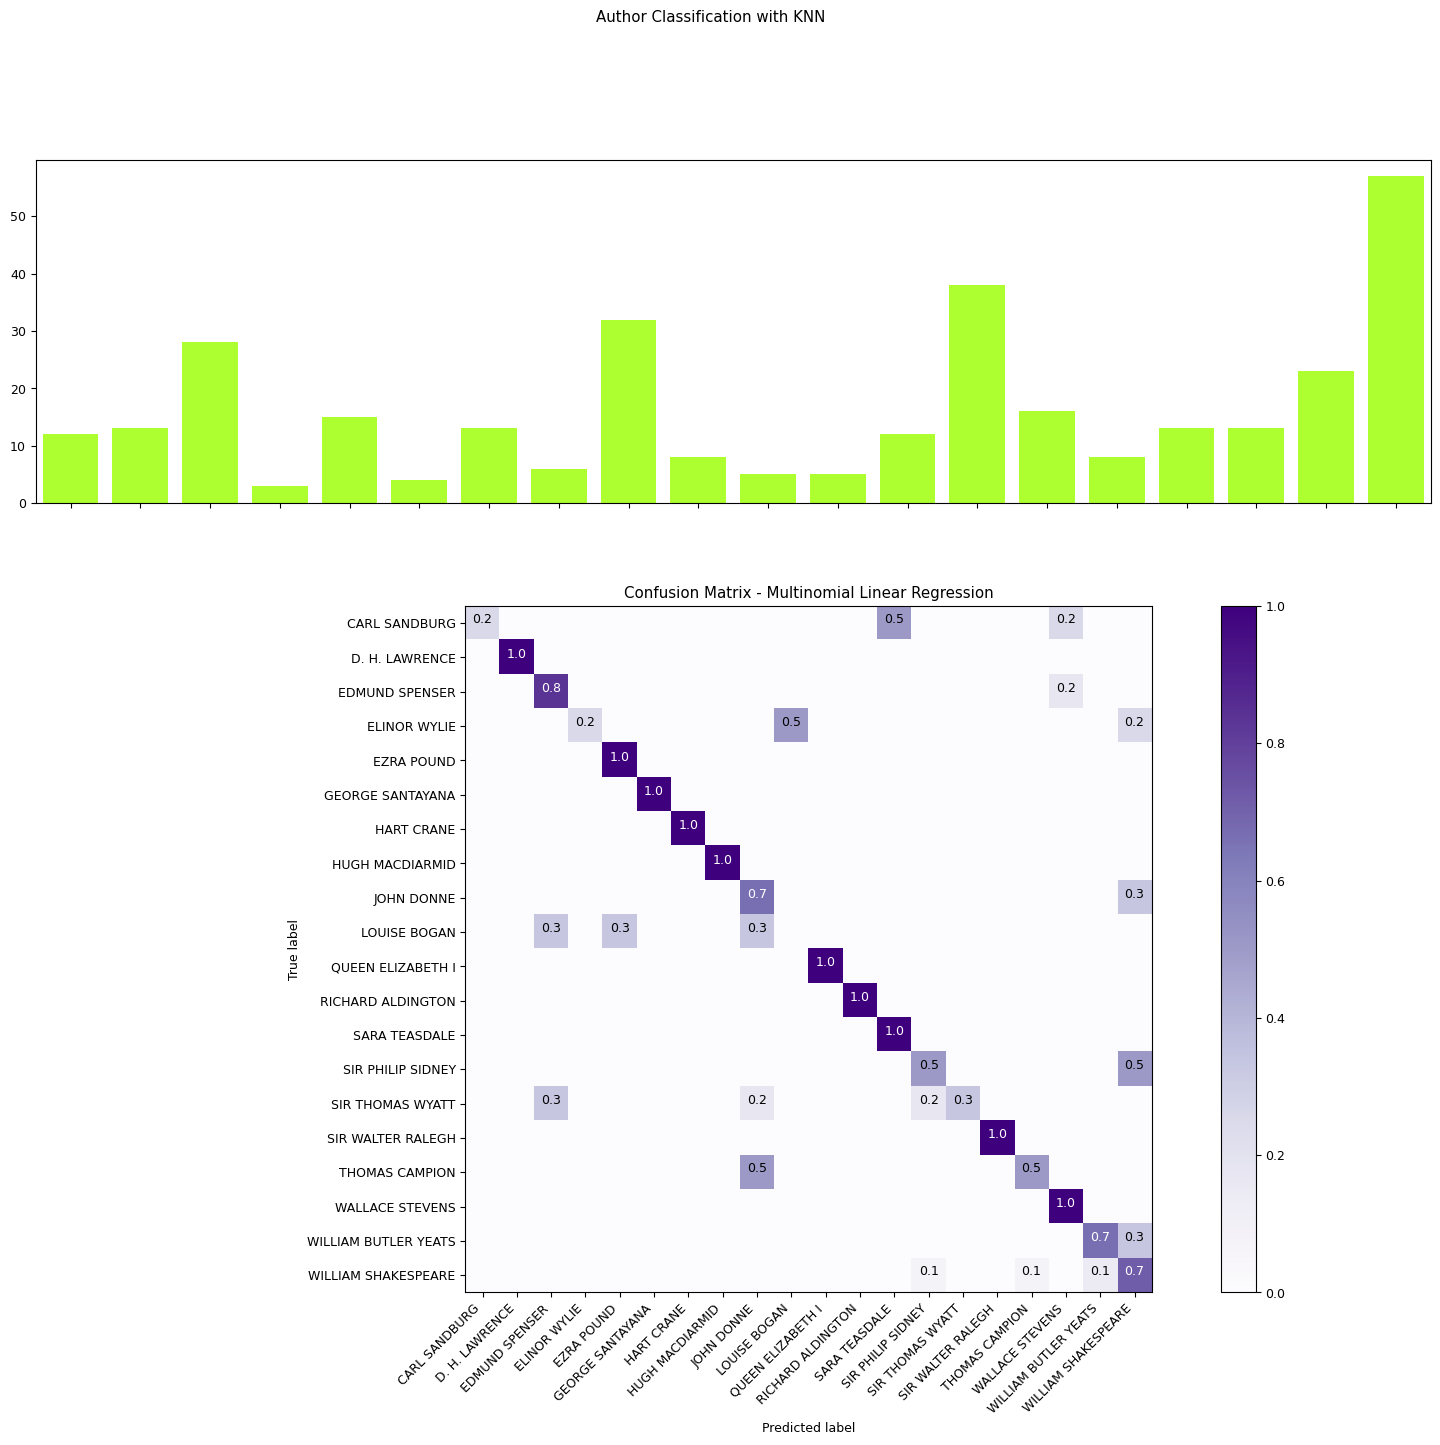

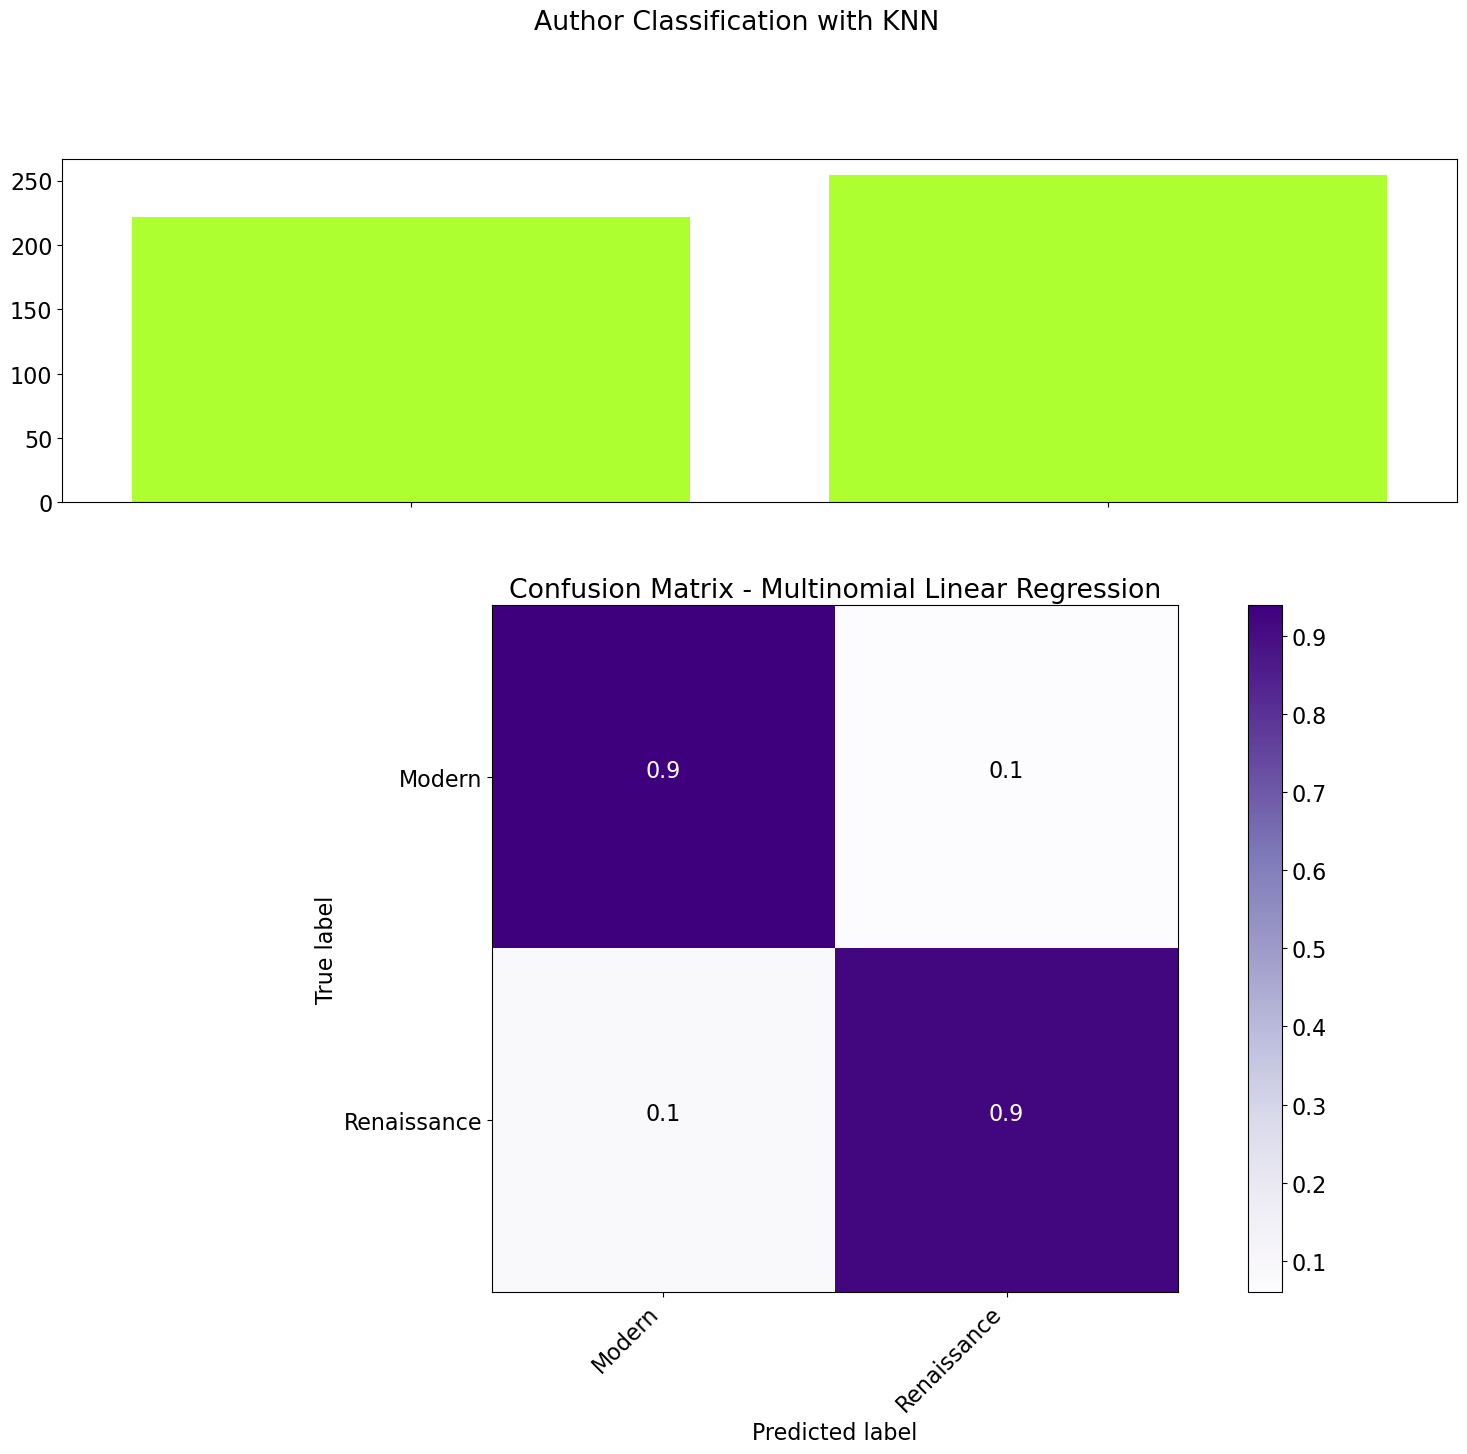

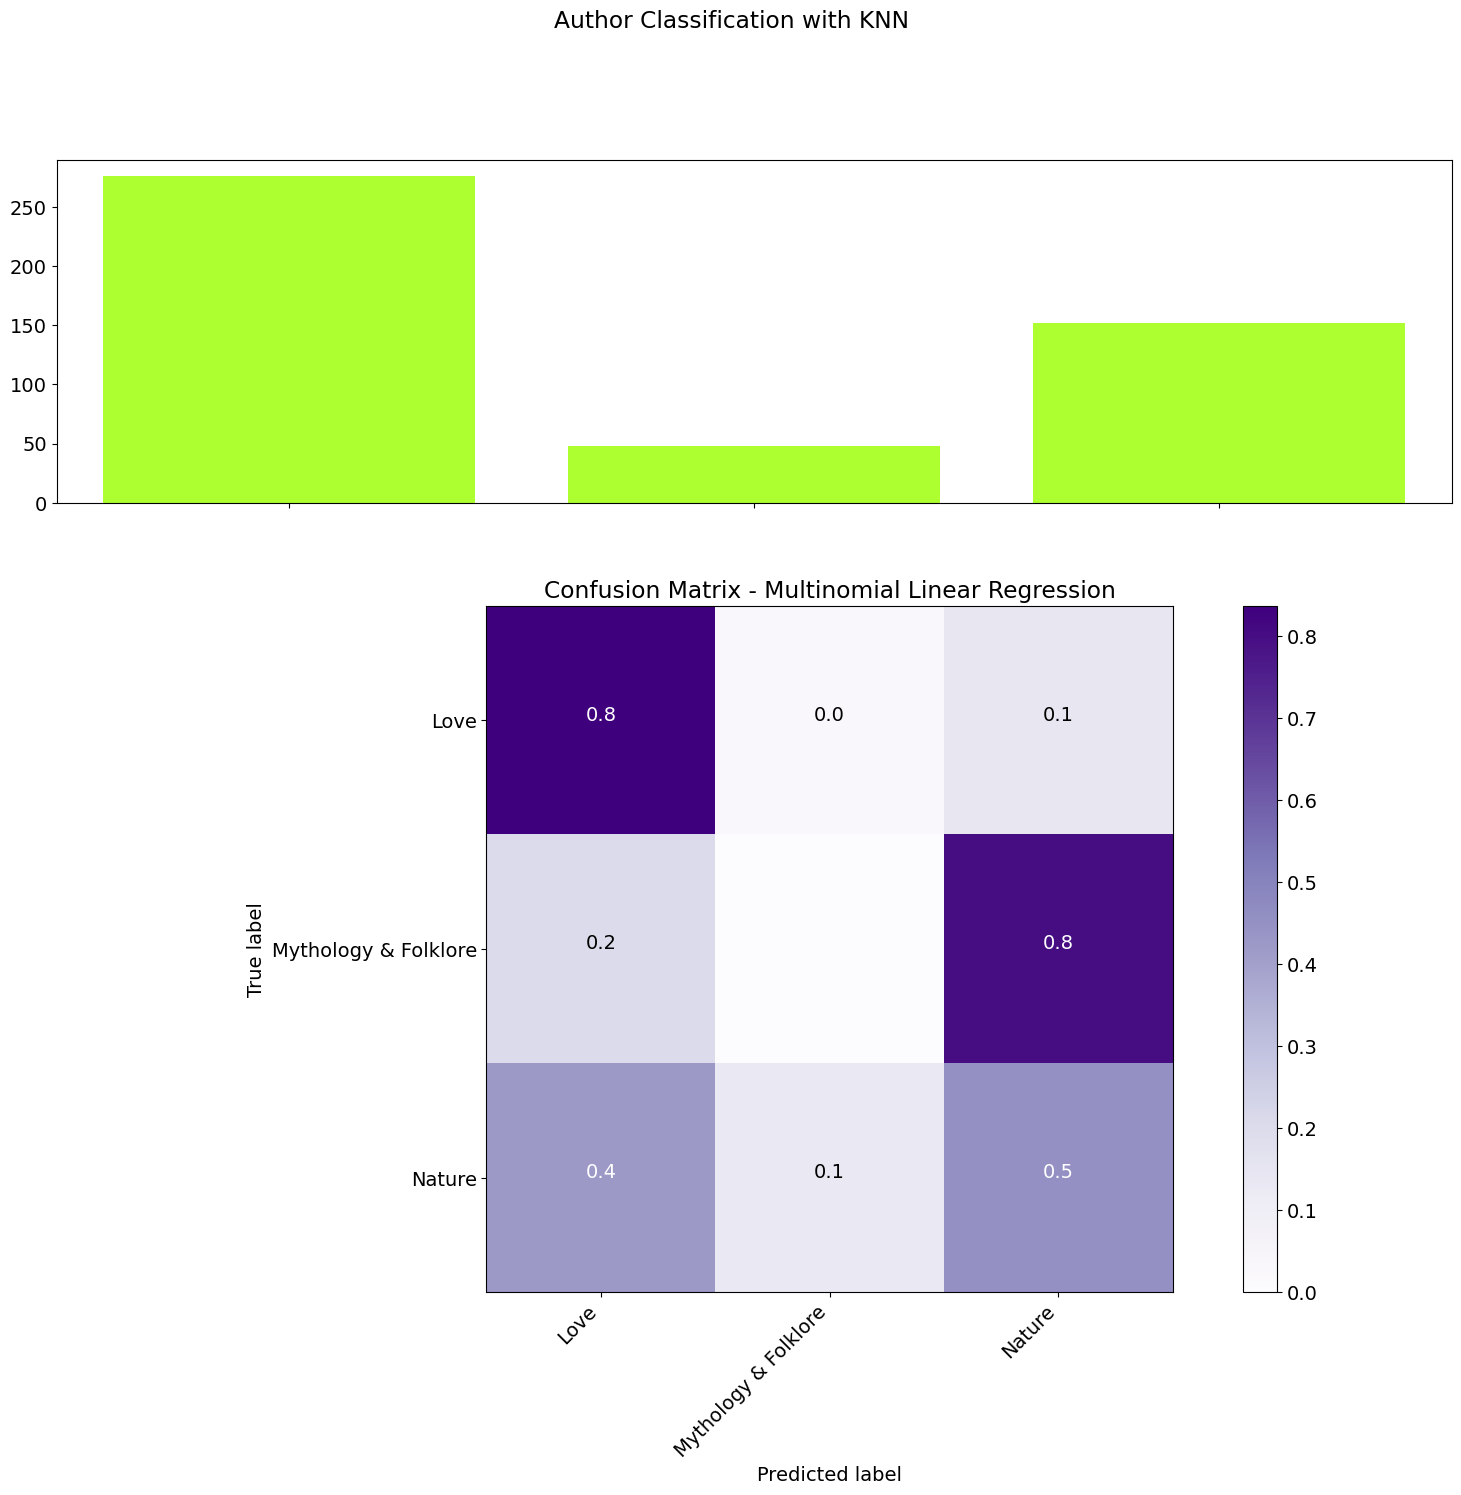

In [21]:
#KNN: 
determine_pred_counts(knn_perform_auth['predicted_labs_BoW'],knn_perform_era['predicted_labs_BoW'],knn_perform_sub['predicted_labs_BoW'])
#AUTHORS (BoW):
conf_mat_knn_auth = construct_conf_mat(auth_test,knn_perform_auth['predicted_labs_BoW'],all_authors)
plot_confusion_matrix(conf_mat_knn_auth,auth_train,all_authors,"Confusion Matrix - K Nearest Neighbor - BoW",True,all_authors_freq,"KNN_confmat_authors",13)
#ERA (BoW):
conf_mat_knn_era = construct_conf_mat(era_test,knn_perform_era['predicted_labs_BoW'],all_eras)
plot_confusion_matrix(conf_mat_knn_era,era_train,all_eras,"Confusion Matrix - K Nearest Neighbor - BoW",True,all_eras_freq,"KNN_confmat_eras",16)
#SUBJECT (BoW):
conf_mat_knn_sub = construct_conf_mat(sub_test,knn_perform_sub['predicted_labs_BoW'],all_subjects)
plot_confusion_matrix(conf_mat_knn_sub,sub_train,all_subjects,"Confusion Matrix - K Nearest Neighbor - BoW",True,all_subjects_freq,"KNN_confmat_subjects",14)



#gNB:
determine_pred_counts(gnb_perform_auth['predicted_labs_BoW'],gnb_perform_era['predicted_labs_BoW'],gnb_perform_sub['predicted_labs_BoW'])
#AUTHORS (BoW):
conf_mat_gnb_auth = construct_conf_mat(auth_test,gnb_perform_auth['predicted_labs_BoW'],all_authors)
print(conf_mat_gnb_auth.shape)
plot_confusion_matrix(conf_mat_gnb_auth,auth_train,all_authors,"Confusion Matrix - Gaussian Naive Bayes - BoW",True,all_authors_freq,"gNB_confmat_authors",11)
#ERA (BoW):
conf_mat_gnb_era = construct_conf_mat(era_test,gnb_perform_era['predicted_labs_BoW'],all_eras)
plot_confusion_matrix(conf_mat_gnb_era,era_train,all_eras,"Confusion Matrix - Gaussian Naive Bayes - BoW",True,all_eras_freq,"gNB_confmat_eras",16)
#SUBJECTS (BoW):
conf_mat_gnb_sub = construct_conf_mat(sub_test,gnb_perform_sub['predicted_labs_BoW'],all_subjects)
plot_confusion_matrix(conf_mat_gnb_sub,sub_train,all_subjects,"Confusion Matrix - Gaussian Naive Bayes - BoW",True,all_subjects_freq,"gNB_confmat_subjects",14)



#RF:
determine_pred_counts(rf_perform_auth['predicted_labs_BoW'],rf_perform_era['predicted_labs_BoW'],rf_perform_sub['predicted_labs_BoW'])
#AUTHORS (BoW):
conf_mat_rf_auth = construct_conf_mat(auth_test,rf_perform_auth['predicted_labs_BoW'],all_authors)
plot_confusion_matrix(conf_mat_rf_auth,auth_train,all_authors,"Confusion Matrix - Random Forest",True,all_authors_freq,"RF_confmat_authors",9)
#ERA (BoW):
conf_mat_rf_era = construct_conf_mat(era_test,rf_perform_era['predicted_labs_BoW'],all_eras)
plot_confusion_matrix(conf_mat_rf_era,era_train,all_eras,"Confusion Matrix - Random Forest",True,all_eras_freq,"RF_confmat_eras",16)
#SUBJECT (BoW):
conf_mat_rf_sub = construct_conf_mat(sub_test,rf_perform_sub['predicted_labs_BoW'],all_subjects)
plot_confusion_matrix(conf_mat_rf_sub,sub_train,all_subjects,"Confusion Matrix - Random Forest",True,all_subjects_freq,"RF_confmat_subjects",14)



#SVM: 
determine_pred_counts(svm_perform_auth['predicted_labs_BoW'],svm_perform_era['predicted_labs_BoW'],svm_perform_sub['predicted_labs_BoW'])
#AUTHORS (BoW):
conf_mat_svm_auth = construct_conf_mat(auth_test,svm_perform_auth['predicted_labs_BoW'],all_authors)
plot_confusion_matrix(conf_mat_svm_auth,auth_train,all_authors,"Confusion Matrix - Support Vector Machine",True,all_authors_freq,"SVM_confmat_authors",9)
#ERA (BoW):
conf_mat_svm_era = construct_conf_mat(era_test,svm_perform_era['predicted_labs_BoW'],all_eras)
plot_confusion_matrix(conf_mat_svm_era,era_train,all_eras,"Confusion Matrix - Support Vector Machine",True,all_eras_freq,"SVM_confmat_eras",16)
#SUBJECT (BoW):
conf_mat_svm_sub = construct_conf_mat(sub_test,svm_perform_sub['predicted_labs_BoW'],all_subjects)
plot_confusion_matrix(conf_mat_svm_sub,sub_train,all_subjects,"Confusion Matrix - Support Vector Machine",True,all_subjects_freq,"SVM_confmat_subjects",14)




#Multinomial LR:
determine_pred_counts(mlr_perform_auth['predicted_labs_BoW'],mlr_perform_era['predicted_labs_BoW'],mlr_perform_sub['predicted_labs_BoW'])
#AUTHORS (BoW):
conf_mat_mlr_auth = construct_conf_mat(auth_test,mlr_perform_auth['predicted_labs_BoW'],all_authors)
plot_confusion_matrix(conf_mat_mlr_auth,auth_train,all_authors,"Confusion Matrix - Multinomial Linear Regression",True,all_authors_freq,"MLR_confmat_authors",9)
#ERA (BoW):
conf_mat_mlr_era = construct_conf_mat(era_test,mlr_perform_era['predicted_labs_BoW'],all_eras)
plot_confusion_matrix(conf_mat_mlr_era,era_train,all_eras,"Confusion Matrix - Multinomial Linear Regression",True,all_eras_freq,"MLR_confmat_eras",16)
#SUBJECT (BoW):
conf_mat_mlr_sub = construct_conf_mat(sub_test,mlr_perform_sub['predicted_labs_BoW'],all_subjects)
plot_confusion_matrix(conf_mat_mlr_sub,sub_train,all_subjects,"Confusion Matrix - Multinomial Linear Regression",True,all_subjects_freq,"MLR_confmat_subjects",14)

#### 8B. Same as the above but for TF-IDF models 

C:\Users\CASSAN~1.DES\AppData\Local\Temp/ipykernel_21072/2641585412.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\CASSAN~1.DES\AppData\Local\Temp/ipykernel_21072/2641585412.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\CASSAN~1.DES\AppData\Local\Temp/ipykernel_21072/2641585412.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\CASSAN~1.DES\AppData\Local\Temp/ipykernel_21072/2641585412.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\CASSAN~1.DES\AppData\Local\Temp/ipykernel_21072/2641585412.py:56: UserWarni

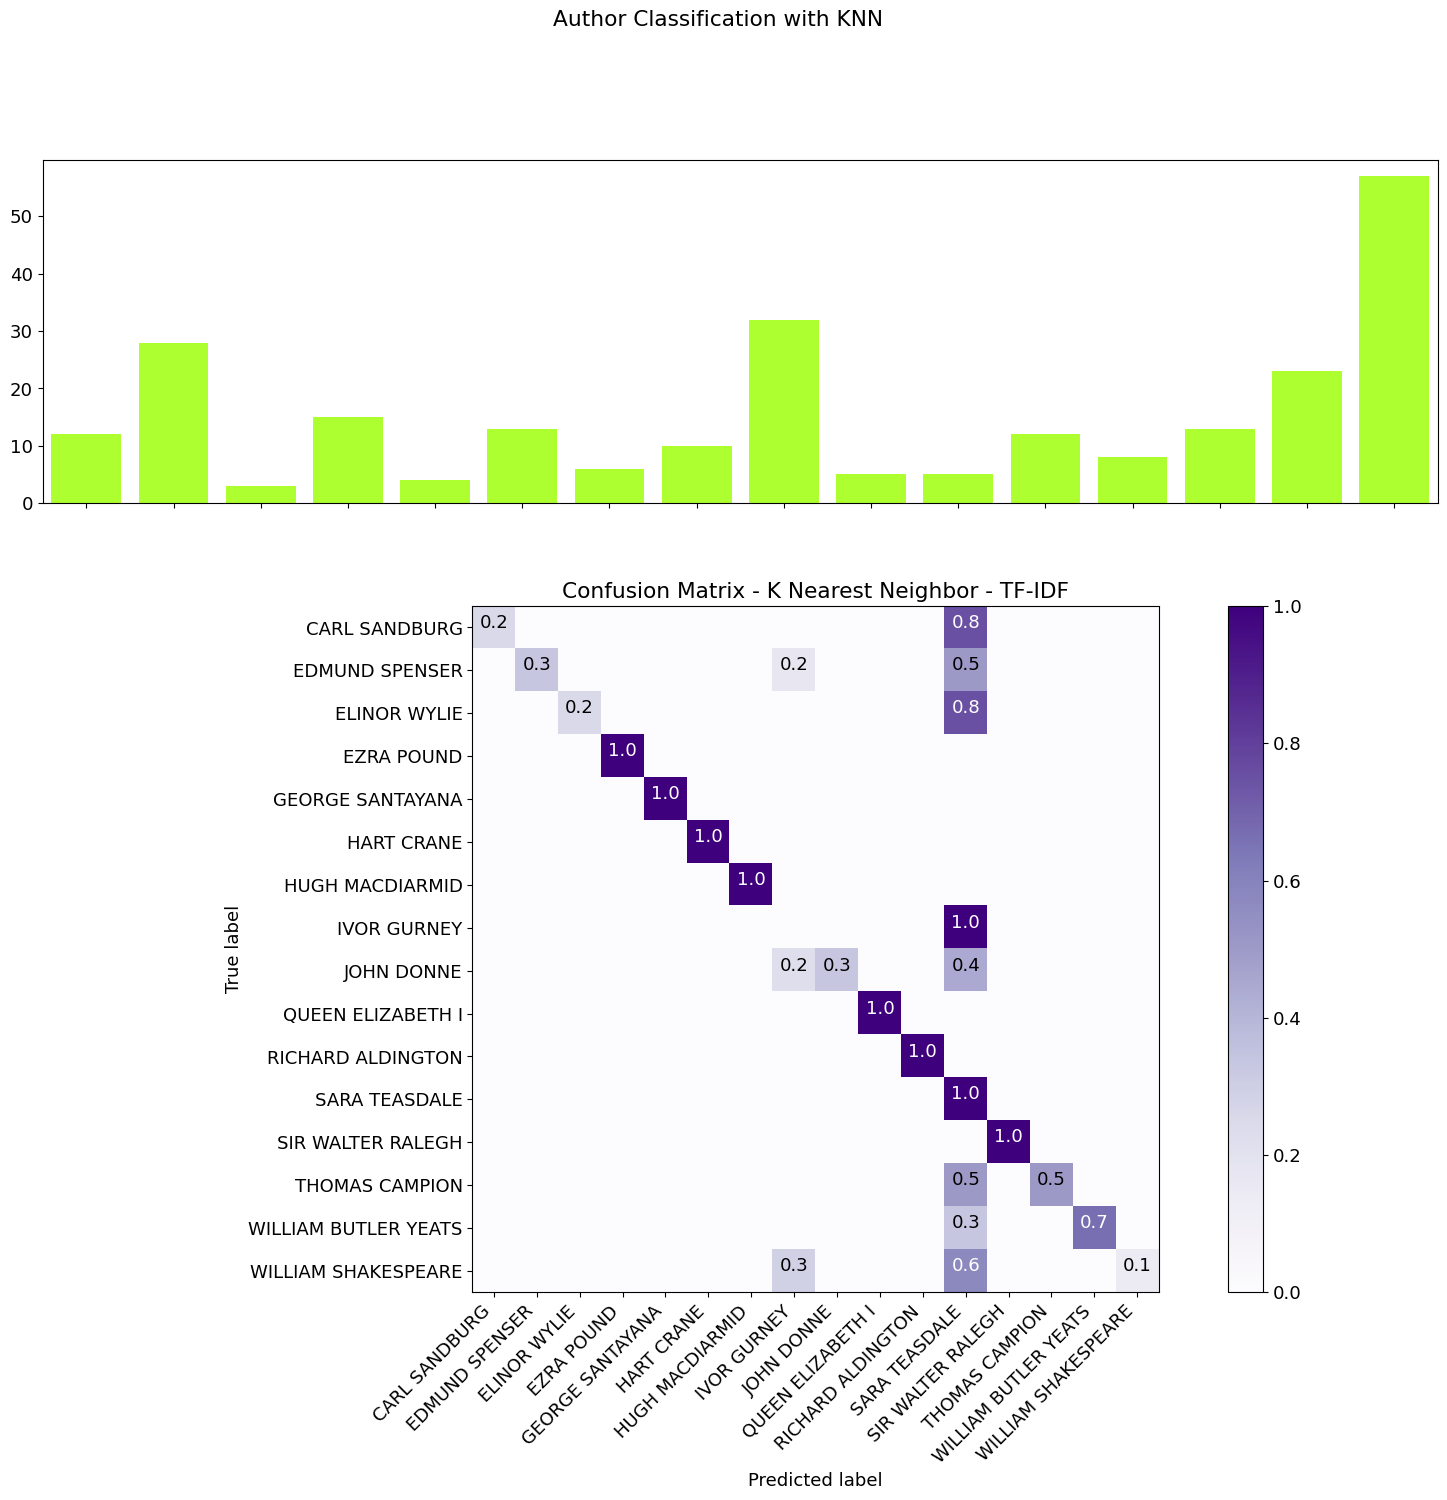

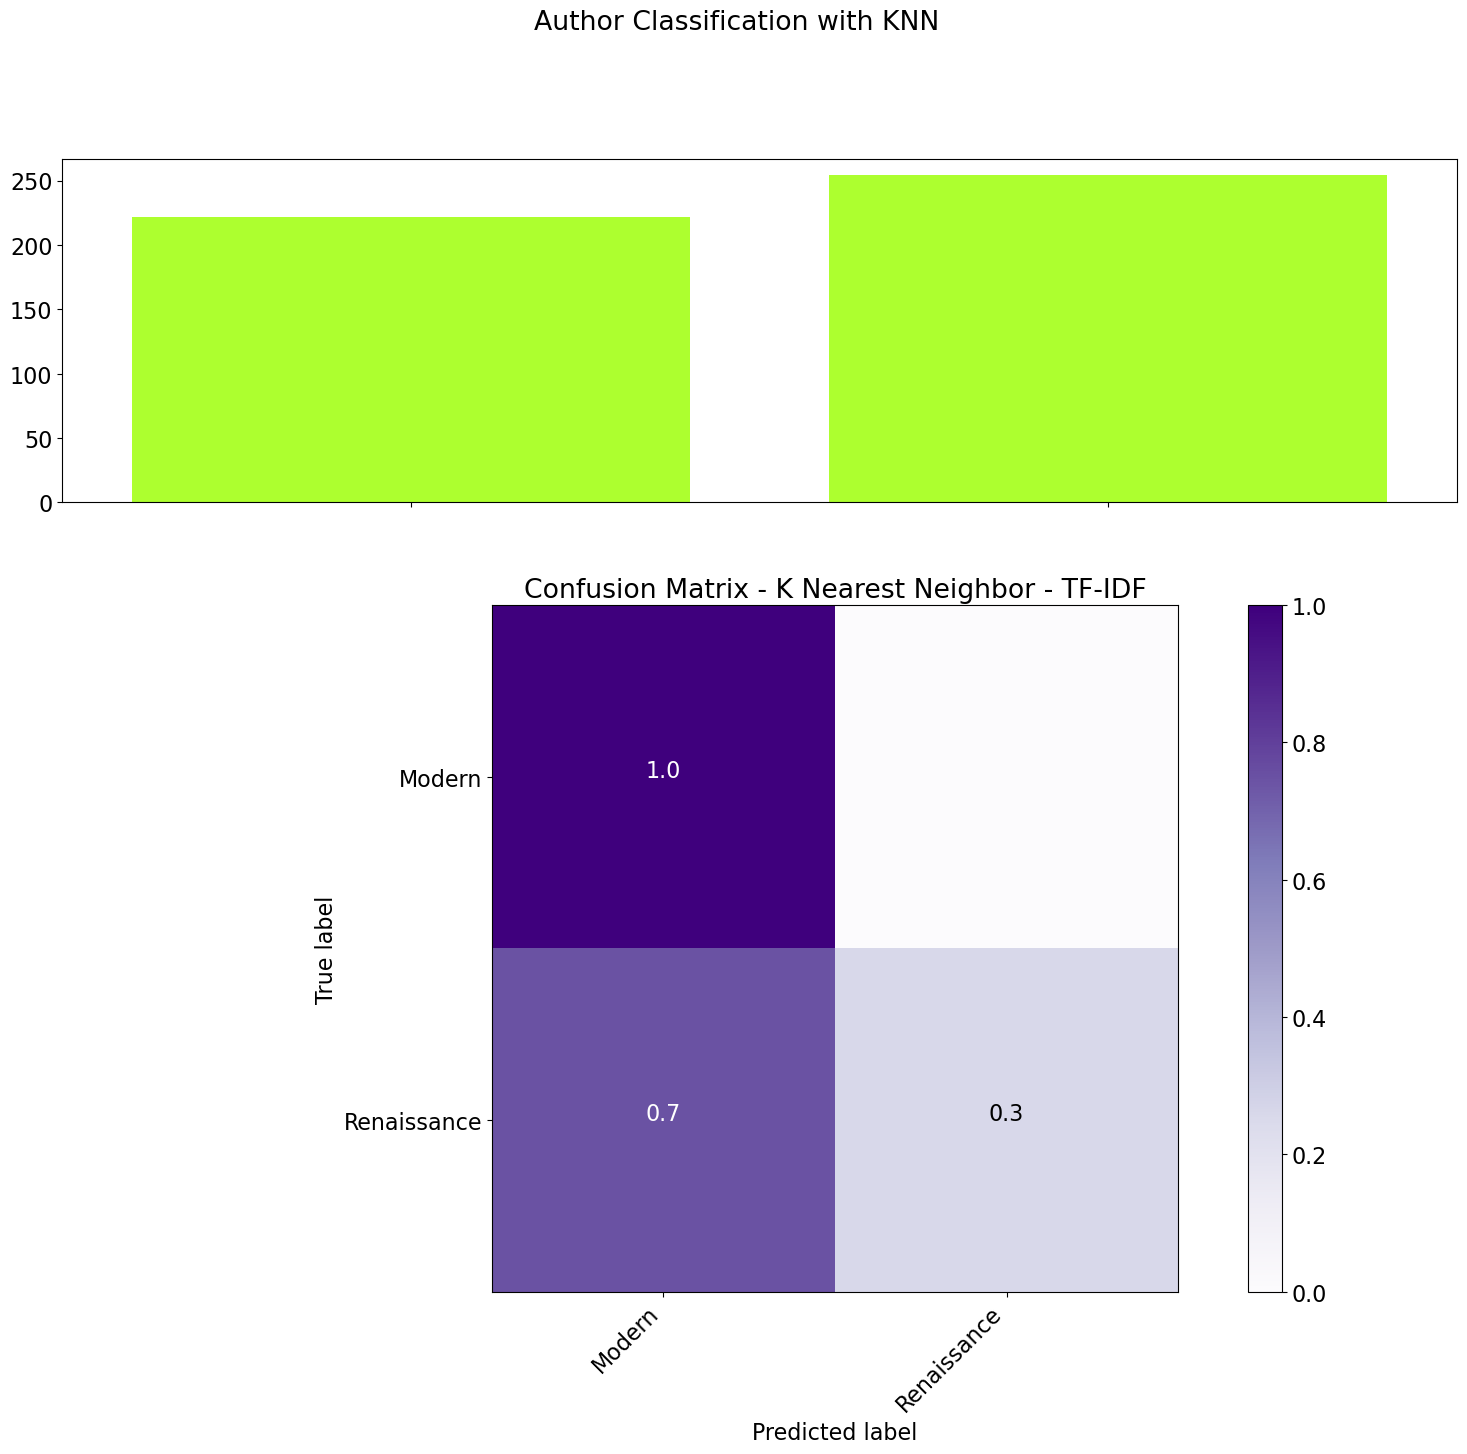

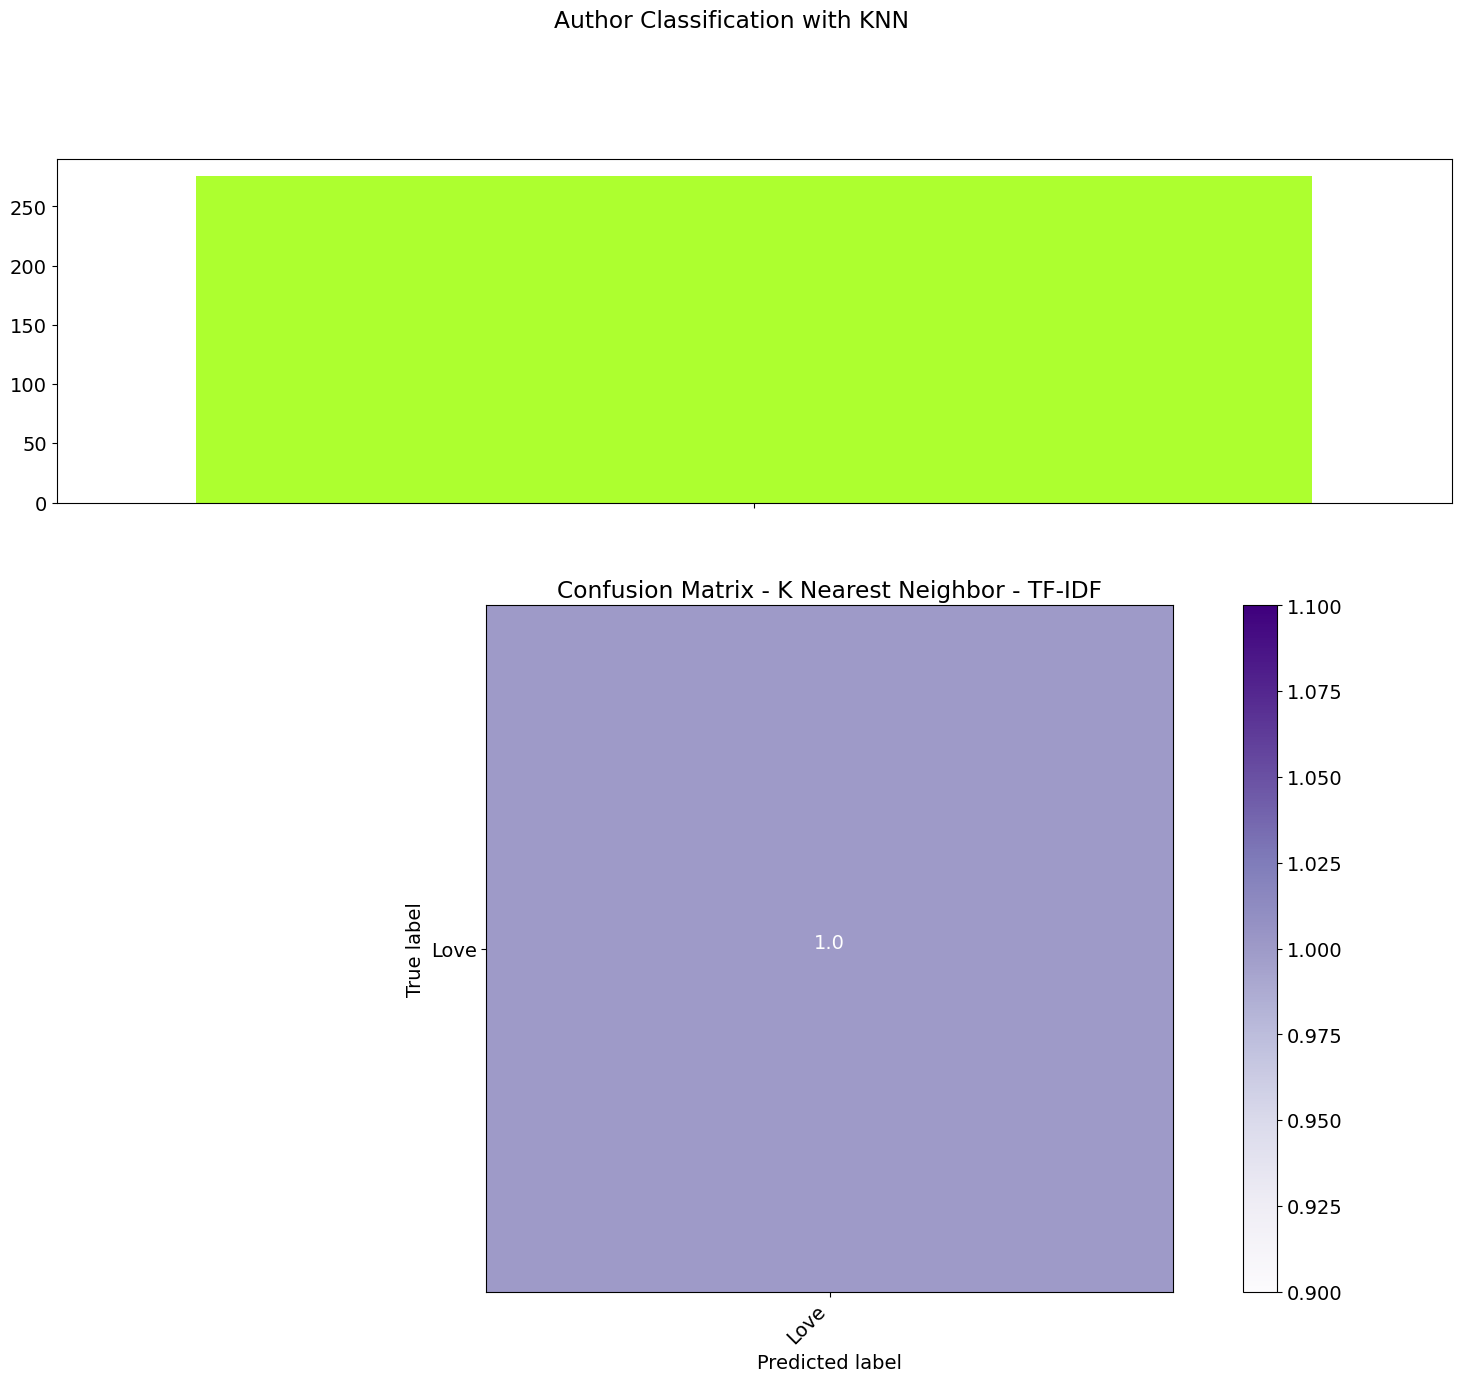

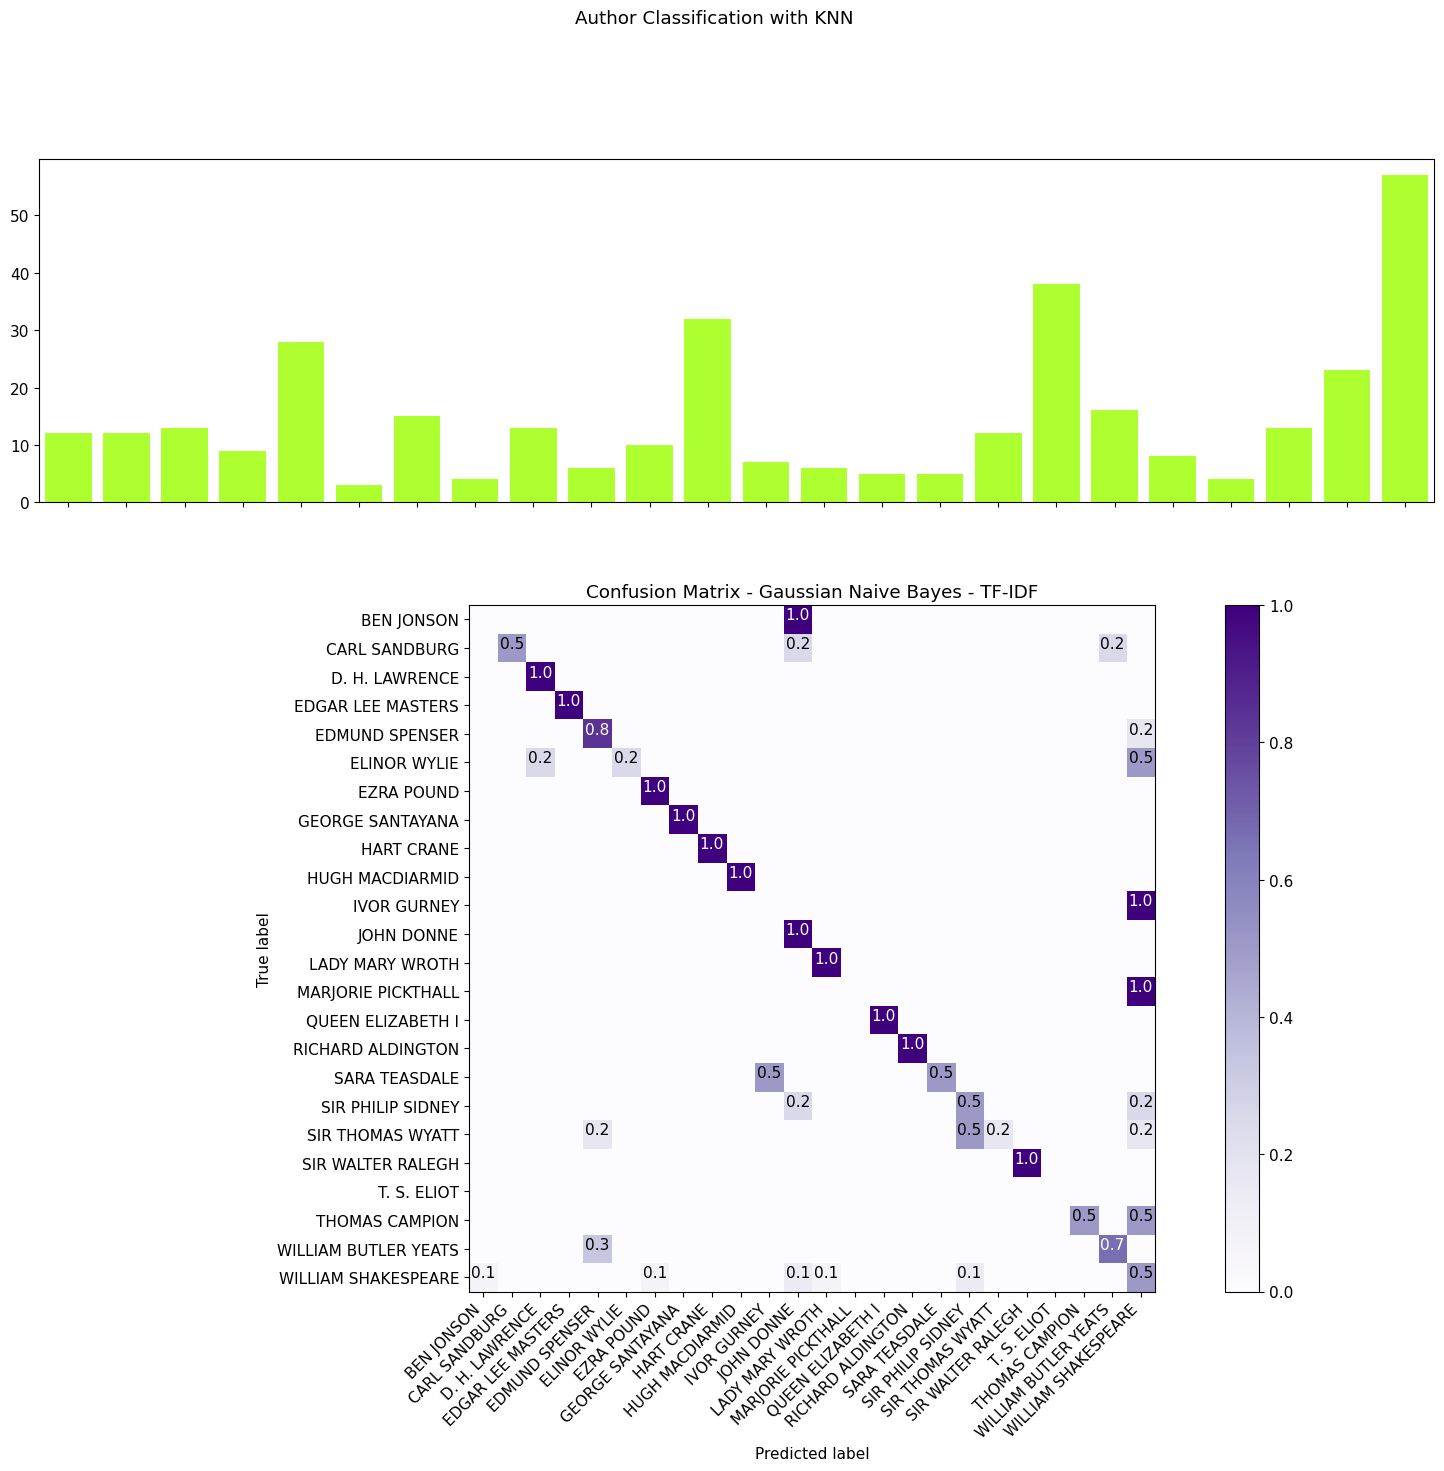

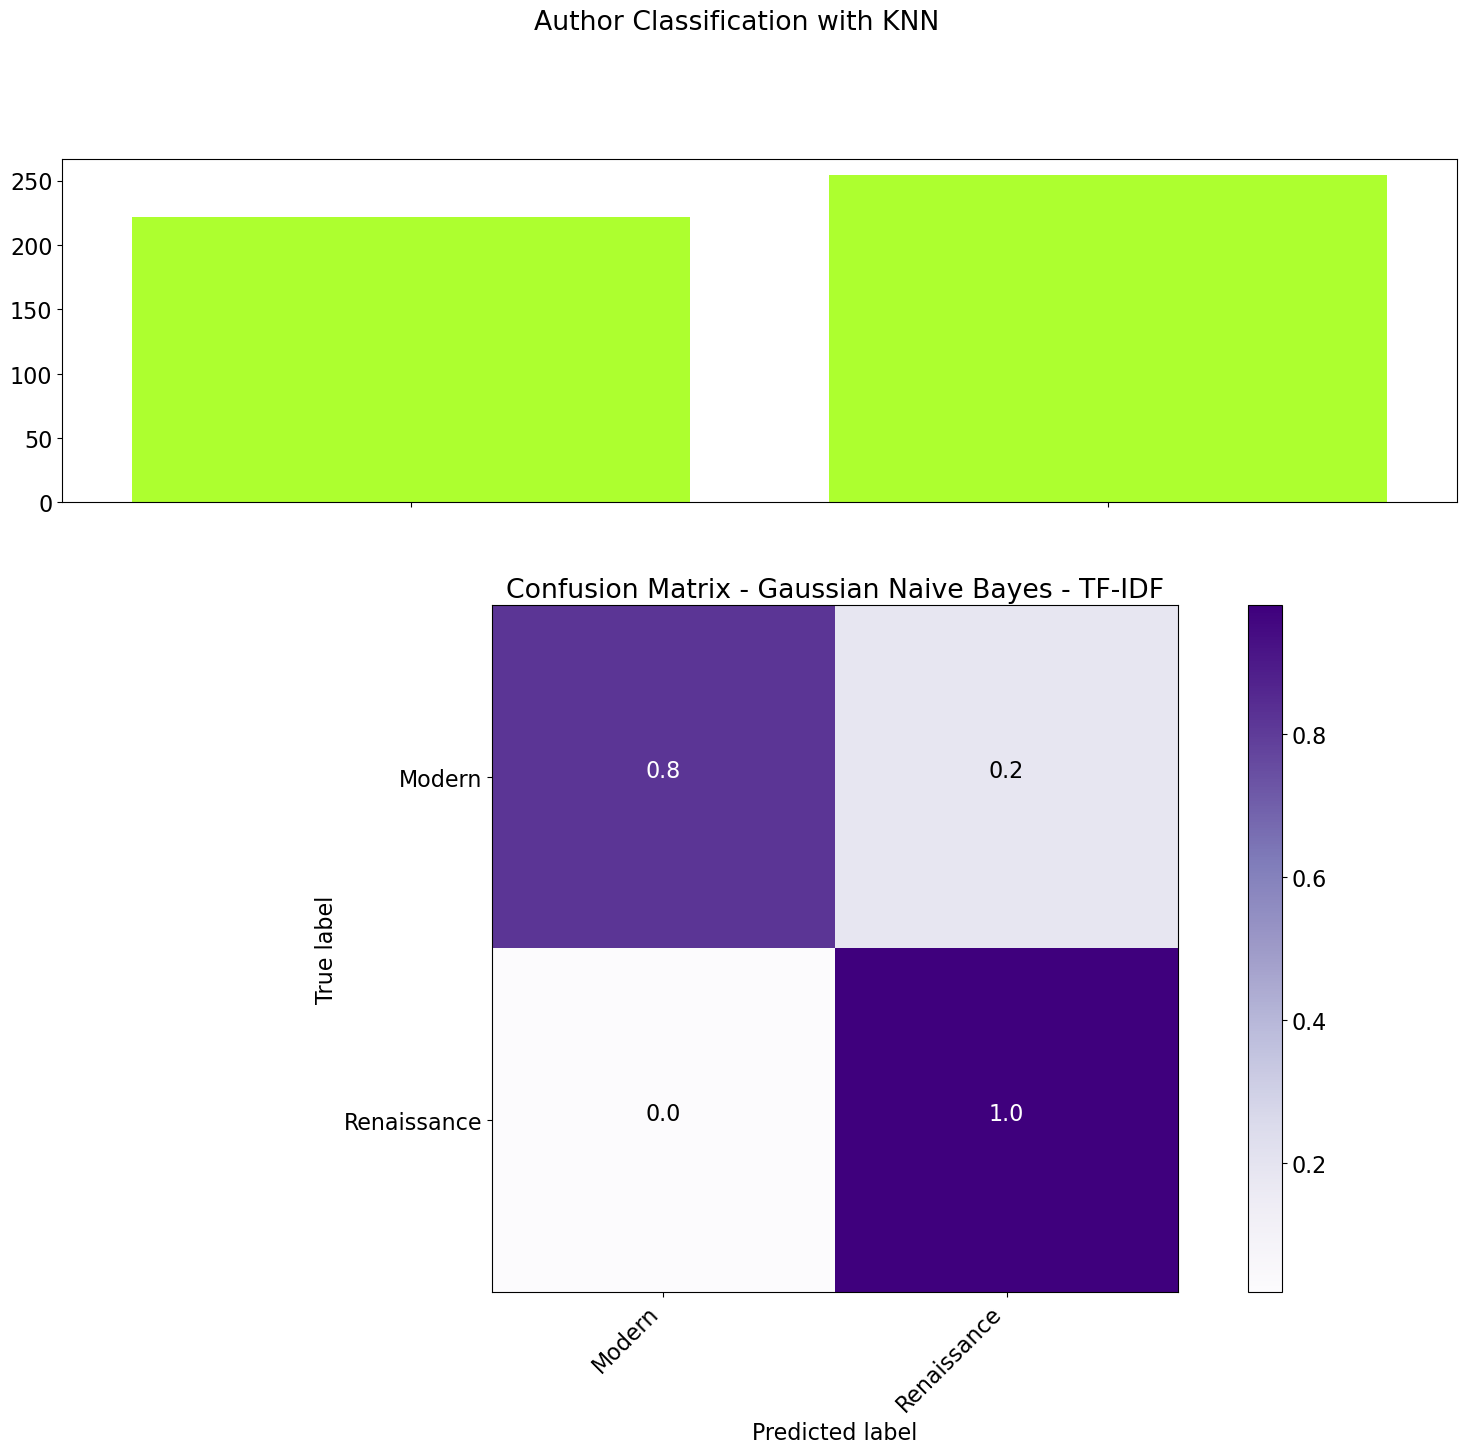

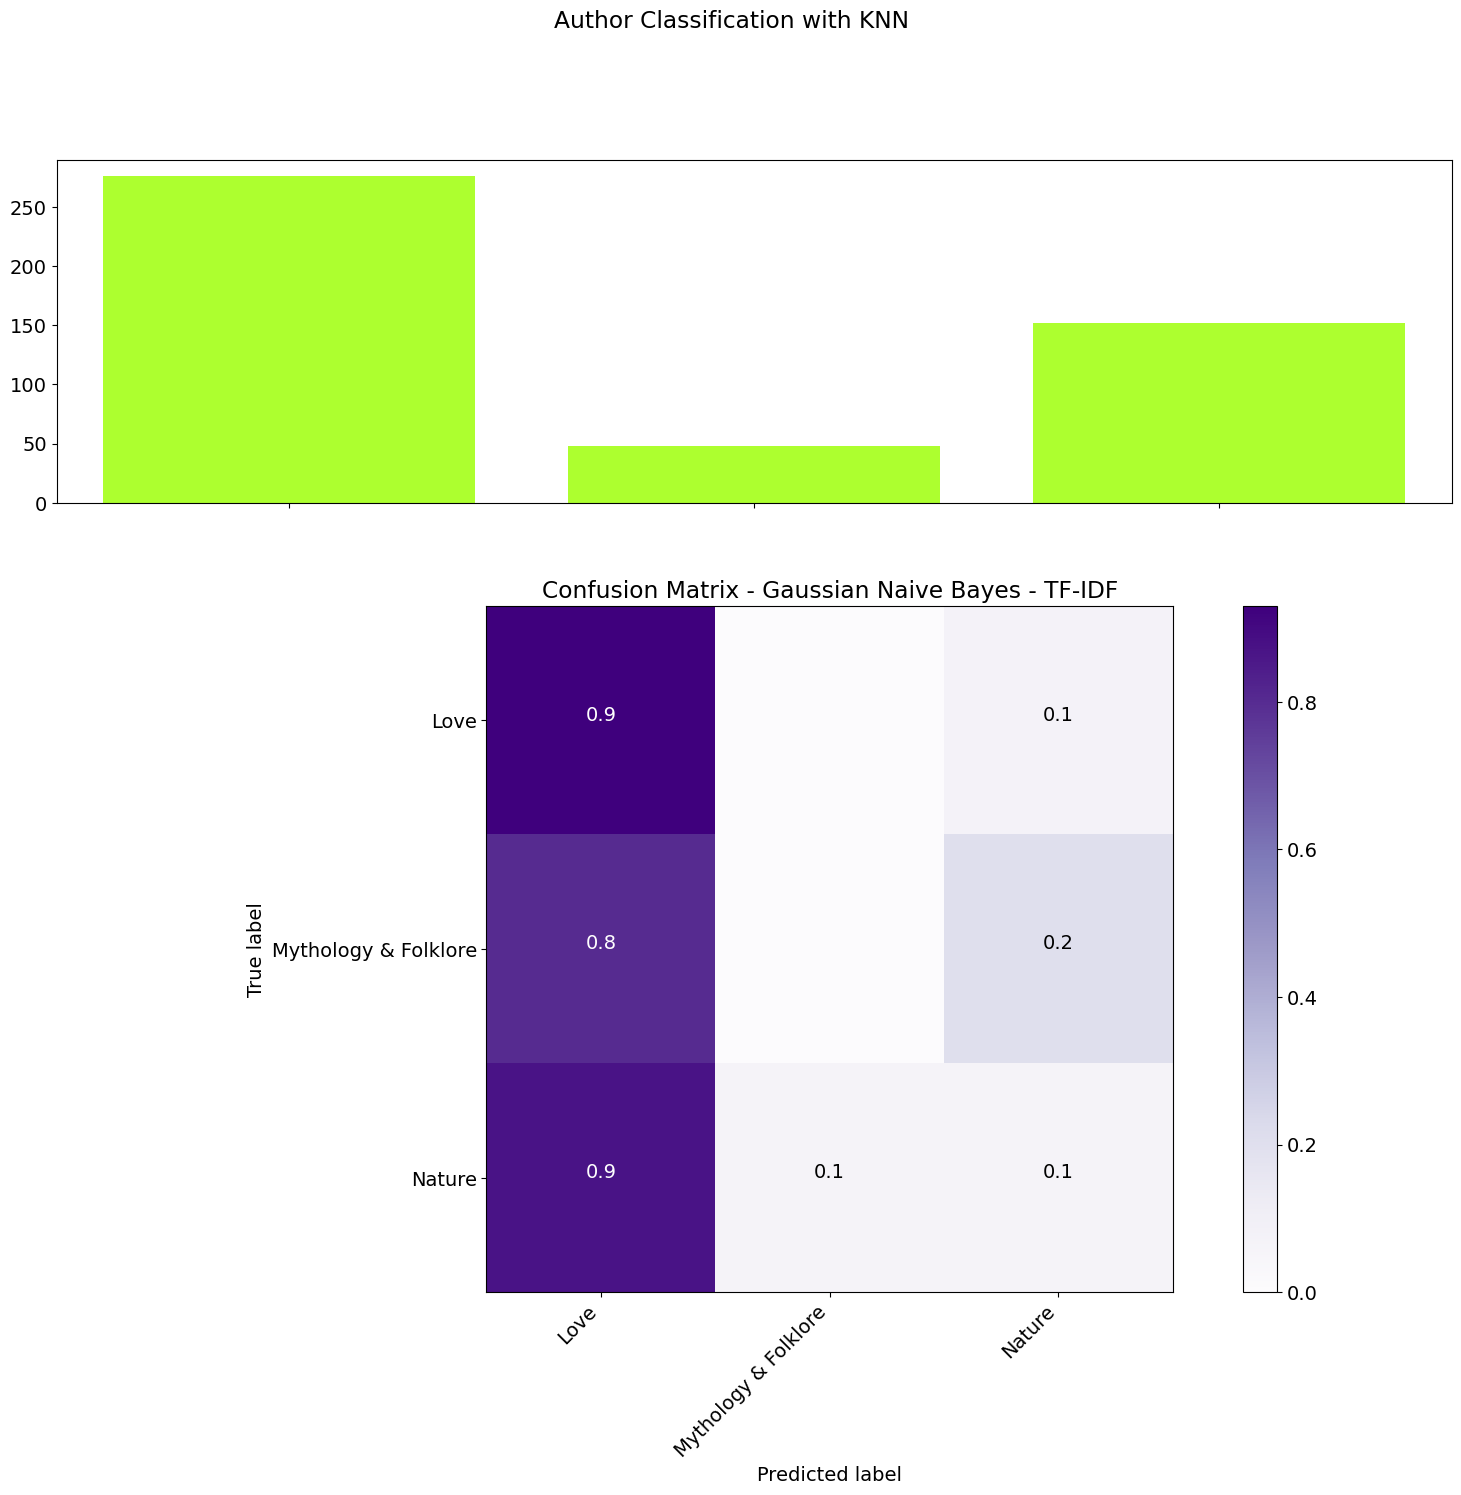

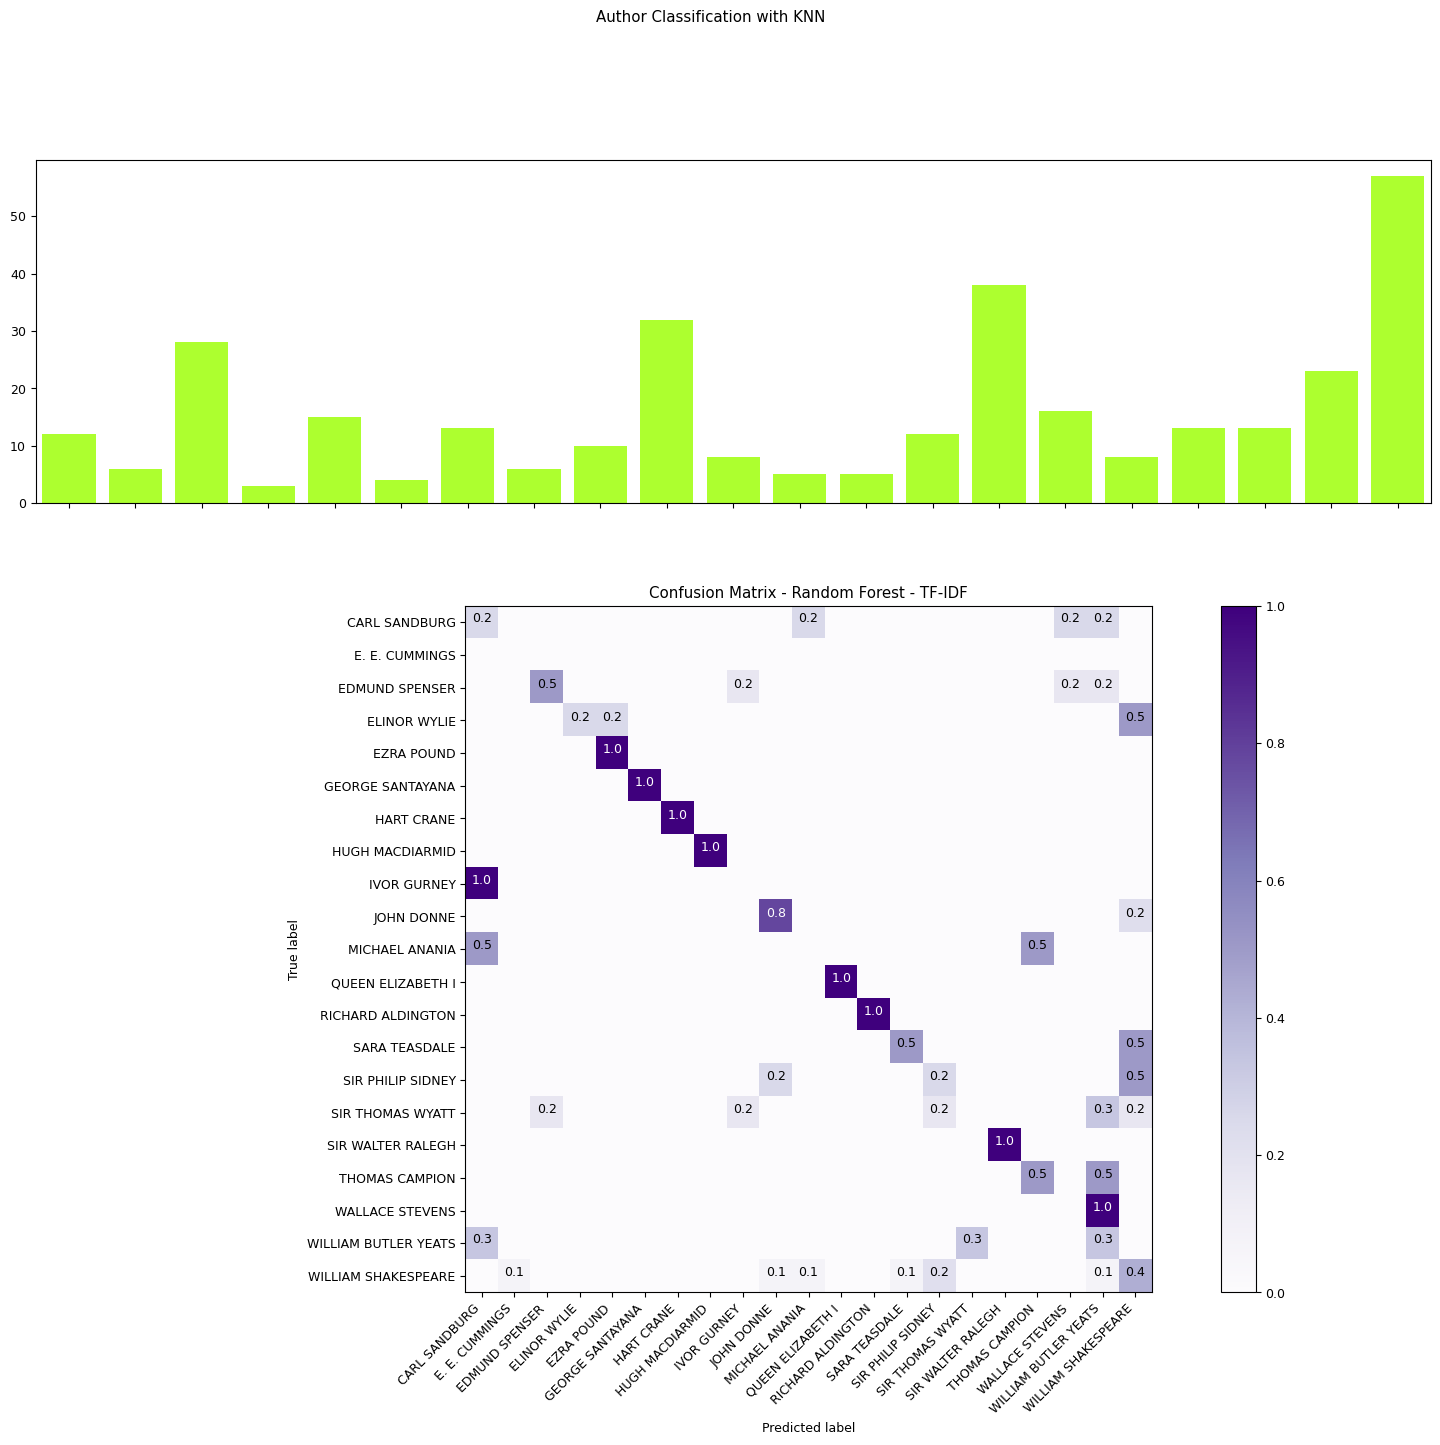

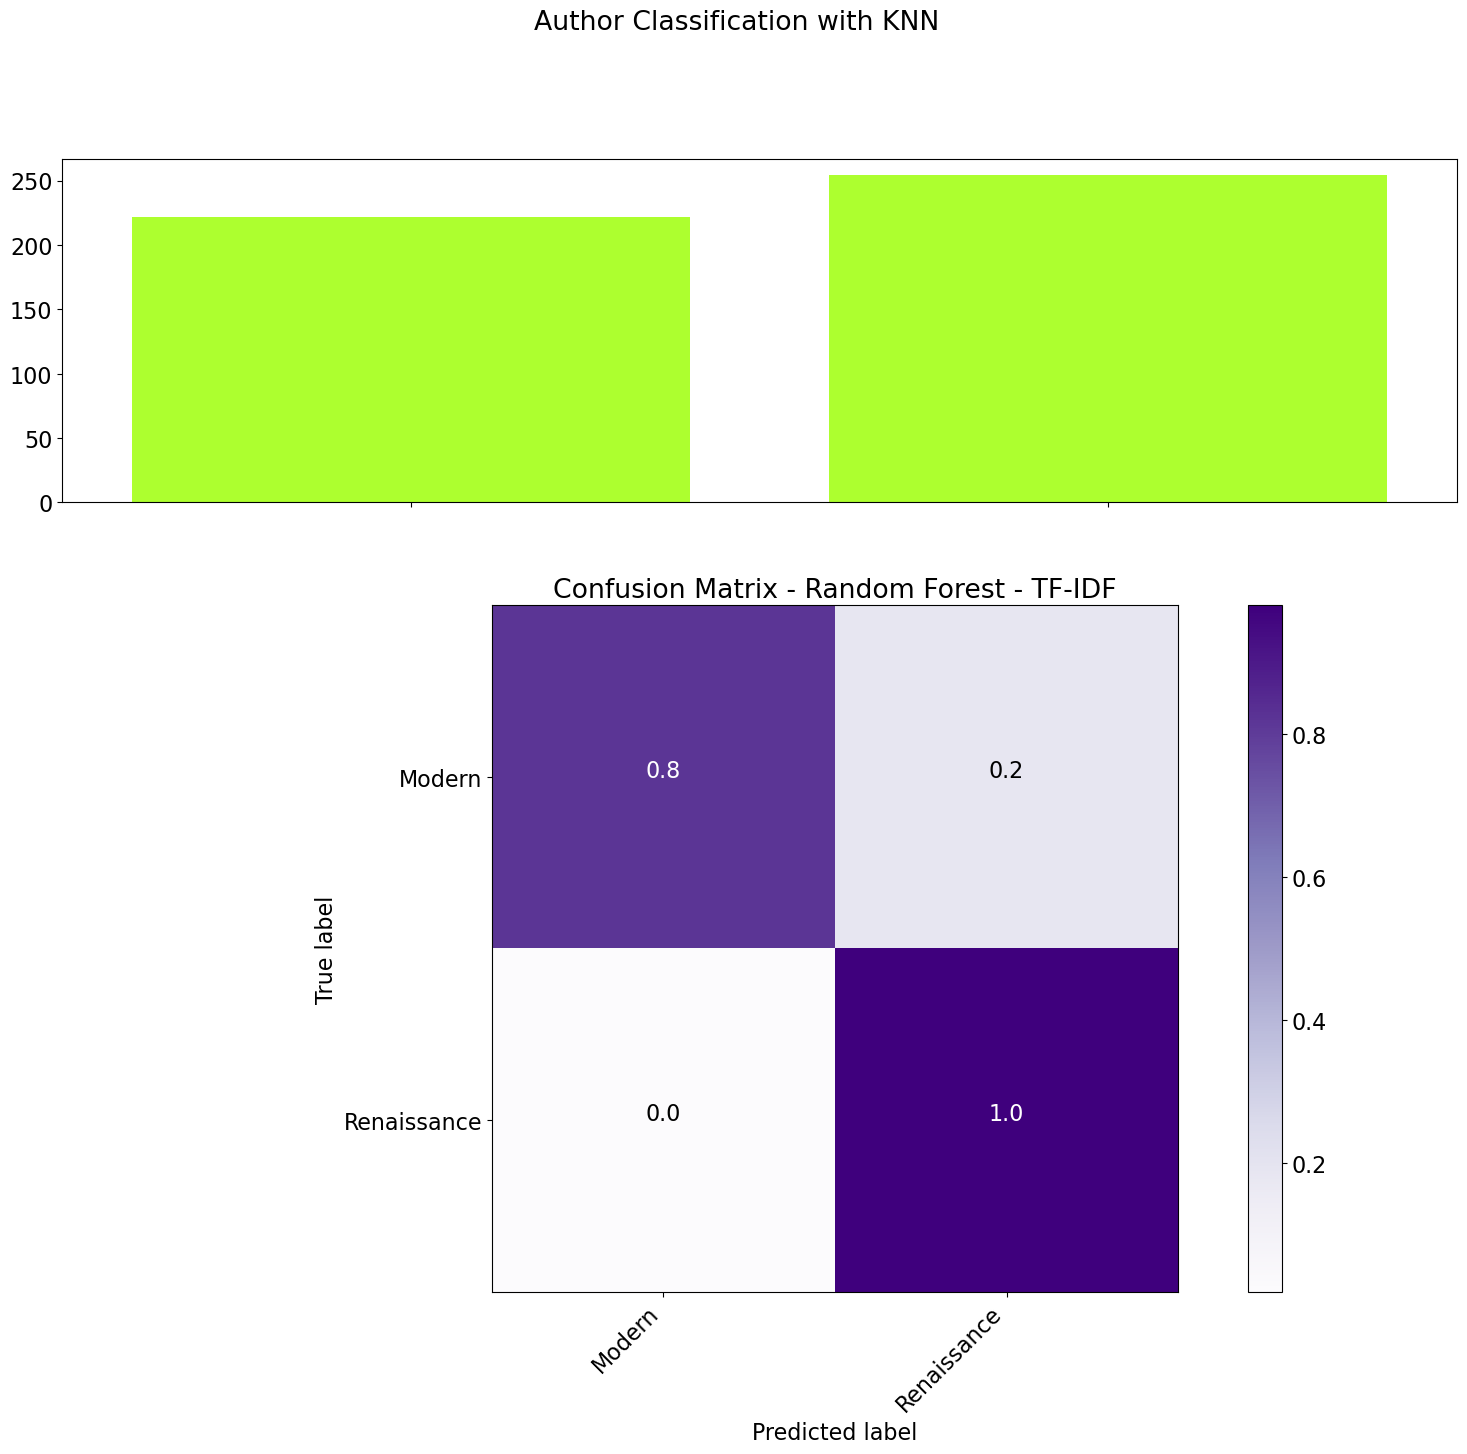

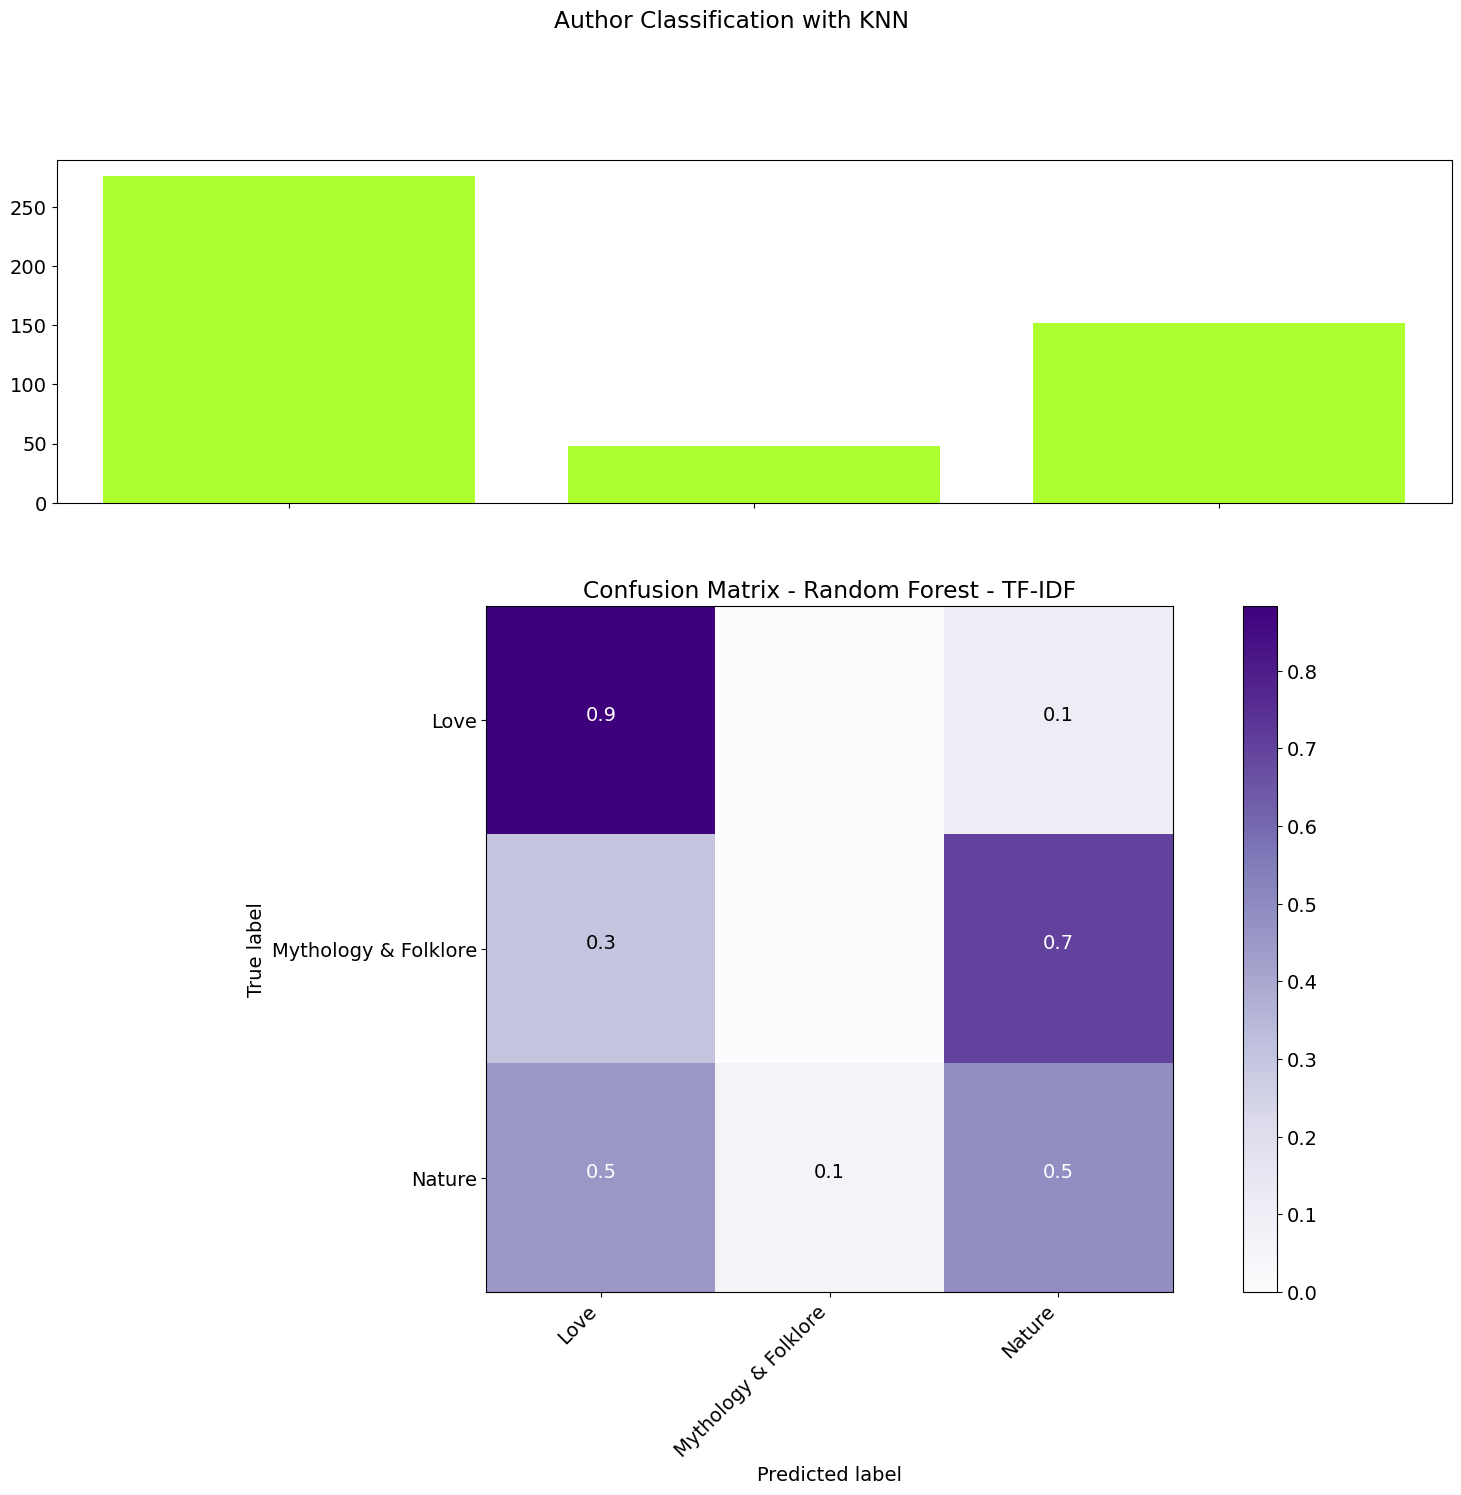

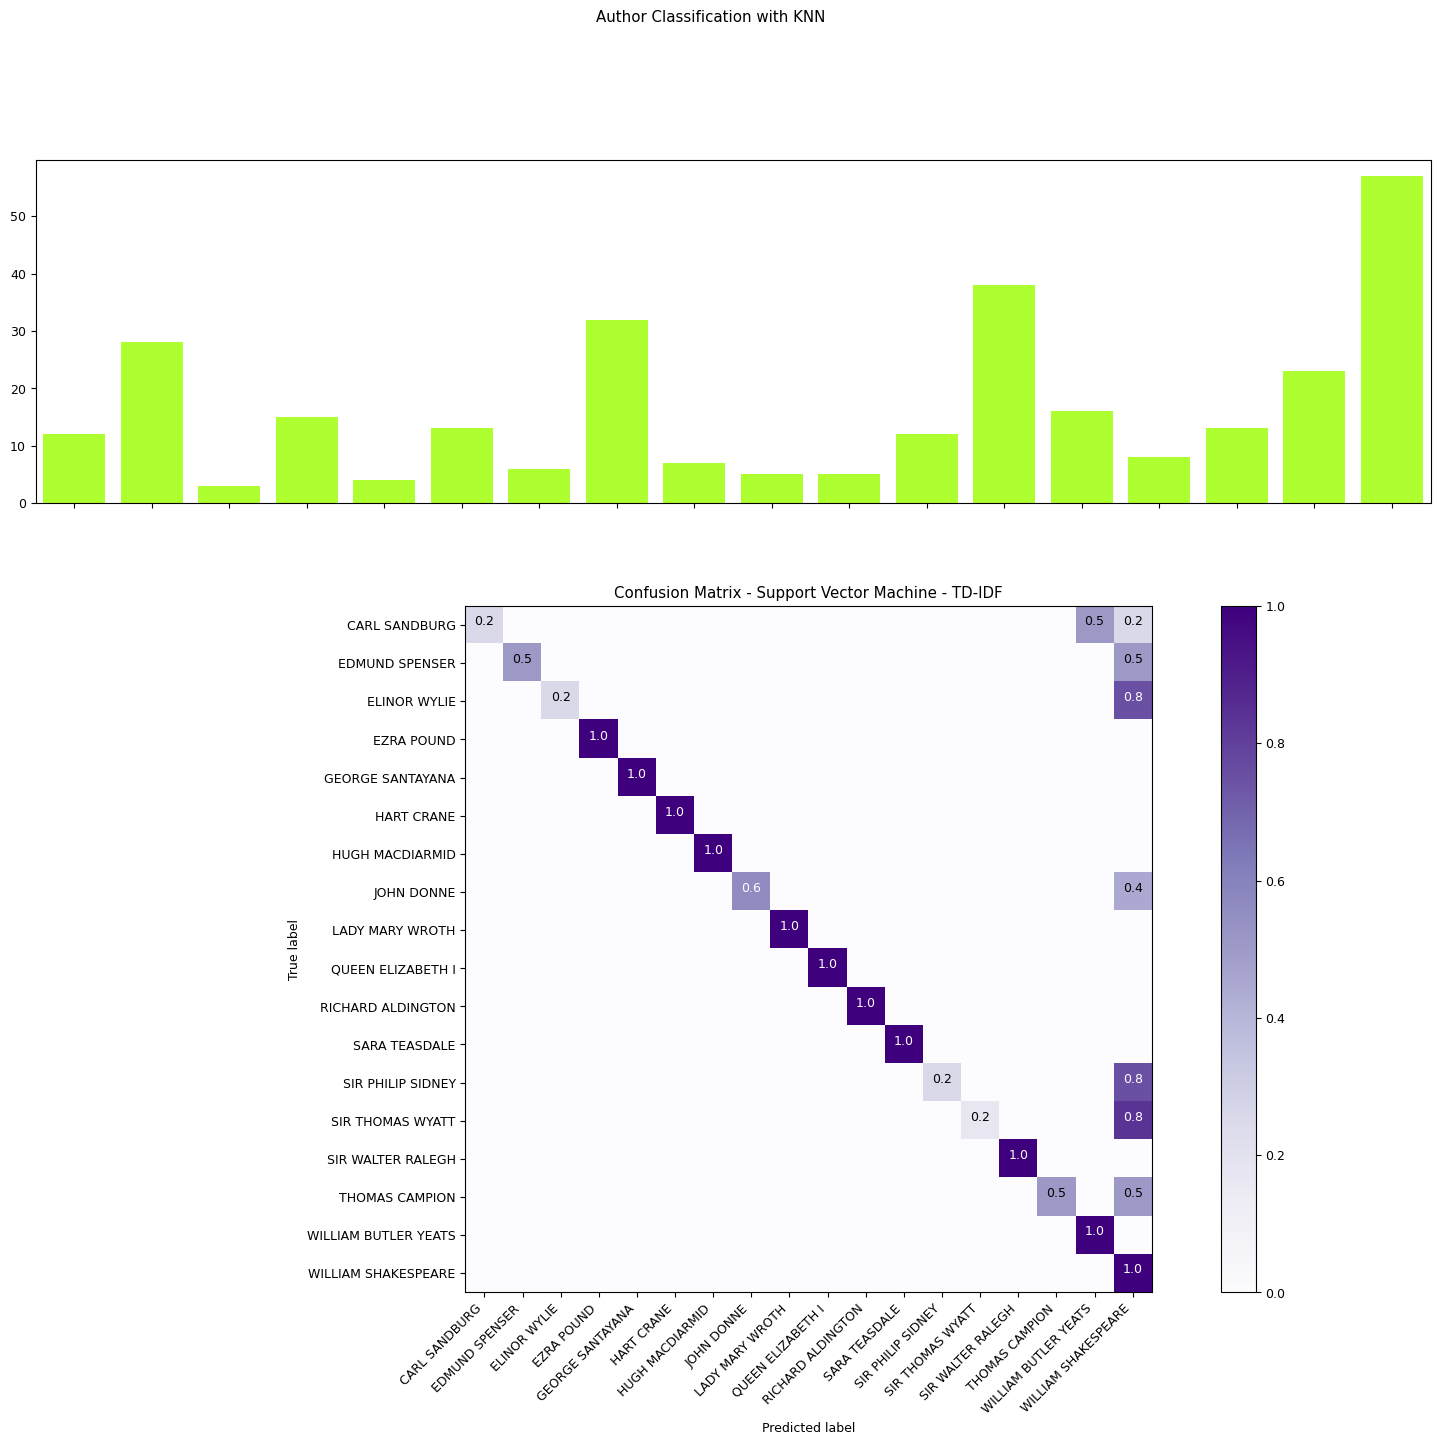

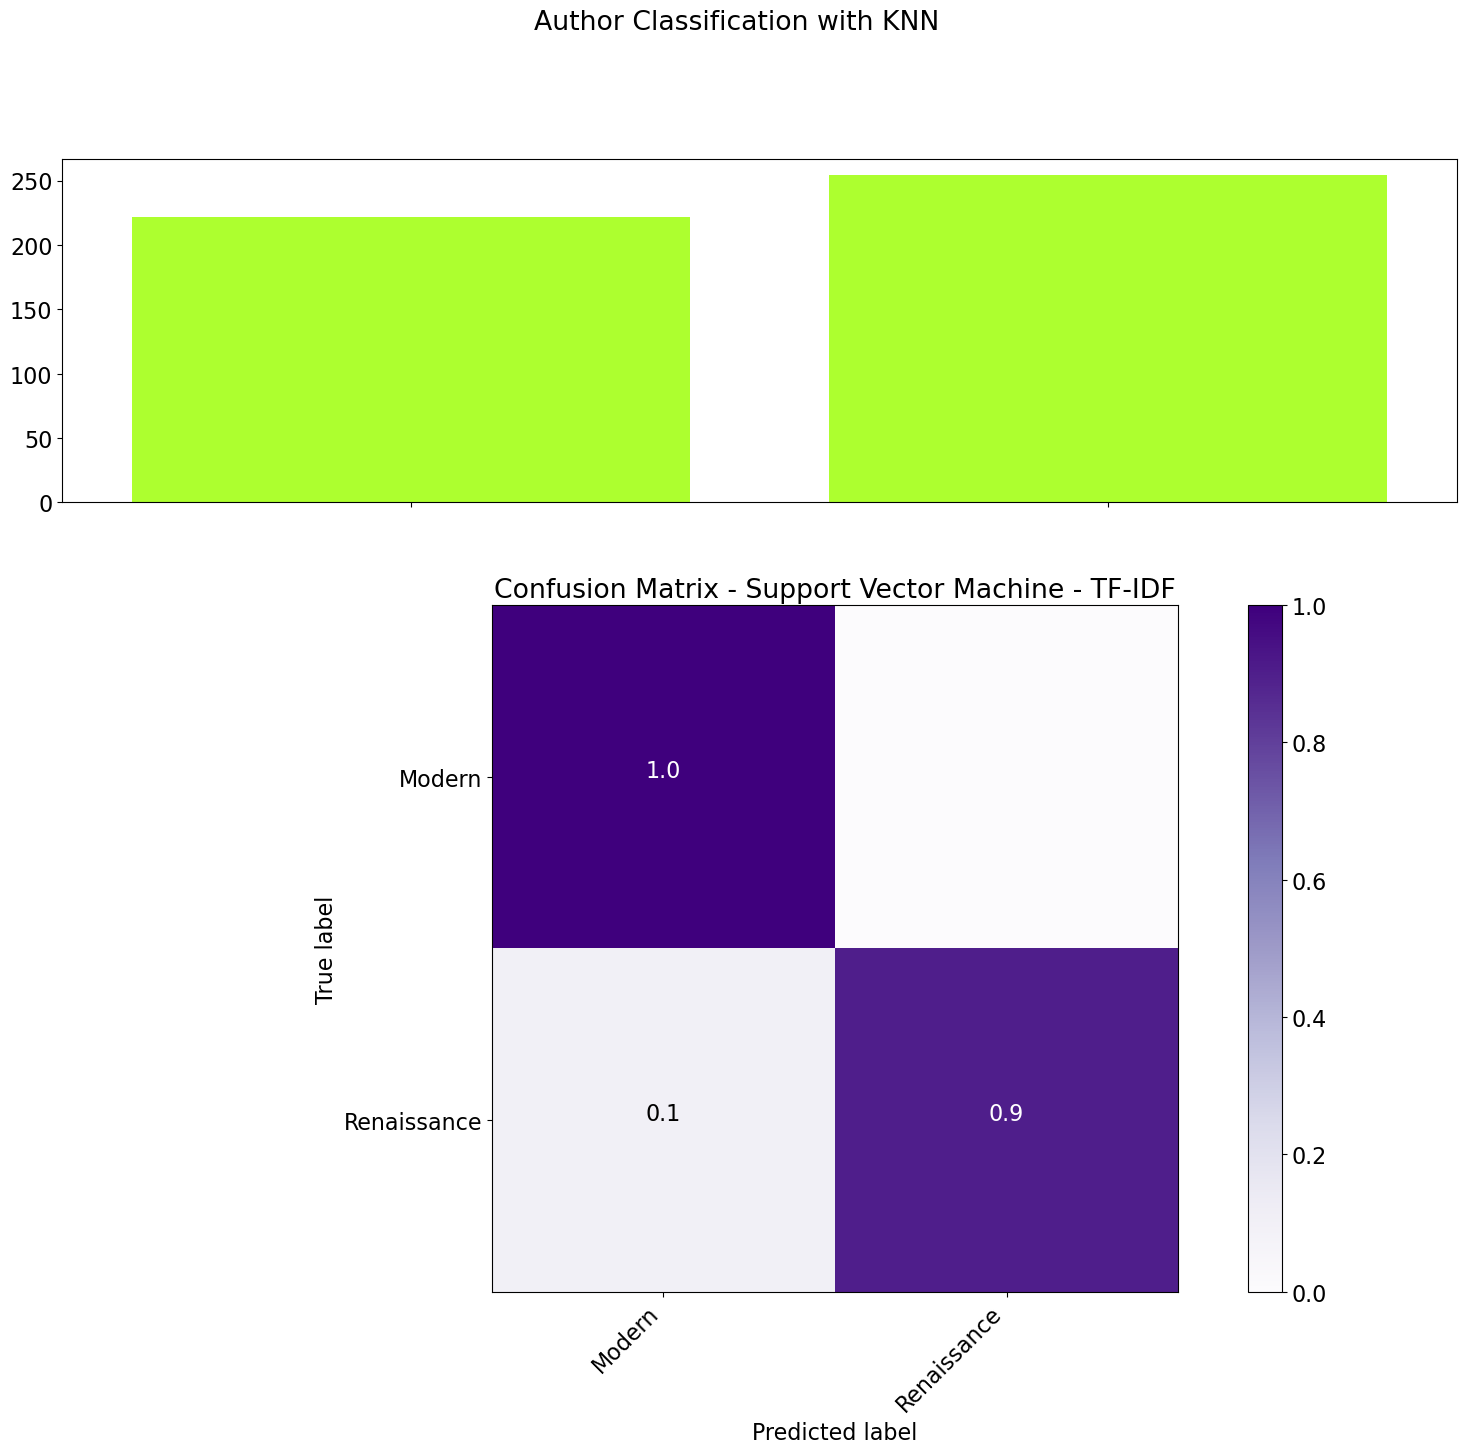

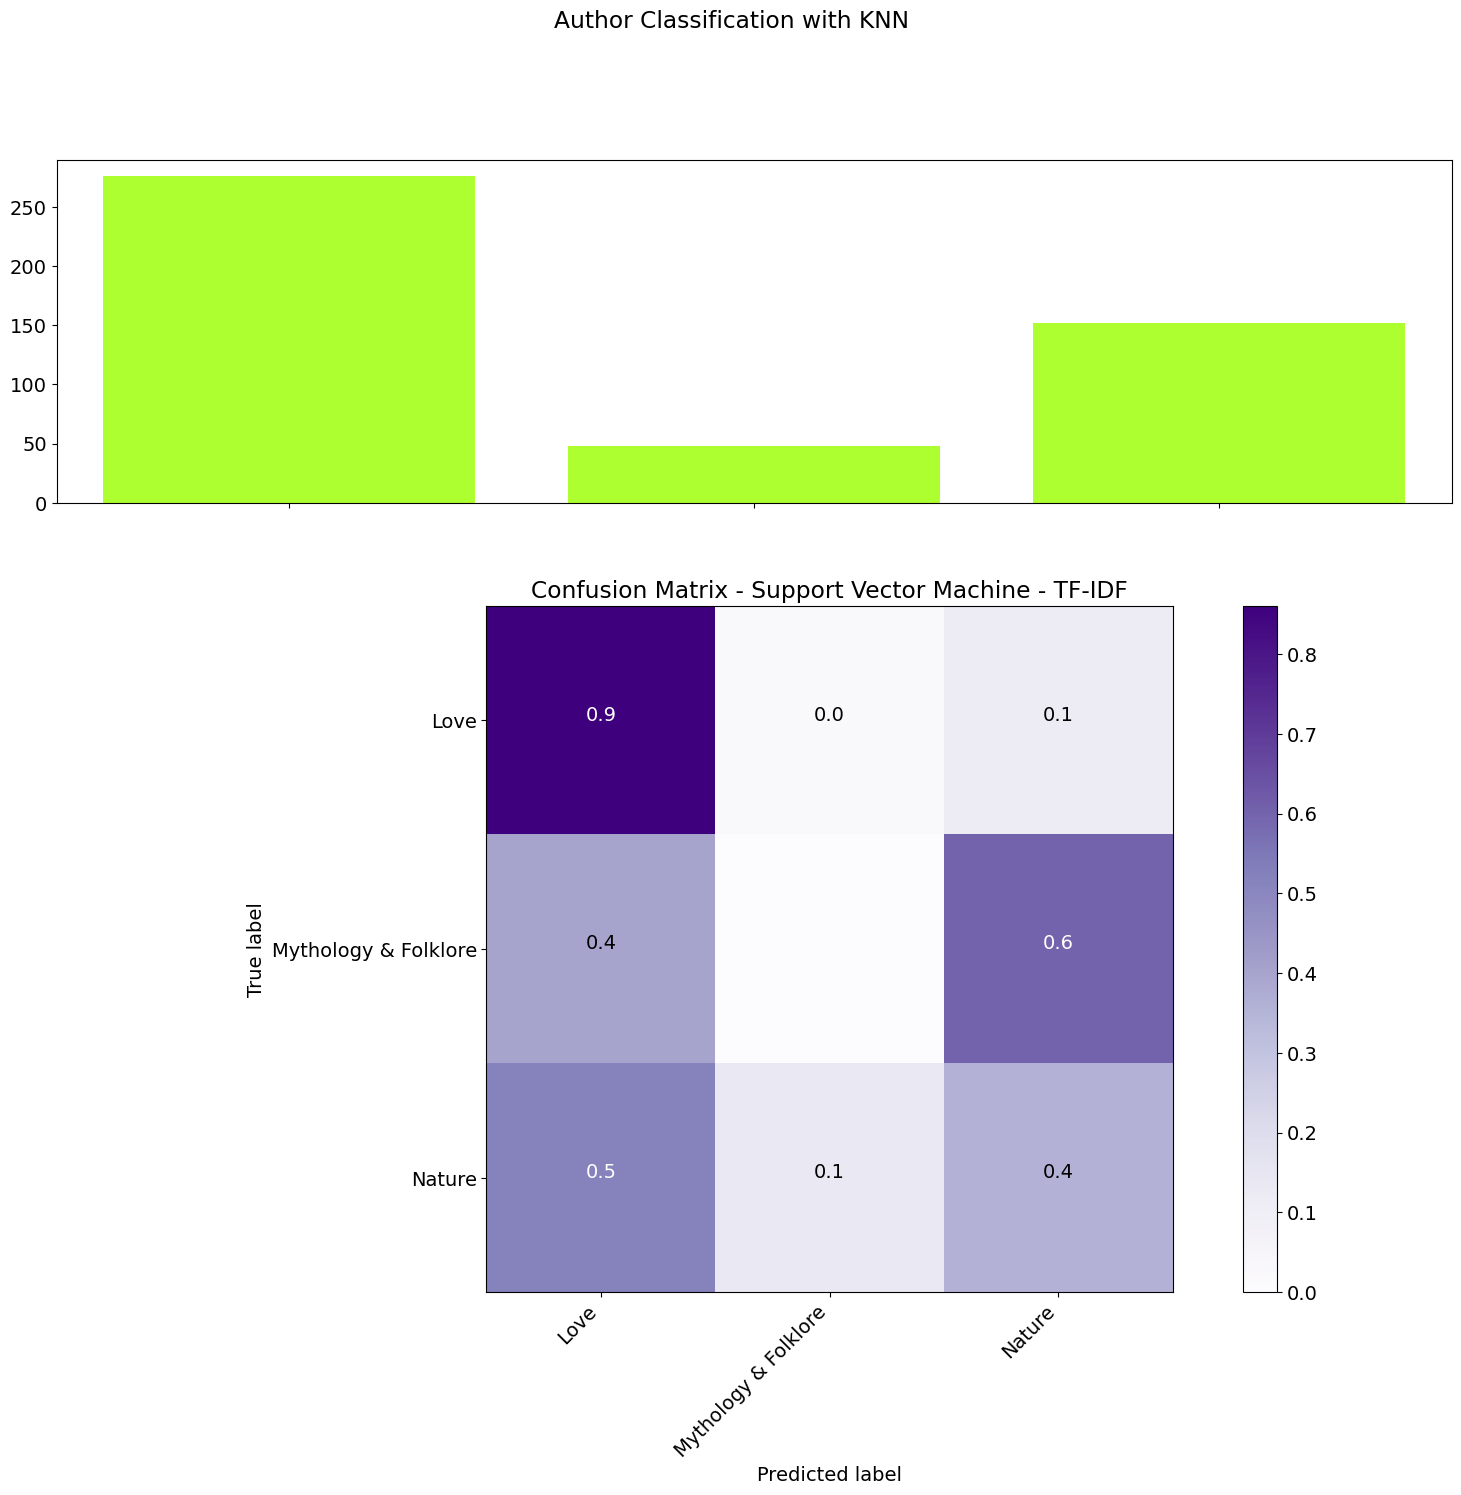

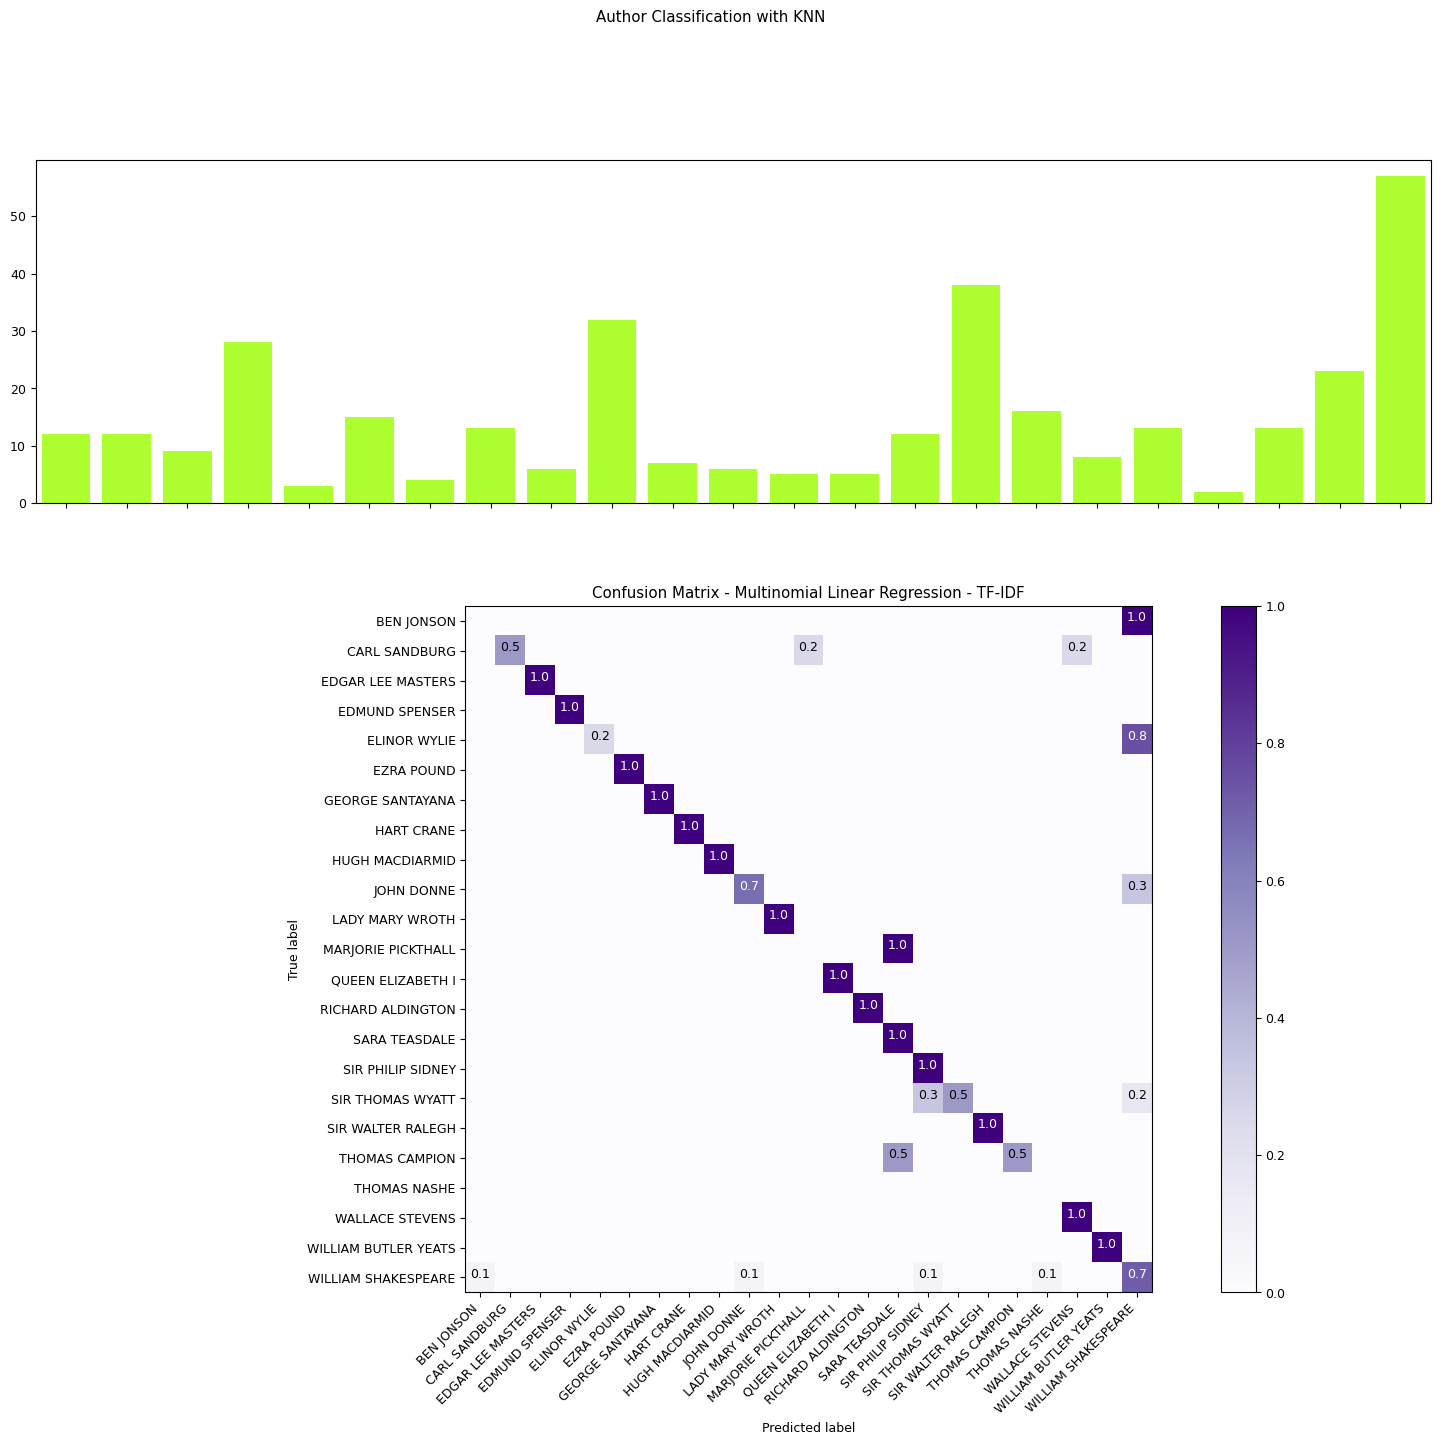

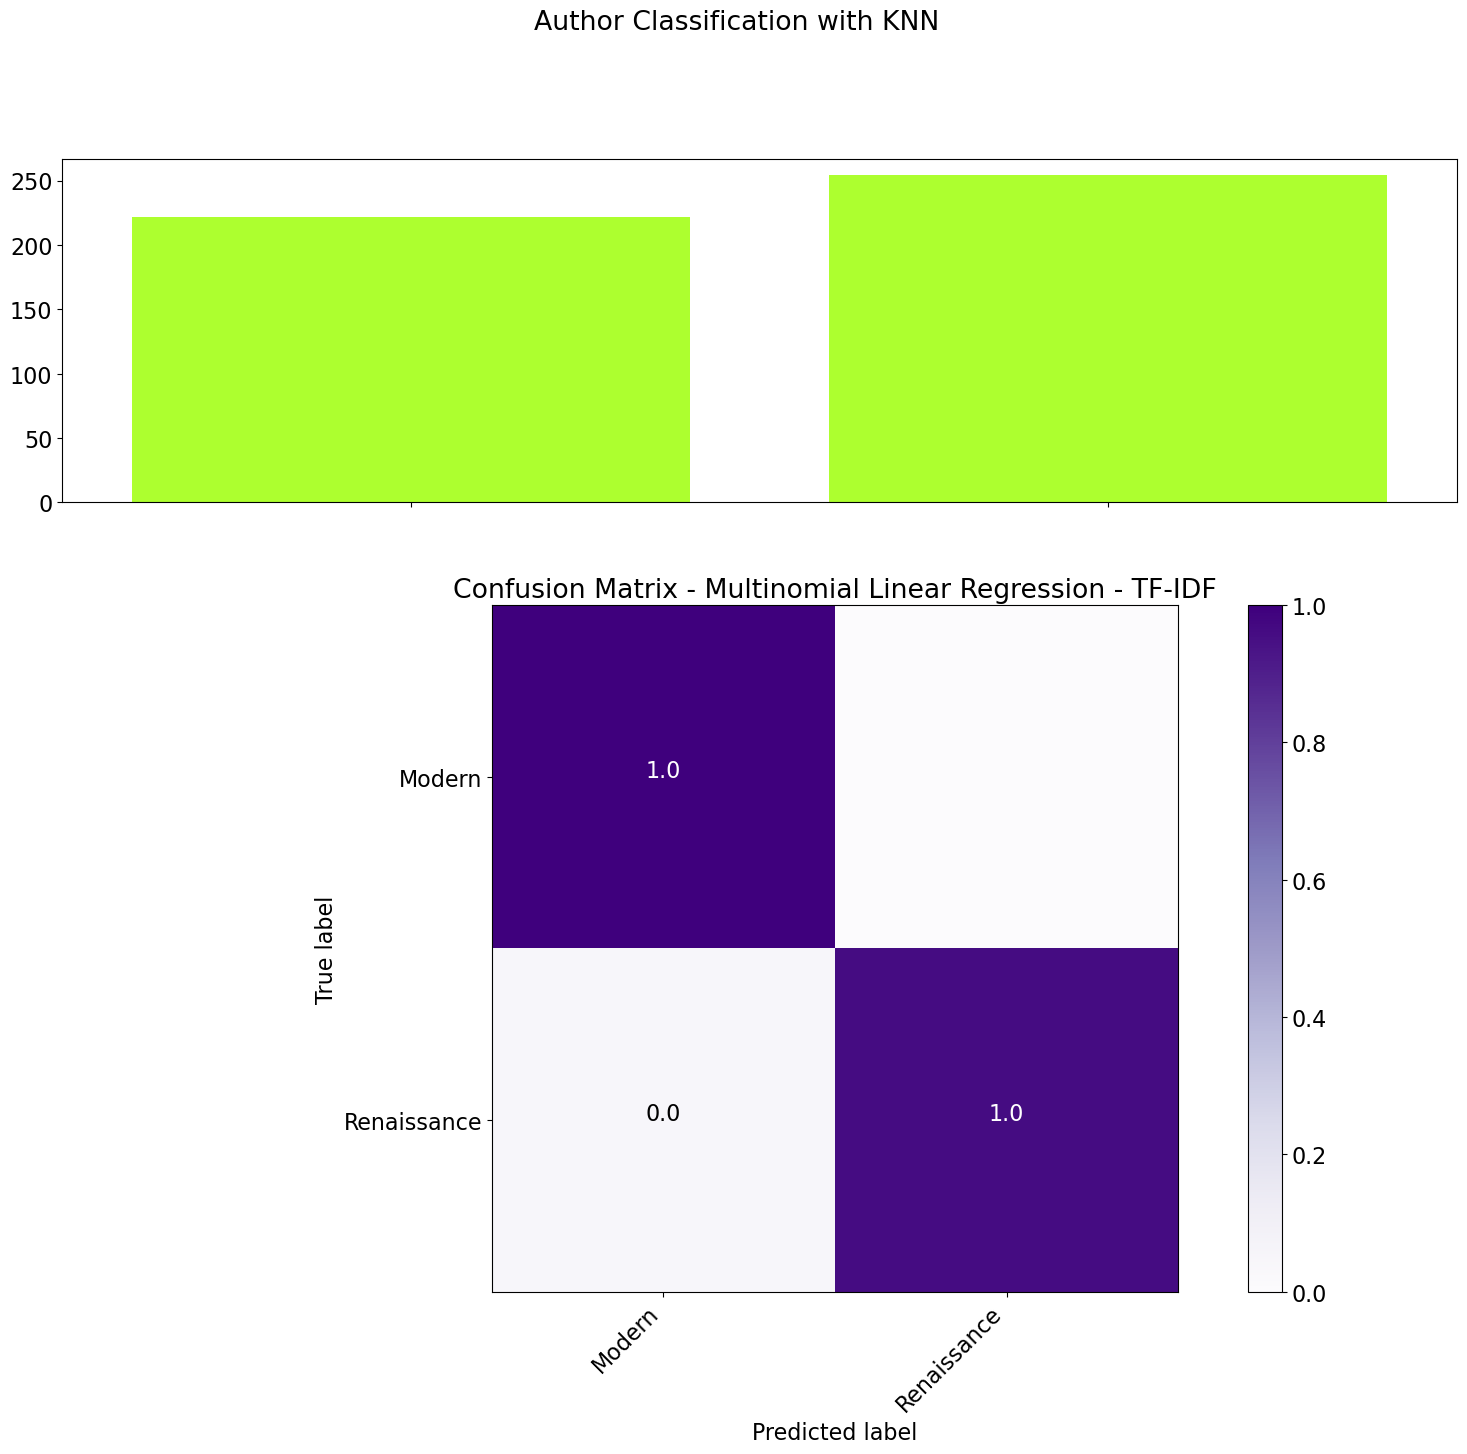

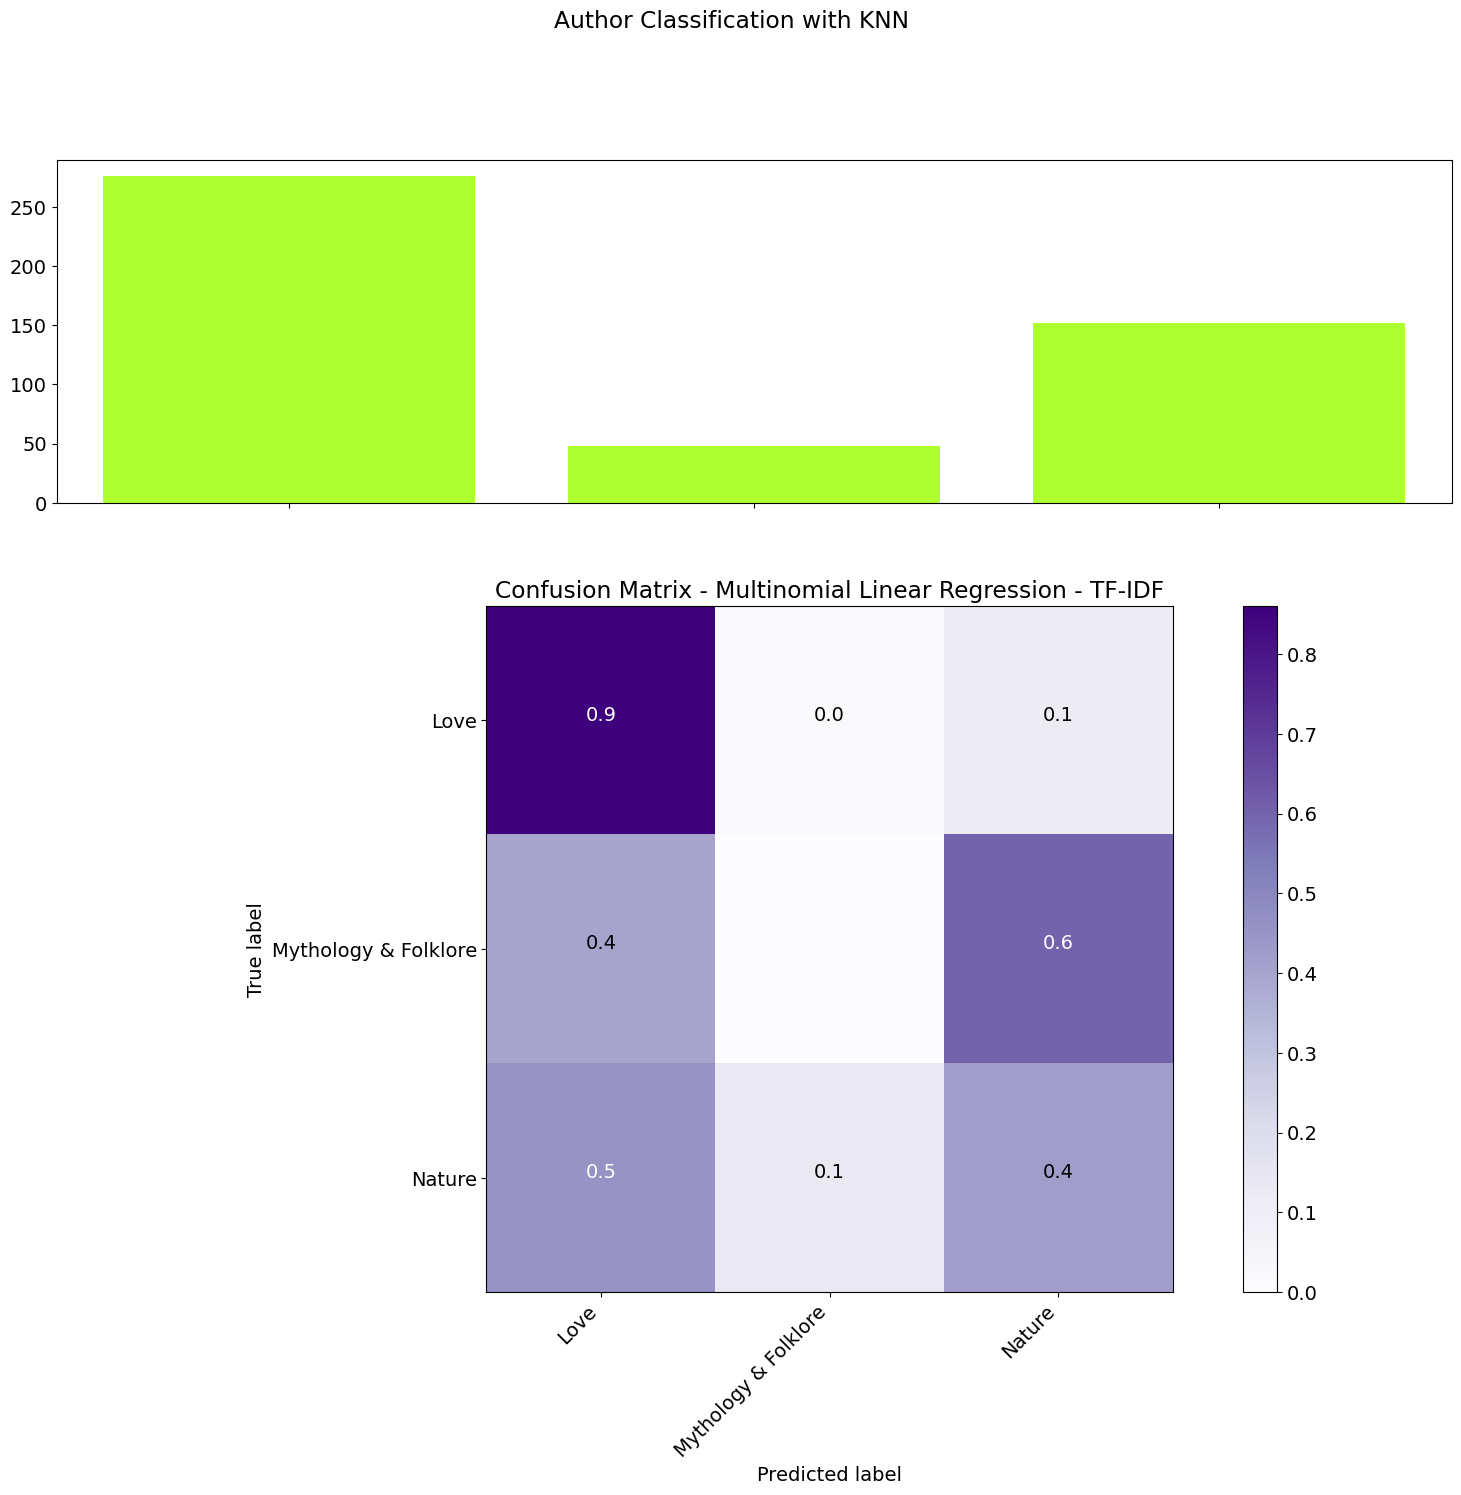

In [22]:
#KNN: 
determine_pred_counts(knn_perform_auth['predicted_labs_tfidf'],knn_perform_era['predicted_labs_tfidf'],knn_perform_sub['predicted_labs_tfidf'])
#AUTHORS (TF-IDF):
conf_mat_knn_auth = construct_conf_mat(auth_test,knn_perform_auth['predicted_labs_tfidf'],all_authors)
plot_confusion_matrix(conf_mat_knn_auth,auth_train,all_authors,"Confusion Matrix - K Nearest Neighbor - TF-IDF",True,all_authors_freq,"KNN_confmat_authors_tfidf",13)
#ERA (TF-IDF):
conf_mat_knn_era = construct_conf_mat(era_test,knn_perform_era['predicted_labs_tfidf'],all_eras)
plot_confusion_matrix(conf_mat_knn_era,era_train,all_eras,"Confusion Matrix - K Nearest Neighbor - TF-IDF",True,all_eras_freq,"KNN_confmat_eras_tfidf",16)
#SUBJECT (TF-IDF):
conf_mat_knn_sub = construct_conf_mat(sub_test,knn_perform_sub['predicted_labs_tfidf'],all_subjects)
plot_confusion_matrix(conf_mat_knn_sub,sub_train,all_subjects,"Confusion Matrix - K Nearest Neighbor - TF-IDF",True,all_subjects_freq,"KNN_confmat_subjects_tfidf",14)



#gNB:
determine_pred_counts(gnb_perform_auth['predicted_labs_tfidf'],gnb_perform_era['predicted_labs_tfidf'],gnb_perform_sub['predicted_labs_tfidf'])
#AUTHORS (TF-IDF):
conf_mat_gnb_auth = construct_conf_mat(auth_test,gnb_perform_auth['predicted_labs_tfidf'],all_authors)
plot_confusion_matrix(conf_mat_gnb_auth,auth_train,all_authors,"Confusion Matrix - Gaussian Naive Bayes - TF-IDF",True,all_authors_freq,"gNB_confmat_authors_tfidf",11)
#ERA (TF-IDF):
conf_mat_gnb_era = construct_conf_mat(era_test,gnb_perform_era['predicted_labs_tfidf'],all_eras)
plot_confusion_matrix(conf_mat_gnb_era,era_train,all_eras,"Confusion Matrix - Gaussian Naive Bayes - TF-IDF",True,all_eras_freq,"gNB_confmat_eras_tfidf",16)
#SUBJECTS (TF-IDF):
conf_mat_gnb_sub = construct_conf_mat(sub_test,gnb_perform_sub['predicted_labs_tfidf'],all_subjects)
plot_confusion_matrix(conf_mat_gnb_sub,sub_train,all_subjects,"Confusion Matrix - Gaussian Naive Bayes - TF-IDF",True,all_subjects_freq,"gNB_confmat_subjects_tfidf",14)



#RF:
determine_pred_counts(rf_perform_auth['predicted_labs_tfidf'],rf_perform_era['predicted_labs_tfidf'],rf_perform_sub['predicted_labs_tfidf'])
#AUTHORS (TF-IDF):
conf_mat_rf_auth = construct_conf_mat(auth_test,rf_perform_auth['predicted_labs_tfidf'],all_authors)
plot_confusion_matrix(conf_mat_rf_auth,auth_train,all_authors,"Confusion Matrix - Random Forest - TF-IDF",True,all_authors_freq,"RF_confmat_authors_tfidf",9)
#ERA (TF-IDF):
conf_mat_rf_era = construct_conf_mat(era_test,rf_perform_era['predicted_labs_tfidf'],all_eras)
plot_confusion_matrix(conf_mat_rf_era,era_train,all_eras,"Confusion Matrix - Random Forest - TF-IDF",True,all_eras_freq,"RF_confmat_eras_tfidf",16)
#SUBJECT (TF-IDF):
conf_mat_rf_sub = construct_conf_mat(sub_test,rf_perform_sub['predicted_labs_tfidf'],all_subjects)
plot_confusion_matrix(conf_mat_rf_sub,sub_train,all_subjects,"Confusion Matrix - Random Forest - TF-IDF",True,all_subjects_freq,"RF_confmat_subjects_tfidf",14)



#SVM: 
determine_pred_counts(svm_perform_auth['predicted_labs_tfidf'],svm_perform_era['predicted_labs_tfidf'],svm_perform_sub['predicted_labs_tfidf'])
#AUTHORS (TF-IDF):
conf_mat_svm_auth = construct_conf_mat(auth_test,svm_perform_auth['predicted_labs_tfidf'],all_authors)
plot_confusion_matrix(conf_mat_svm_auth,auth_train,all_authors,"Confusion Matrix - Support Vector Machine - TD-IDF",True,all_authors_freq,"SVM_confmat_authors_tfidf",9)
#ERA (TF-IDF):
conf_mat_svm_era = construct_conf_mat(era_test,svm_perform_era['predicted_labs_tfidf'],all_eras)
plot_confusion_matrix(conf_mat_svm_era,era_train,all_eras,"Confusion Matrix - Support Vector Machine - TF-IDF",True,all_eras_freq,"SVM_confmat_eras_tfidf",16)
#SUBJECT (TF-IDF):
conf_mat_svm_sub = construct_conf_mat(sub_test,svm_perform_sub['predicted_labs_tfidf'],all_subjects)
plot_confusion_matrix(conf_mat_svm_sub,sub_train,all_subjects,"Confusion Matrix - Support Vector Machine - TF-IDF",True,all_subjects_freq,"SVM_confmat_subjects_tfidf",14)




#Multinomial LR:
determine_pred_counts(mlr_perform_auth['predicted_labs_tfidf'],mlr_perform_era['predicted_labs_tfidf'],mlr_perform_sub['predicted_labs_tfidf'])
#AUTHORS (TF-IDF):
conf_mat_mlr_auth = construct_conf_mat(auth_test,mlr_perform_auth['predicted_labs_tfidf'],all_authors)
plot_confusion_matrix(conf_mat_mlr_auth,auth_train,all_authors,"Confusion Matrix - Multinomial Linear Regression - TF-IDF",True,all_authors_freq,"MLR_confmat_authors_tfidf",9)
#ERA (TF-IDF):
conf_mat_mlr_era = construct_conf_mat(era_test,mlr_perform_era['predicted_labs_tfidf'],all_eras)
plot_confusion_matrix(conf_mat_mlr_era,era_train,all_eras,"Confusion Matrix - Multinomial Linear Regression - TF-IDF",True,all_eras_freq,"MLR_confmat_eras_tfidf",16)
#SUBJECT (TF-IDF):
conf_mat_mlr_sub = construct_conf_mat(sub_test,mlr_perform_sub['predicted_labs_tfidf'],all_subjects)
plot_confusion_matrix(conf_mat_mlr_sub,sub_train,all_subjects,"Confusion Matrix - Multinomial Linear Regression - TF-IDF",True,all_subjects_freq,"MLR_confmat_subjects_tfidf",14)


#### 9A. Function to plot performance metrics (comparing all models, & comparing BoW and TF-IDF label types)

In [31]:
#when specifying performance metric (p), pass in numeric value:
#accuracy = 0, precision = 2, recall = 4, f1 = 6 (these are indices of this metric in dictionary for BoW)


#where p = performance_metric (accuracy = 0, precision = 2, recall = 4, f1 = 6)
def plot_performance_comparison(p):
    
    metric = ""
    if p == 0:
        metric = "accuracy"
    if p == 2:
        metric = "precision"
    if p == 4:
        metric = "recall"
    if p == 6:
        metric = "f1"
    
        
    
    models = ["KNN", "gNB", "RF", "SVM", "MLR"]    
    vectorization = ["BoW", "TF-IDF"]
    
    
    #array displays performance metric with models organized per column, and BoW (first row) & TF-IDF (second row)
    author_array = np.array([[round(list(knn_perform_auth.values())[p],3),
                            round(list(gnb_perform_auth.values())[p],3),
                            round(list(rf_perform_auth.values())[p],3),
                            round(list(svm_perform_auth.values())[p],3),
                            round(list(mlr_perform_auth.values())[p],3)],
              
                            [round(list(knn_perform_auth.values())[p+1],3),
                            round(list(gnb_perform_auth.values())[p+1],3),
                            round(list(rf_perform_auth.values())[p+1],3),
                            round(list(svm_perform_auth.values())[p+1],3),
                            round(list(mlr_perform_auth.values())[p+1],3)]])
    
    era_array = np.array([[round(list(knn_perform_era.values())[p],3),
                            round(list(gnb_perform_era.values())[p],3),
                            round(list(rf_perform_era.values())[p],3),
                            round(list(svm_perform_era.values())[p],3),
                            round(list(mlr_perform_era.values())[p],3)],
              
                            [round(list(knn_perform_era.values())[p+1],3),
                            round(list(gnb_perform_era.values())[p+1],3),
                            round(list(rf_perform_era.values())[p+1],3),
                            round(list(svm_perform_era.values())[p+1],3),
                            round(list(mlr_perform_era.values())[p+1],3)]])
    
        
    subject_array = np.array([[round(list(knn_perform_sub.values())[p],3),
                            round(list(gnb_perform_sub.values())[p],3),
                            round(list(rf_perform_sub.values())[p],3),
                            round(list(svm_perform_sub.values())[p],3),
                            round(list(mlr_perform_sub.values())[p],3)],
              
                            [round(list(knn_perform_sub.values())[p+1],3),
                            round(list(gnb_perform_sub.values())[p+1],3),
                            round(list(rf_perform_sub.values())[p+1],3),
                            round(list(svm_perform_sub.values())[p+1],3),
                            round(list(mlr_perform_sub.values())[p+1],3)]])
    
    
    plt.rcParams.update({'font.size': 20})
    #Plot in BLUES for author, GREENS for era, ORANGES for subject 
    
    #Plotting AUTHOR Array
    plt.imshow(author_array, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Comparison of model %s for AUTHOR label" % metric)
    #plt.colorbar()
    plt.xticks(np.arange(5), models, rotation=45,ha='right')
    plt.yticks(np.arange(2), vectorization)
    fmt = '.2f' 
    thresh = ((author_array.max()-author_array.min()) / 2.)+ author_array.min()
    for i, j in itertools.product(range(author_array.shape[0]), range(author_array.shape[1])):
        plt.text(j, i, round(author_array[i, j]*100,1),
                 horizontalalignment="center",
                 color="white" if author_array[i, j] > thresh else "black")
    
    fig = plt.gcf()
    fig.set_size_inches(12, 12, forward=True)
    fig.set_dpi(100)  
    plt.rcParams.update({'font.size': 20})
    plt.savefig(("Author_classification_comparison_%s" %metric),bbox_inches="tight")
    plt.show()
    
    
    
    #Plotting ERA Array
    plt.imshow(era_array, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title("Comparison of model %s for ERA label" % metric)
    #plt.colorbar()
    plt.xticks(np.arange(5), models, rotation=45,ha='right')
    plt.yticks(np.arange(2), vectorization)
    fmt = '.2f' 
    thresh = ((era_array.max()-era_array.min()) / 2.)+ era_array.min()
    for i, j in itertools.product(range(era_array.shape[0]), range(era_array.shape[1])):
        plt.text(j, i, round(era_array[i, j]*100,1),
                 horizontalalignment="center",
                 color="white" if era_array[i, j] > thresh else "black")
    
    fig = plt.gcf()
    fig.set_size_inches(12, 12, forward=True)
    fig.set_dpi(100)  
    plt.rcParams.update({'font.size': 20})
    plt.savefig(("Era_classification_comparison_%s" %metric), bbox_inches = "tight")
    plt.show()
    
    
    
    #Plotting SUBJECT Array
    plt.imshow(subject_array, interpolation='nearest', cmap=plt.cm.Oranges)
    plt.title("Comparison of model %s for SUBJECT label" % metric)
    #plt.colorbar()
    plt.xticks(np.arange(5), models, rotation=45,ha='right')
    plt.yticks(np.arange(2), vectorization)
    fmt = '.2f' 
    thresh = ((subject_array.max()-subject_array.min()) / 2.)+ subject_array.min()
    for i, j in itertools.product(range(subject_array.shape[0]), range(subject_array.shape[1])):
        plt.text(j, i, round((subject_array[i, j]*100),1),
                 horizontalalignment="center",
                 color="white" if subject_array[i, j] > thresh else "black")
    
    fig = plt.gcf()
    fig.set_size_inches(12, 12, forward=True)
    fig.set_dpi(100)  
    plt.rcParams.update({'font.size': 20})
    plt.savefig(("Subject_classification_comparison_%s" %metric), bbox_inches = "tight")
    plt.show()
    
    
    
    ##PLOTTING THE ABOVE METRICS AS BAR CHARTS 
    algorith_global_compare = {'Algorithms':models,
                        'Era(BoW)':era_array[0,:],
                        'Era(TFIDF)':era_array[1,:],
                        'Author(BoW)':author_array[0,:],
                        'Author(TFIDF)':author_array[1,:],
                        'Subject(BoW)':subject_array[0,:],
                        'Subject(TFIDF)':subject_array[1,:],}
    algorithm_global_compare_df = pd.DataFrame(data=algorith_global_compare)
    algorithm_global_compare_df.plot(x='Algorithms',y=['Era(BoW)','Era(TFIDF)','Author(BoW)','Author(TFIDF)','Subject(BoW)','Subject(TFIDF)'],kind='bar',width=.75,color=['darkgreen','yellowgreen','darkblue','royalblue','darkorange','gold'])
    plt.xlabel("")
    plt.ylabel("Score")
    plt.title("Algorithm Comparisons: %s"% metric)
    plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
    fig = plt.gcf()
    fig.set_size_inches(16, 6, forward=True)
    plt.savefig(("%s_All_Algos_All_cats.png"%metric),format='png',dpi=200,bbox_inches='tight')
    plt.show()

    
    
    

#### 9B. Plot performance metrics for accuracy, precision, f1, recall 

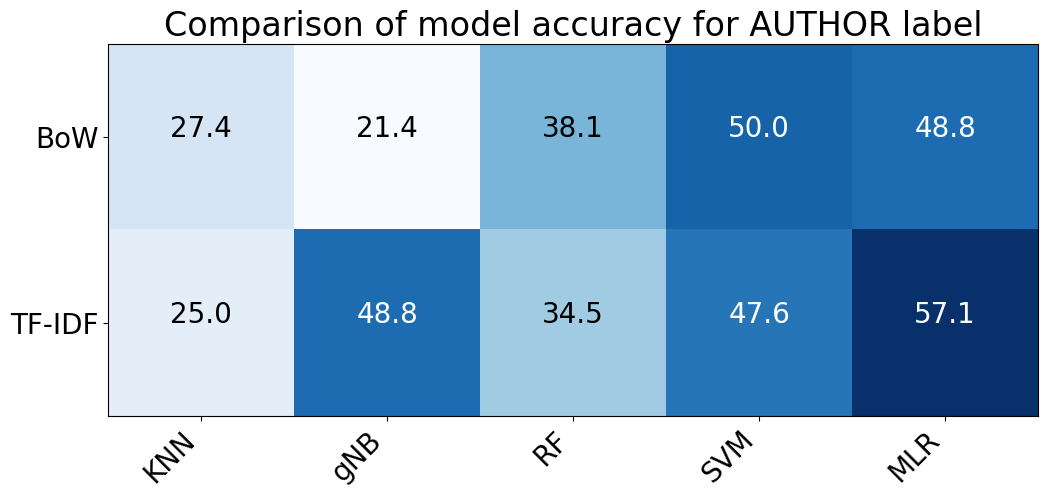

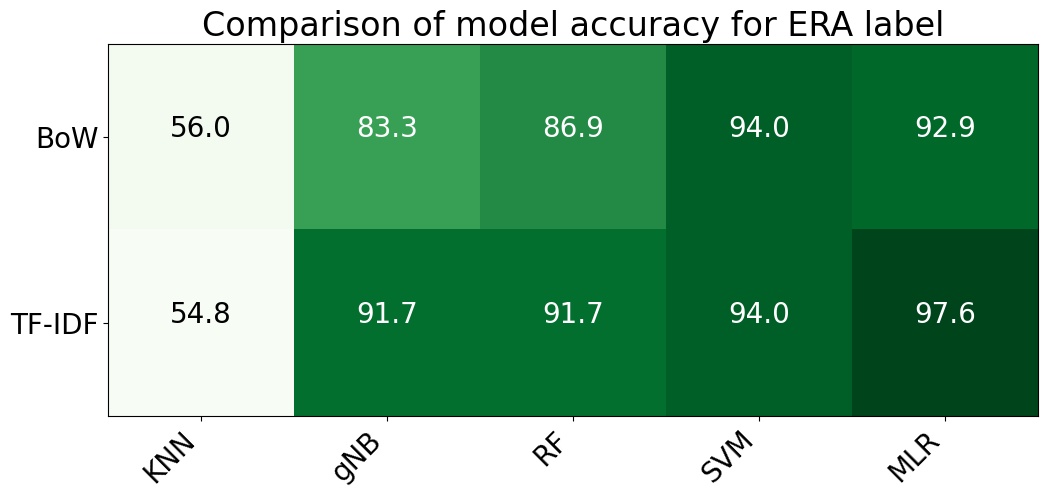

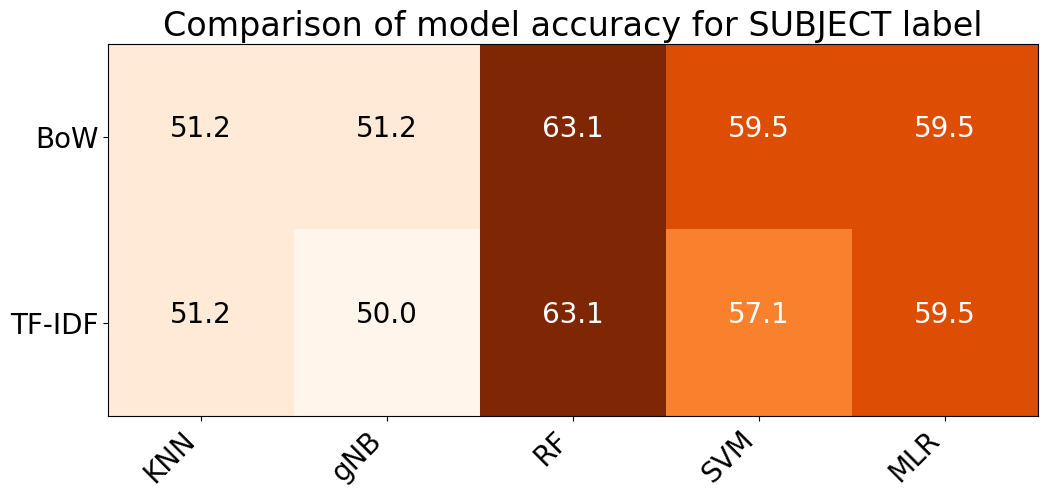

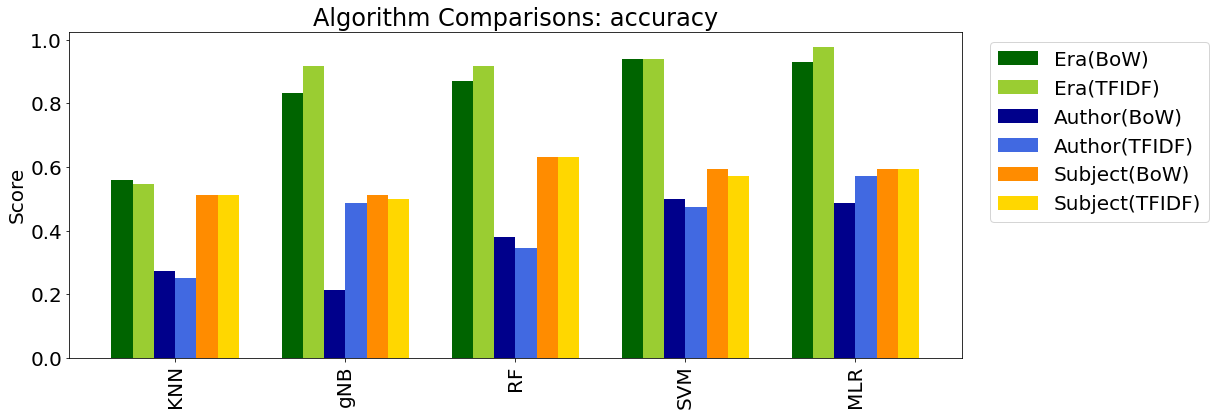

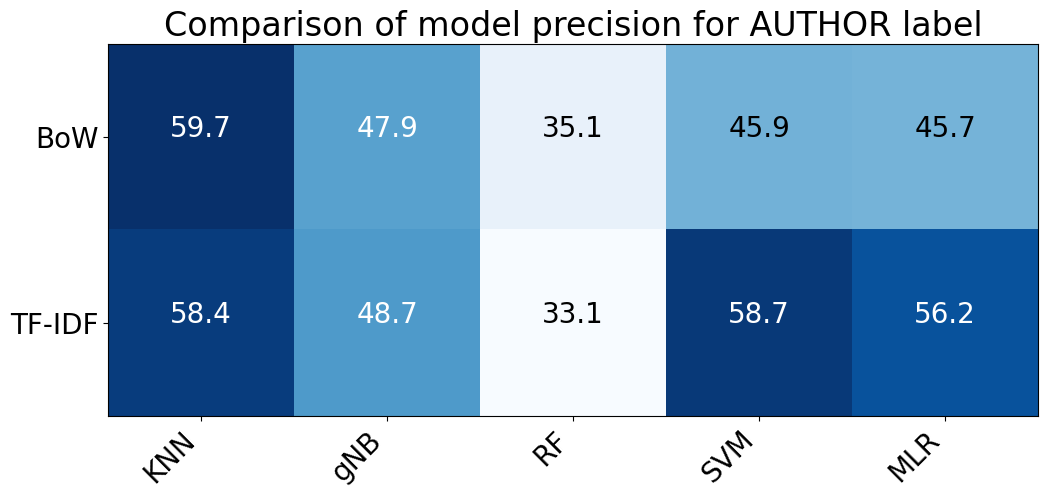

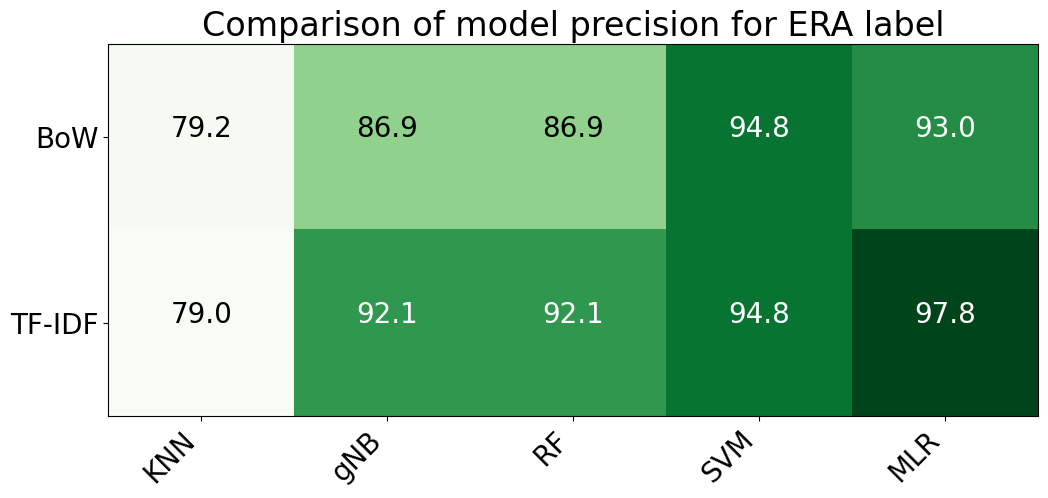

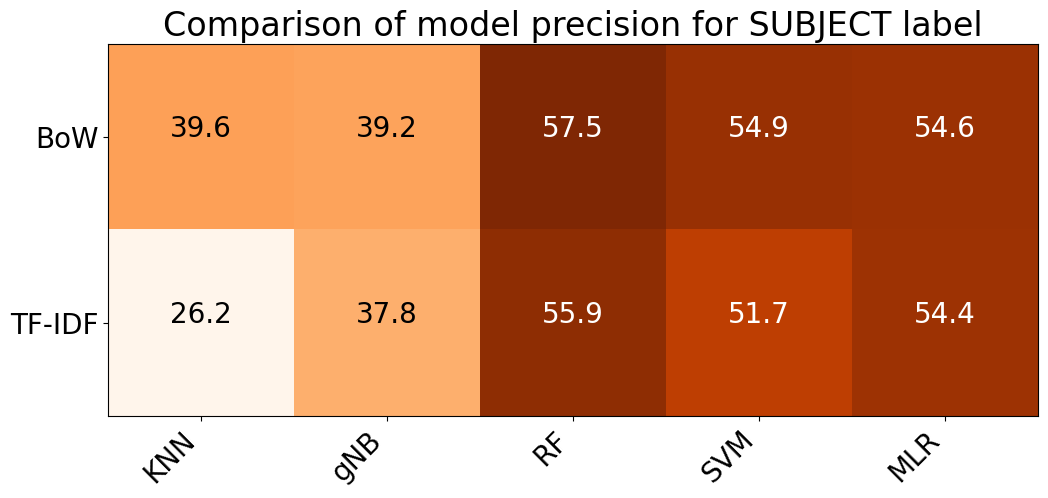

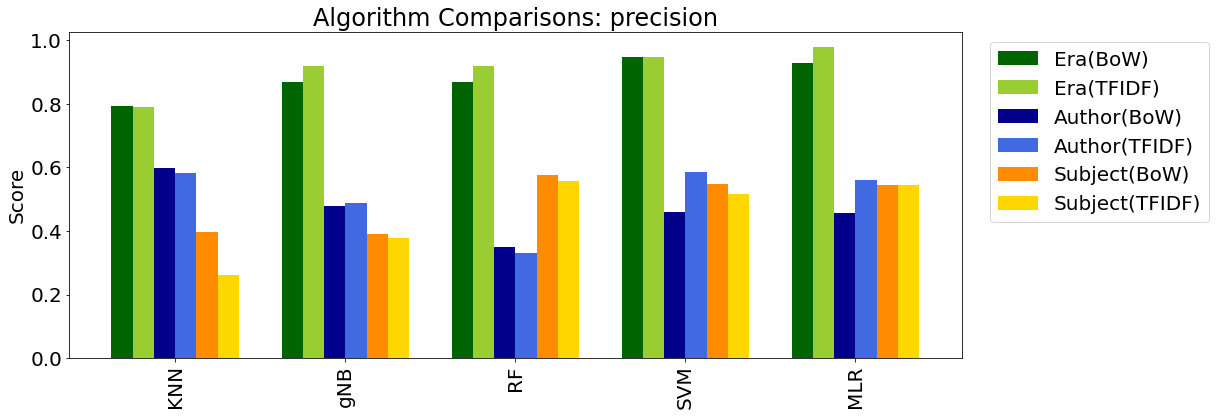

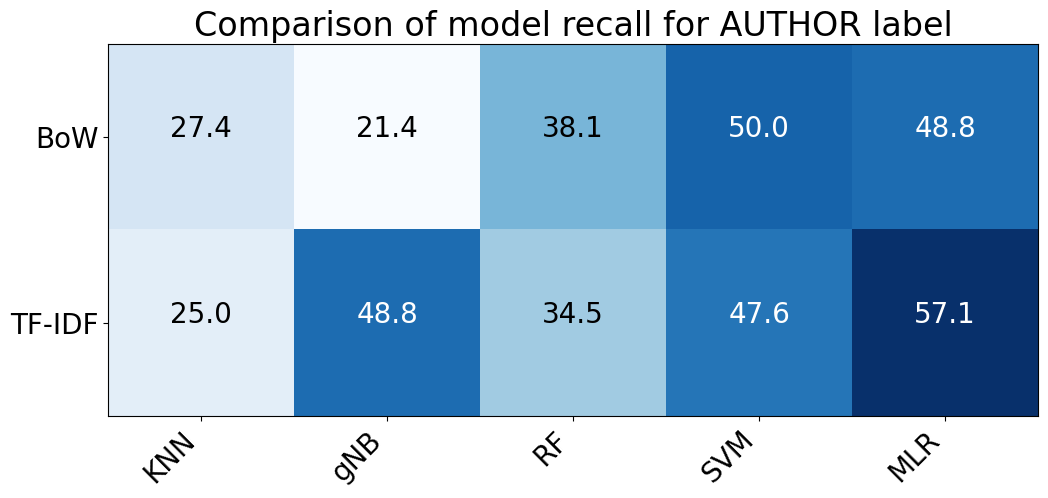

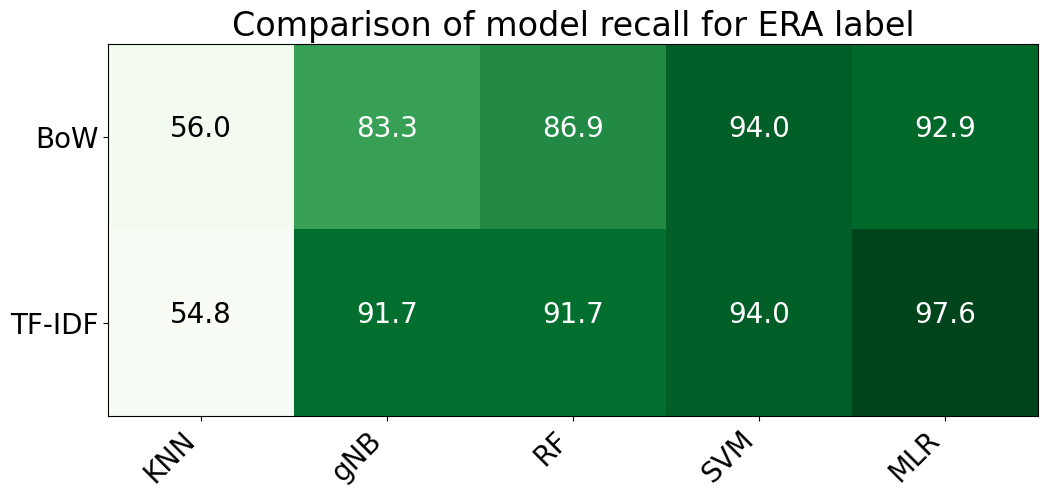

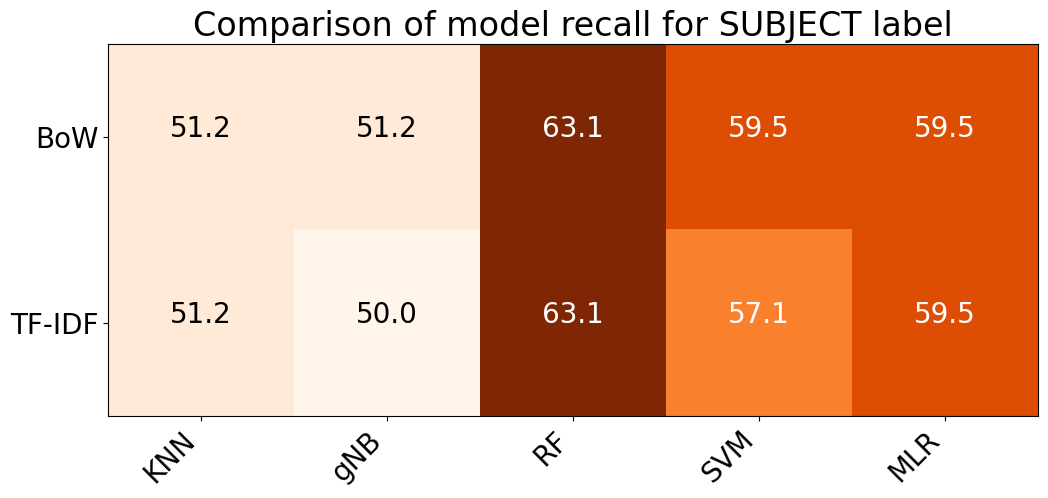

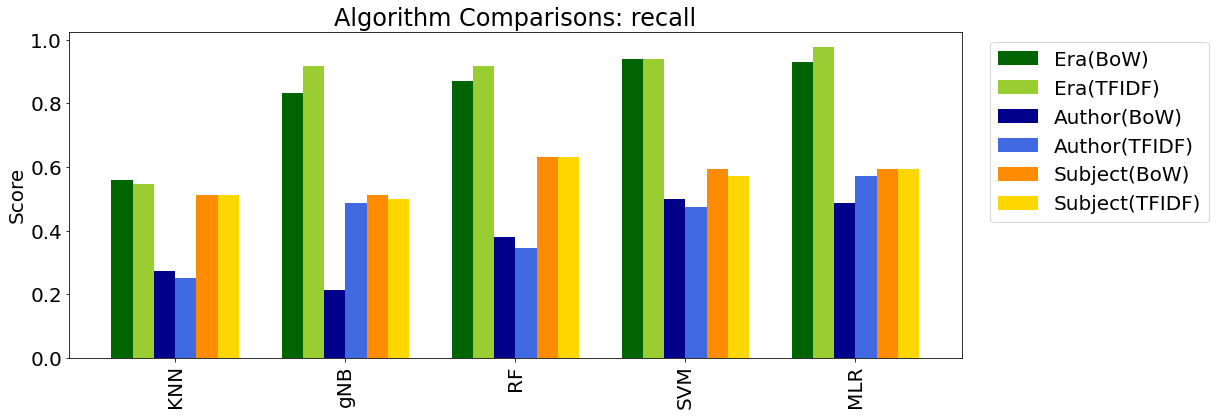

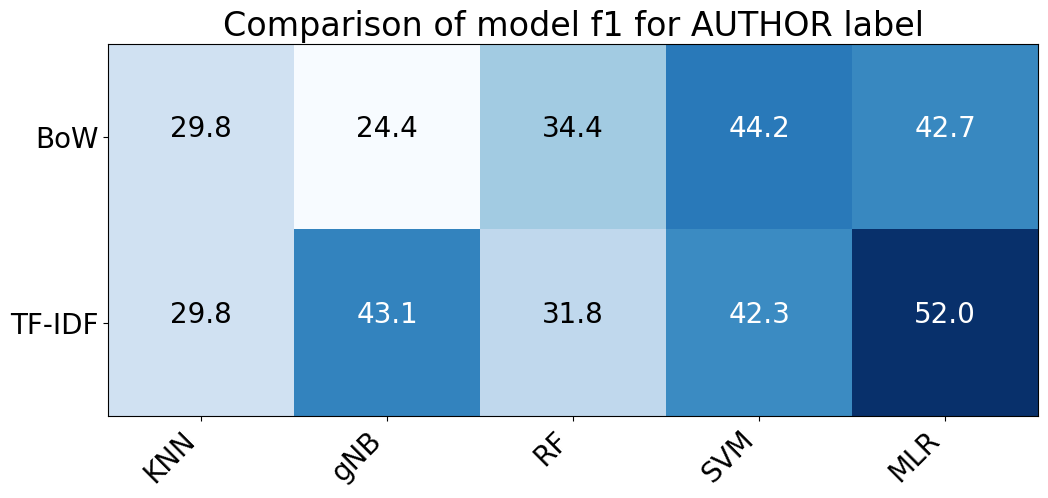

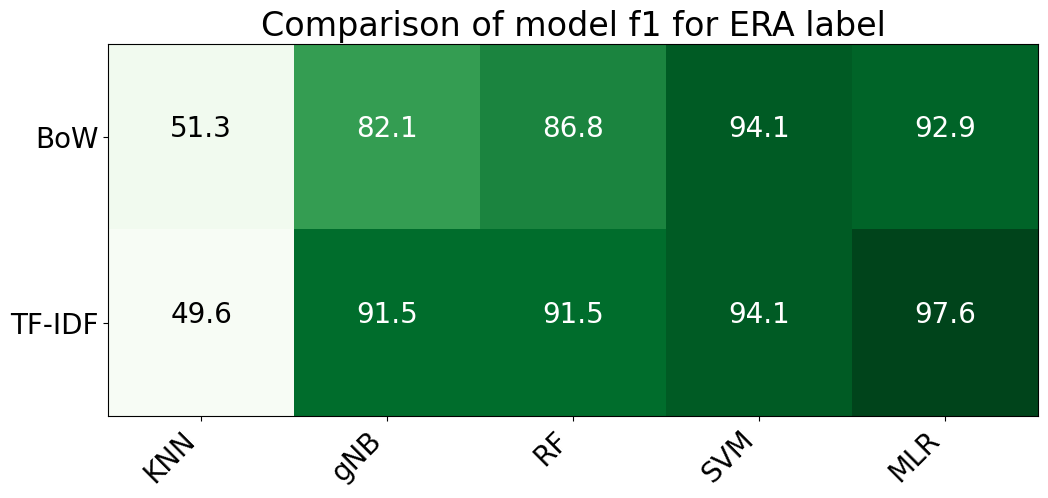

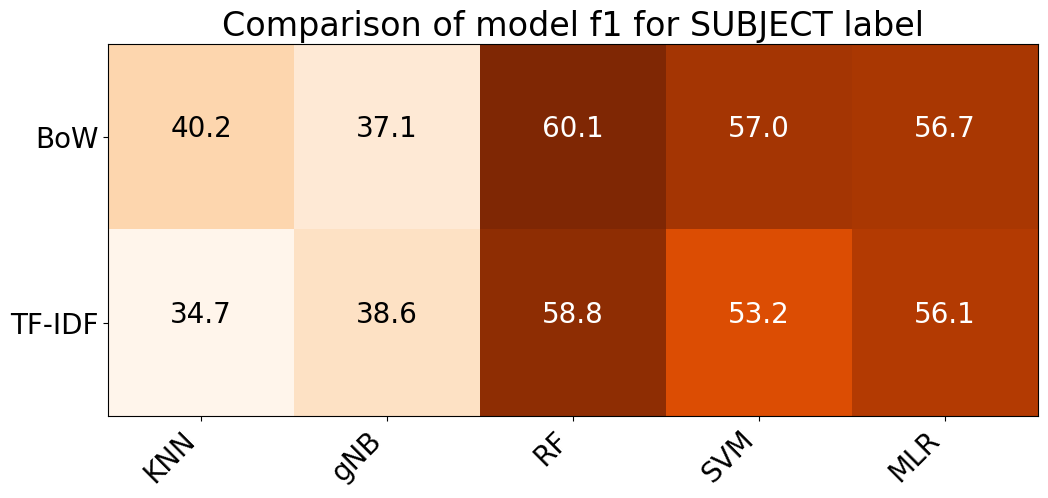

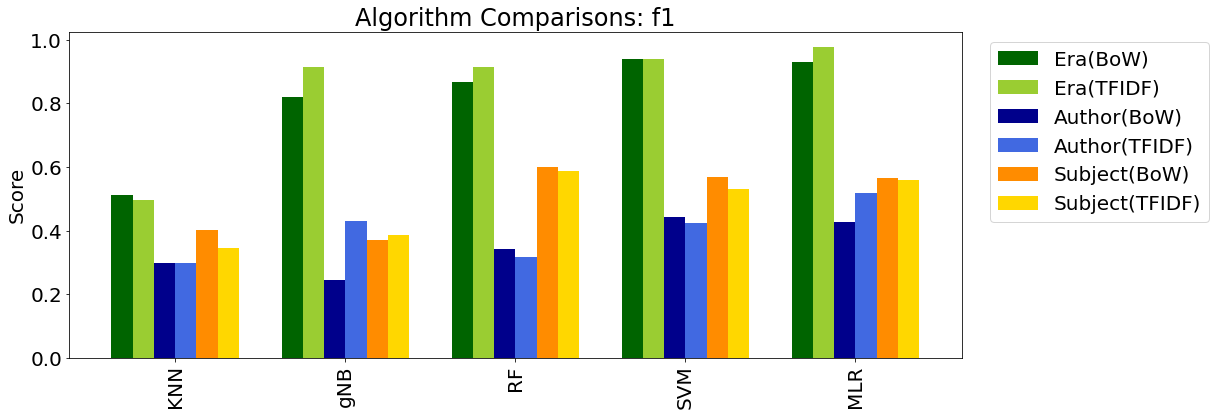

In [32]:
plot_performance_comparison(0)
plot_performance_comparison(2)
plot_performance_comparison(4)
plot_performance_comparison(6)

#### 10. Print mean/sd of all algoirthm's accuracy in each type of classification category 

In [25]:
#Mean/sd accuracy (across algorithms) for AUTHOR classification
authors_accuracy_BoW = [round(list(knn_perform_auth.values())[0],3),round(list(gnb_perform_auth.values())[0],3),round(list(rf_perform_auth.values())[0],3),round(list(svm_perform_auth.values())[0],3),round(list(mlr_perform_auth.values())[0],3)]
print("Mean accuracy - AUTHORS (BoW): %f, standard deviation: %f" %(np.mean(authors_accuracy_BoW),np.std(authors_accuracy_BoW)))
authors_accuracy_tfidf = [round(list(knn_perform_auth.values())[1],3),round(list(gnb_perform_auth.values())[1],3),round(list(rf_perform_auth.values())[1],3),round(list(svm_perform_auth.values())[1],3),round(list(mlr_perform_auth.values())[1],3)]
print("Mean accuracy - AUTHORS (TF-IDF): %f, standard deviation: %f" %(np.mean(authors_accuracy_tfidf),np.std(authors_accuracy_tfidf)))

#Mean/sd accuracy (across algorithms) for ERA classification
eras_accuracy_BoW = [round(list(knn_perform_era.values())[0],3),round(list(gnb_perform_era.values())[0],3),round(list(rf_perform_era.values())[0],3),round(list(svm_perform_era.values())[0],3),round(list(mlr_perform_era.values())[0],3)]
print("Mean accuracy - ERAS (BoW): %f, standard deviation: %f" %(np.mean(eras_accuracy_BoW),np.std(eras_accuracy_BoW)))
eras_accuracy_tfidf = [round(list(knn_perform_era.values())[1],3),round(list(gnb_perform_era.values())[1],3),round(list(rf_perform_era.values())[1],3),round(list(svm_perform_era.values())[1],3),round(list(mlr_perform_era.values())[1],3)]
print("Mean accuracy - ERAS (TF-IDF): %f, standard deviation: %f" %(np.mean(eras_accuracy_tfidf),np.std(eras_accuracy_tfidf)))

#Mean/sd accuracy (across algorithms) for SUBJECT classification
subject_accuracy_BoW = [round(list(knn_perform_sub.values())[0],3),round(list(gnb_perform_sub.values())[0],3),round(list(rf_perform_sub.values())[0],3),round(list(svm_perform_sub.values())[0],3),round(list(mlr_perform_sub.values())[0],3)]
print("Mean accuracy - SUBJECTS (BoW): %f, standard deviation: %f" %(np.mean(subject_accuracy_BoW),np.std(subject_accuracy_BoW)))
subject_accuracy_tfidf = [round(list(knn_perform_sub.values())[1],3),round(list(gnb_perform_sub.values())[1],3),round(list(rf_perform_sub.values())[1],3),round(list(svm_perform_sub.values())[1],3),round(list(mlr_perform_sub.values())[1],3)]
print("Mean accuracy - SUBJECTS (TF-IDF): %f, standard deviation: %f" %(np.mean(subject_accuracy_tfidf),np.std(subject_accuracy_tfidf)))

Mean accuracy - AUTHORS (BoW): 0.371400, standard deviation: 0.113567
Mean accuracy - AUTHORS (TF-IDF): 0.426000, standard deviation: 0.113935
Mean accuracy - ERAS (BoW): 0.826200, standard deviation: 0.138751
Mean accuracy - ERAS (TF-IDF): 0.859600, standard deviation: 0.157288
Mean accuracy - SUBJECTS (BoW): 0.569000, standard deviation: 0.048361
Mean accuracy - SUBJECTS (TF-IDF): 0.561800, standard deviation: 0.049548


#### 11. Visualize authors in terms of frequency predicted, frequency in training set and frequency in testing set 

In [26]:
#determining frequency of each poet in training/testing set 
poets_unique = np.unique(poems["author"])
poets_train_freq = np.zeros_like(poets_unique)
poets_test_freq = np.zeros_like(poets_unique)

for p in range(len(poets_unique)):
    poets_train_freq[p] = len(auth_train[auth_train==poets_unique[p]])
    poets_test_freq[p] = len(auth_test[auth_test==poets_unique[p]])
    
#function to determine frequency of each poet in the predictions of each model

def find_pred_freq(predictions_BoW, predictions_tfidf):
    poets_pred_freq_BoW = np.zeros_like(poets_unique)
    poets_pred_freq_tfidf = np.zeros_like(poets_unique)
    both_predictions_unique = set.union(set(predictions_BoW),set(predictions_tfidf))
    poets_unique_p_int = np.zeros(len(both_predictions_unique),dtype=int)
    poets_train_freq_p = np.zeros(len(both_predictions_unique))
    poets_test_freq_p = np.zeros(len(both_predictions_unique))
    counter = 0
    for p in range(len(poets_unique)):
        poets_pred_freq_BoW[p] = len(predictions_BoW[predictions_BoW==poets_unique[p]])
        poets_pred_freq_tfidf[p] = len(predictions_tfidf[predictions_tfidf==poets_unique[p]])
        if poets_unique[p] in both_predictions_unique:
            poets_unique_p_int[counter] = int(p)
            poets_train_freq_p[counter] = poets_train_freq[p]
            poets_test_freq_p[counter] = poets_test_freq[p]
            counter += 1
            
    poets_unique_p = poets_unique[poets_unique_p_int]
    poets_pred_freq_BoW_p = poets_pred_freq_BoW[poets_unique_p_int]
    poets_pred_freq_tfidf_p = poets_pred_freq_tfidf[poets_unique_p_int]

    return poets_pred_freq_BoW, poets_pred_freq_tfidf, poets_pred_freq_BoW_p, poets_pred_freq_tfidf_p,poets_unique_p, poets_train_freq_p, poets_test_freq_p

In [27]:
#Bar charts to plot these frequencies 

def plot_author_frequncy_per_model(predictions_BoW, predictions_TFIDF,model_title):
    #All authors 
    model_author_pred_freq = {'poets':poets_unique,
                            'test set frequency':poets_test_freq,
                            'training set frequency':poets_train_freq,
                            'model predictions frequency - BoW':find_pred_freq(predictions_BoW, predictions_TFIDF)[0],
                            'model predictions frequency - TF-IDF':find_pred_freq(predictions_BoW, predictions_TFIDF)[1]}
    model_author_pred_freq_df = pd.DataFrame(data=model_author_pred_freq)
    model_author_pred_freq_df.plot(x='poets',y=['test set frequency','training set frequency','model predictions frequency - BoW','model predictions frequency - TF-IDF'],kind='bar',width=.75,color=['black','slategray','orangered','violet'])
    plt.xlabel("")
    plt.ylabel("Frequency")
    plt.title("%s prediction frequencies - ALL AUTHORS"%model_title)
    fig = plt.gcf()
    fig.set_size_inches(30, 10, forward=True)
    plt.savefig(("%s_authorsfreq_ALL.png"%model_title),format='png',dpi=200,bbox_inches='tight')
    plt.show()


    #Only predicted authors 
    model_author_pred_freq_predsonly = {'poets':find_pred_freq(predictions_BoW, predictions_TFIDF)[4],
                        'test set frequency':find_pred_freq(predictions_BoW, predictions_TFIDF)[6],
                        'training set frequency':find_pred_freq(predictions_BoW, predictions_TFIDF)[5],
                        'model predictions frequency - BoW':find_pred_freq(predictions_BoW, predictions_TFIDF)[2],
                        'model predictions frequency - TF-IDF':find_pred_freq(predictions_BoW, predictions_TFIDF)[3]}
    model_author_pred_freq_predsonly_df = pd.DataFrame(data=model_author_pred_freq_predsonly)
    model_author_pred_freq_predsonly_df.plot(x='poets',y=['test set frequency','training set frequency','model predictions frequency - BoW','model predictions frequency - TF-IDF'],kind='bar',width=.75,color=['black','slategray','orangered','violet'])
    plt.xlabel("")
    plt.ylabel("Frequency")
    plt.title("%s prediction frequencies"% model_title)
    fig = plt.gcf()
    fig.set_size_inches(16, 6, forward=True)
    plt.savefig(("%s_authorsfreq_PREDSONLY.png"%model_title),format='png',dpi=200,bbox_inches='tight')
    plt.show()


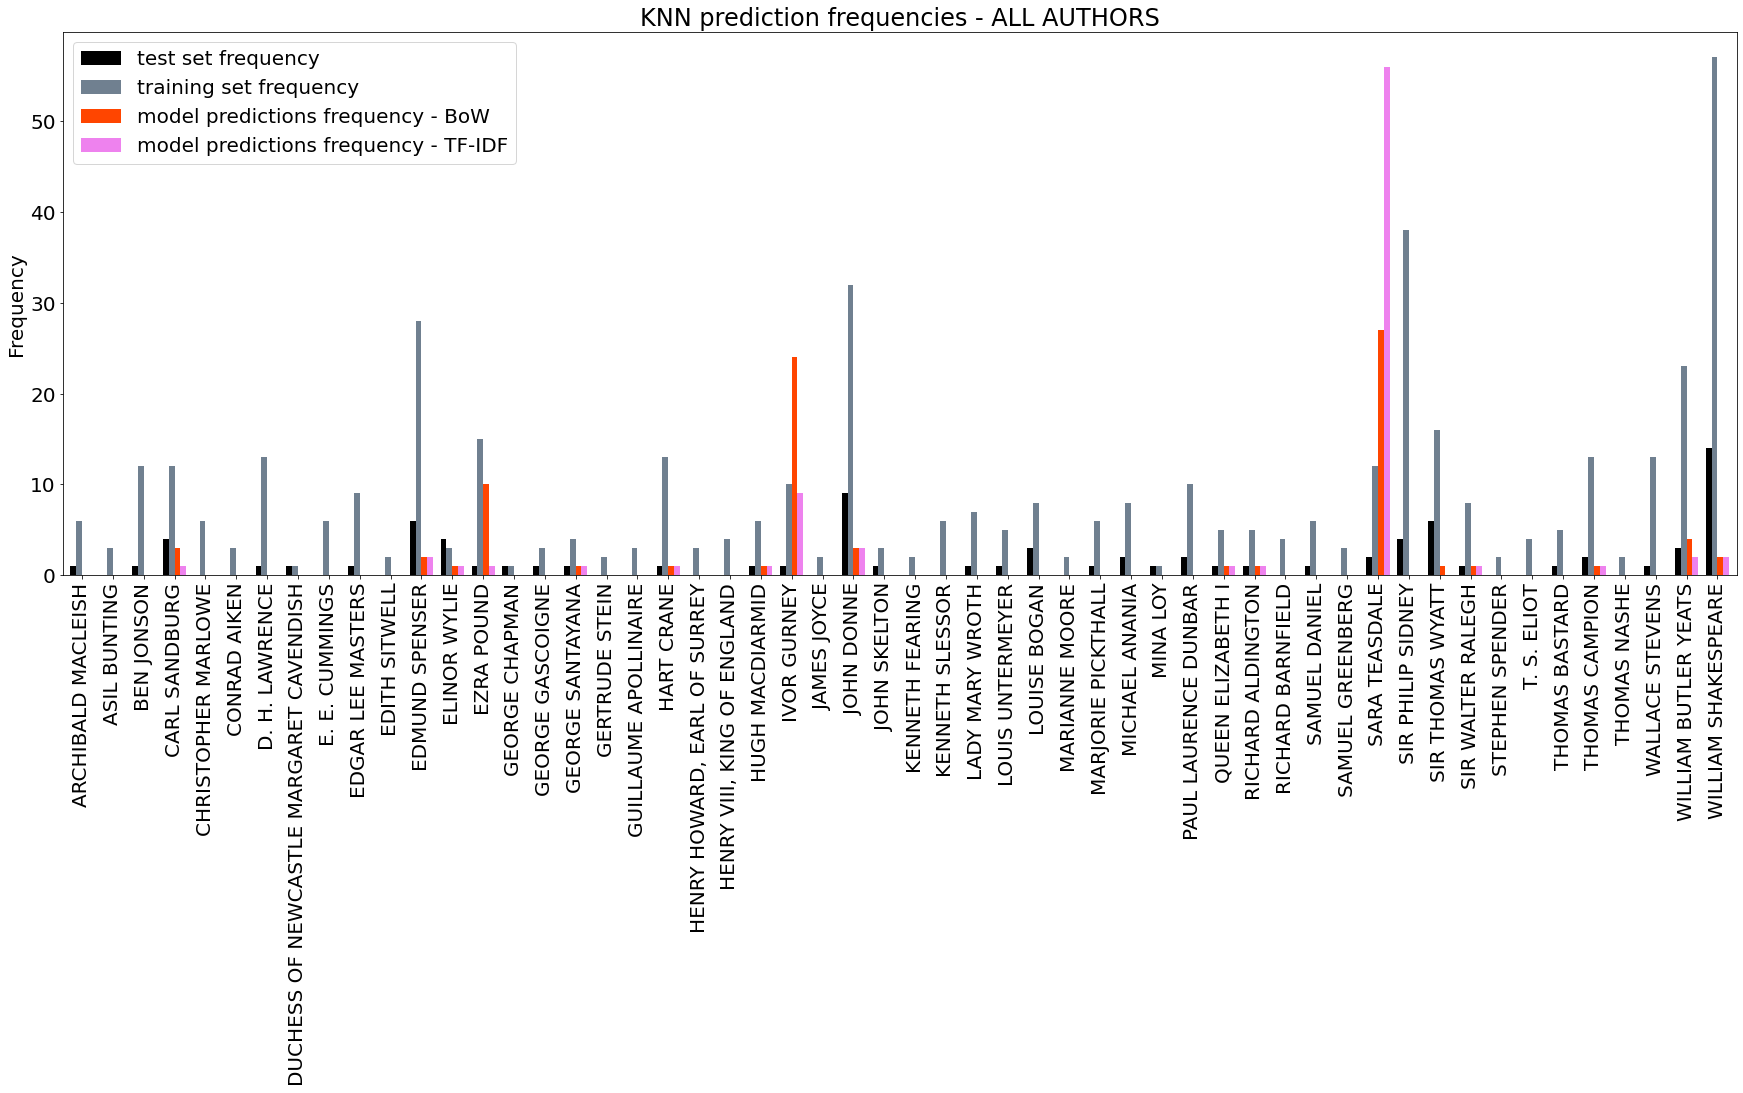

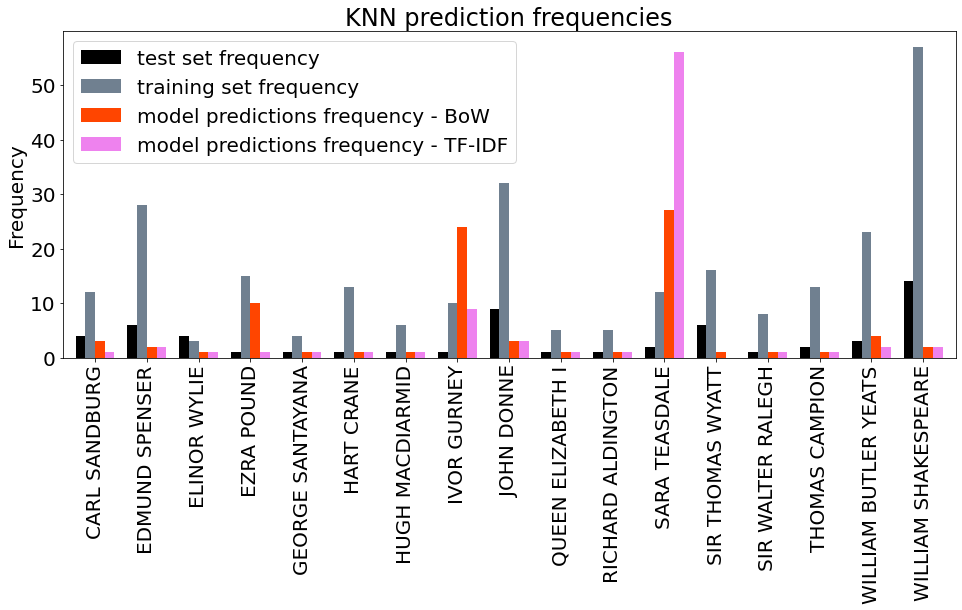

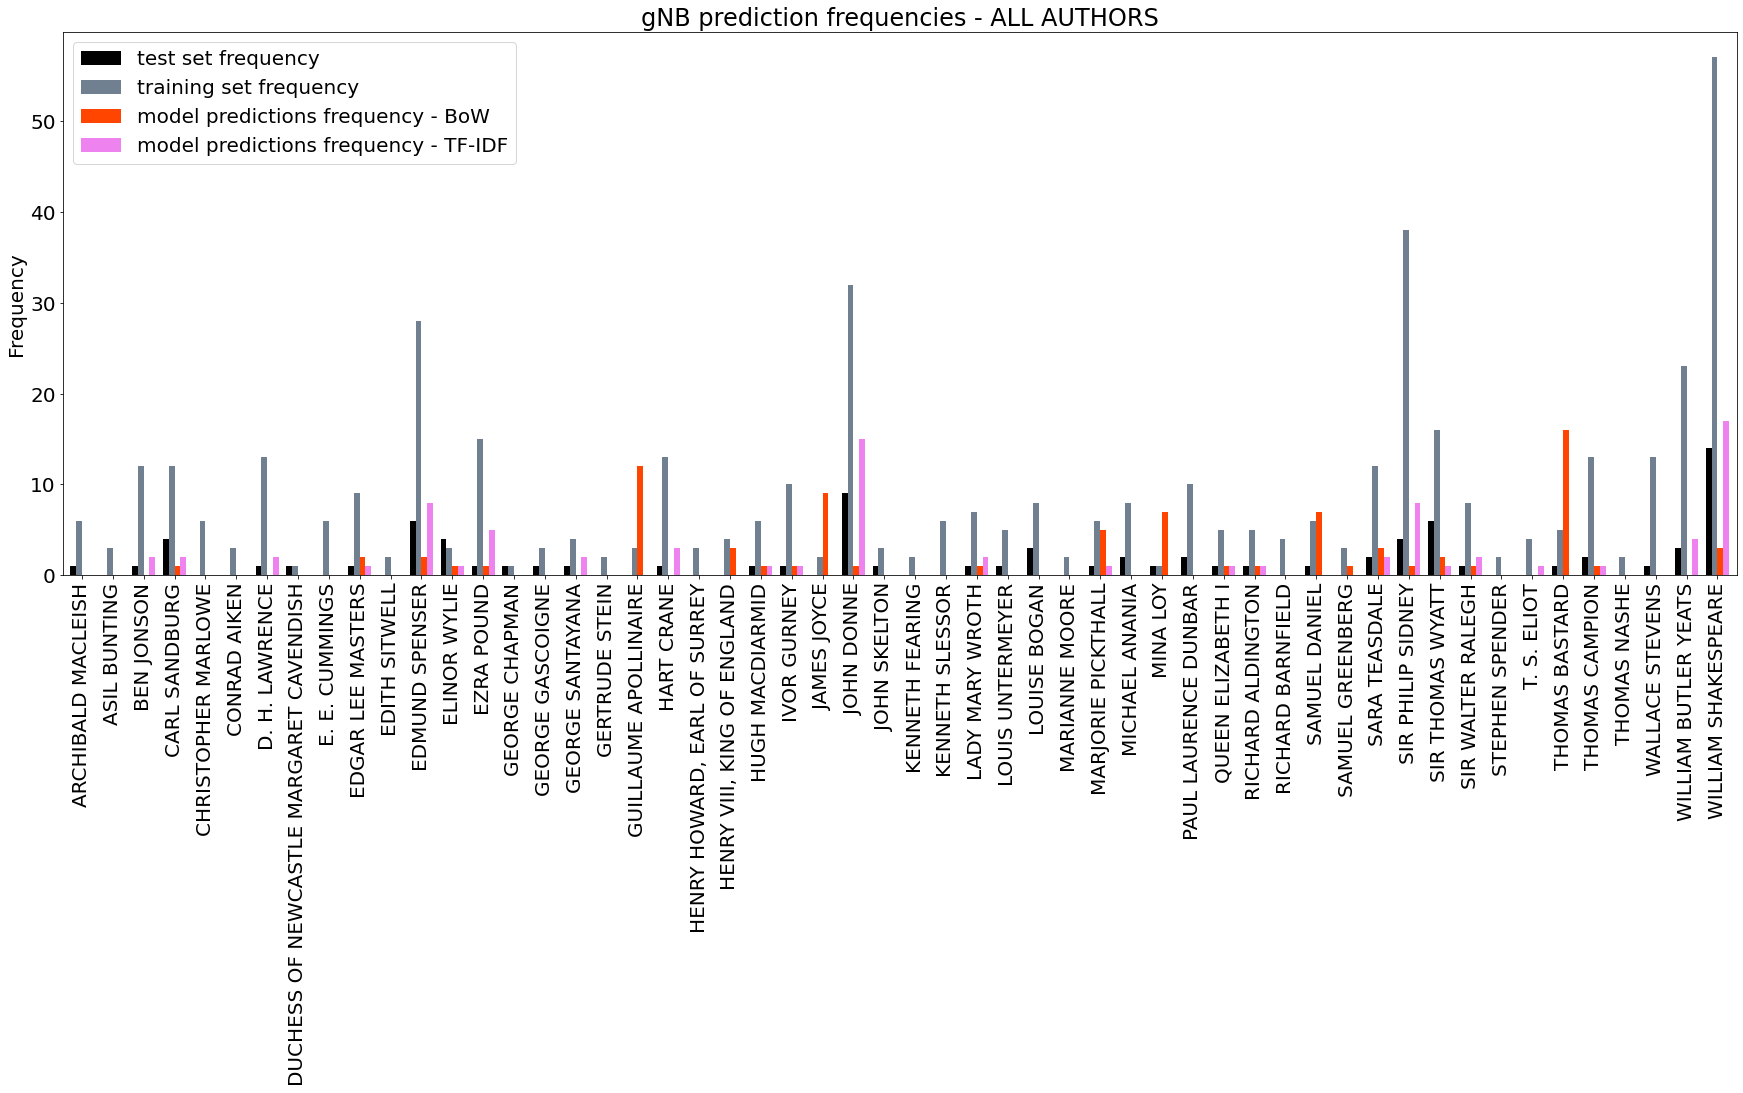

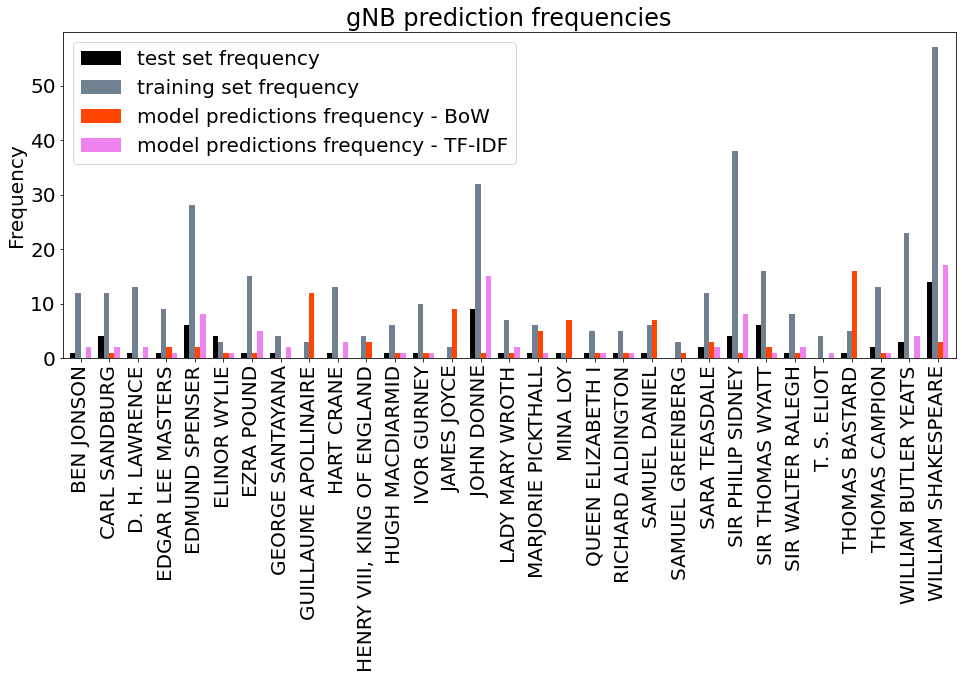

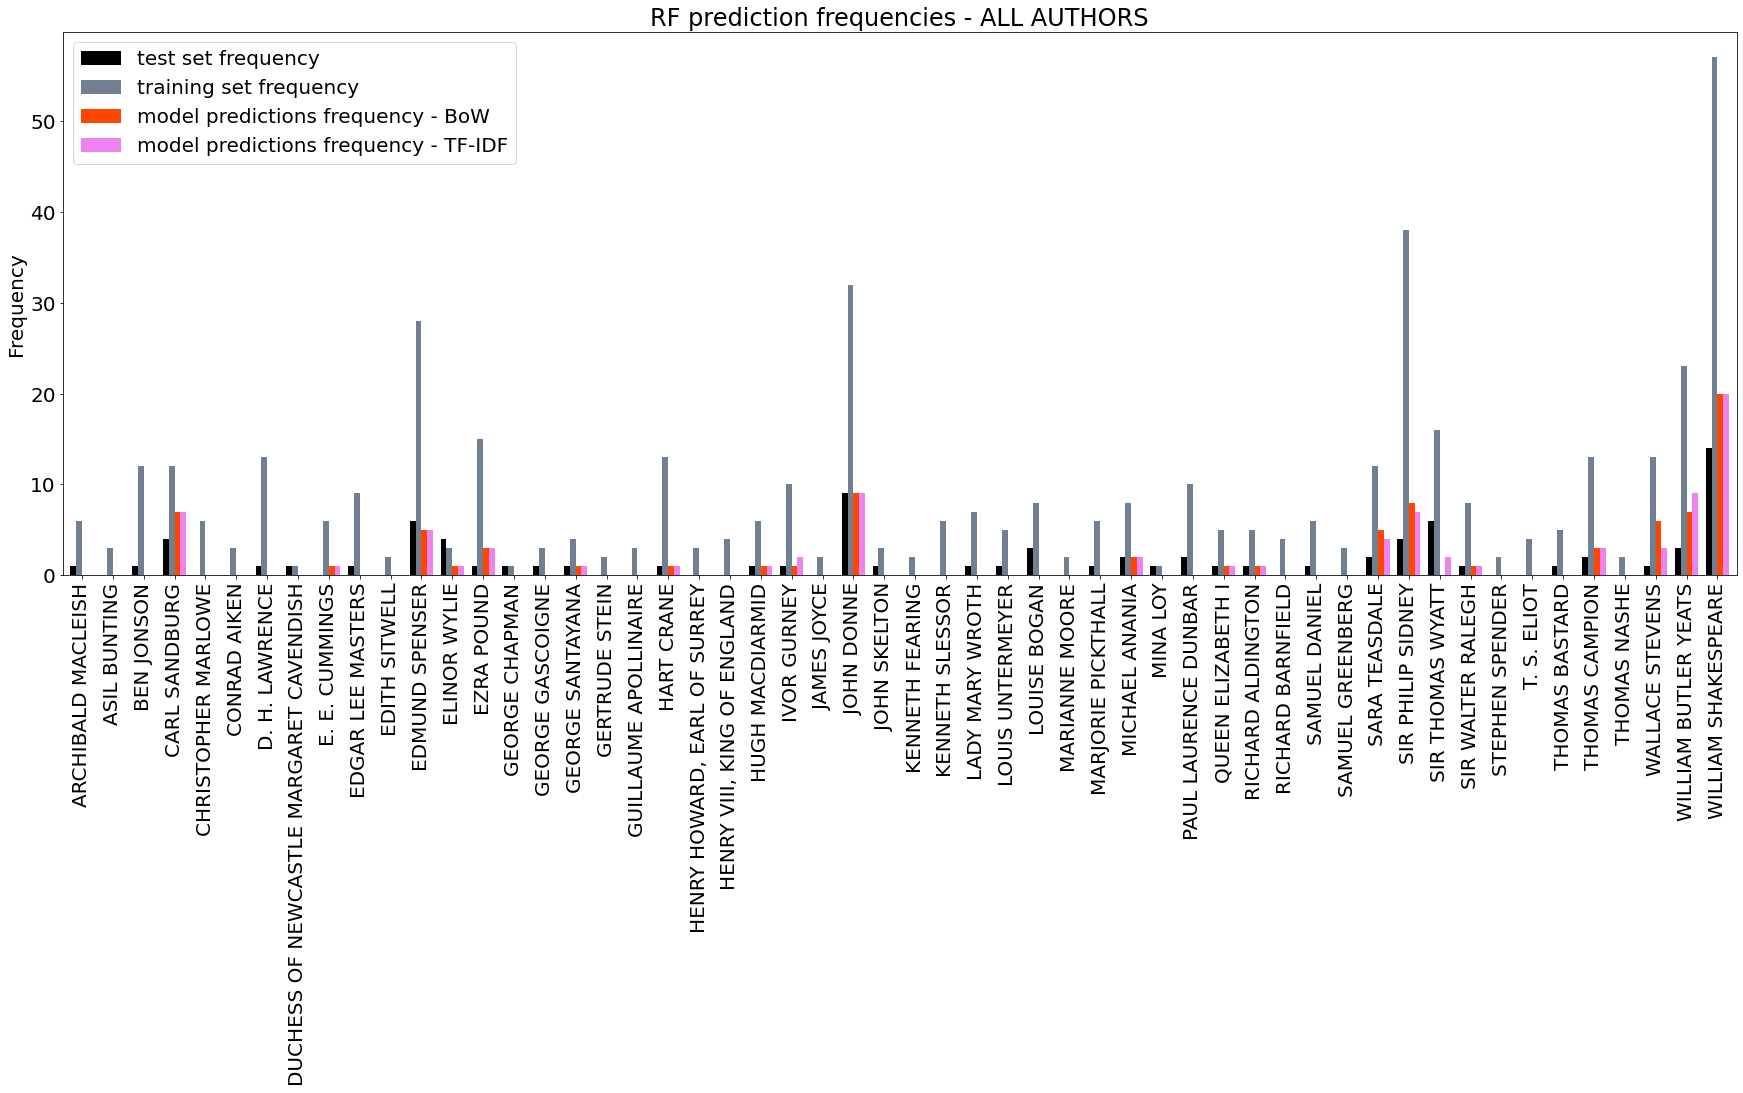

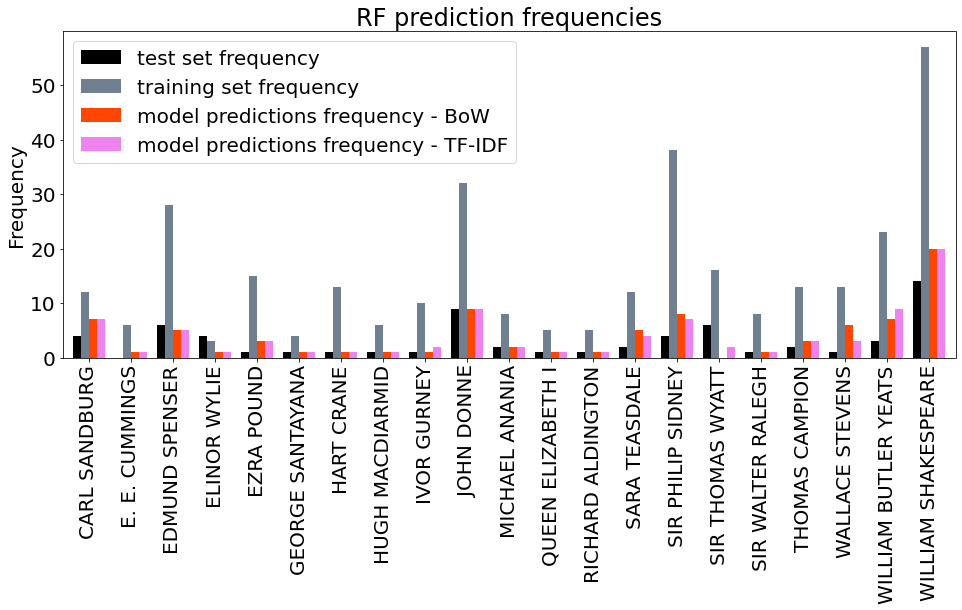

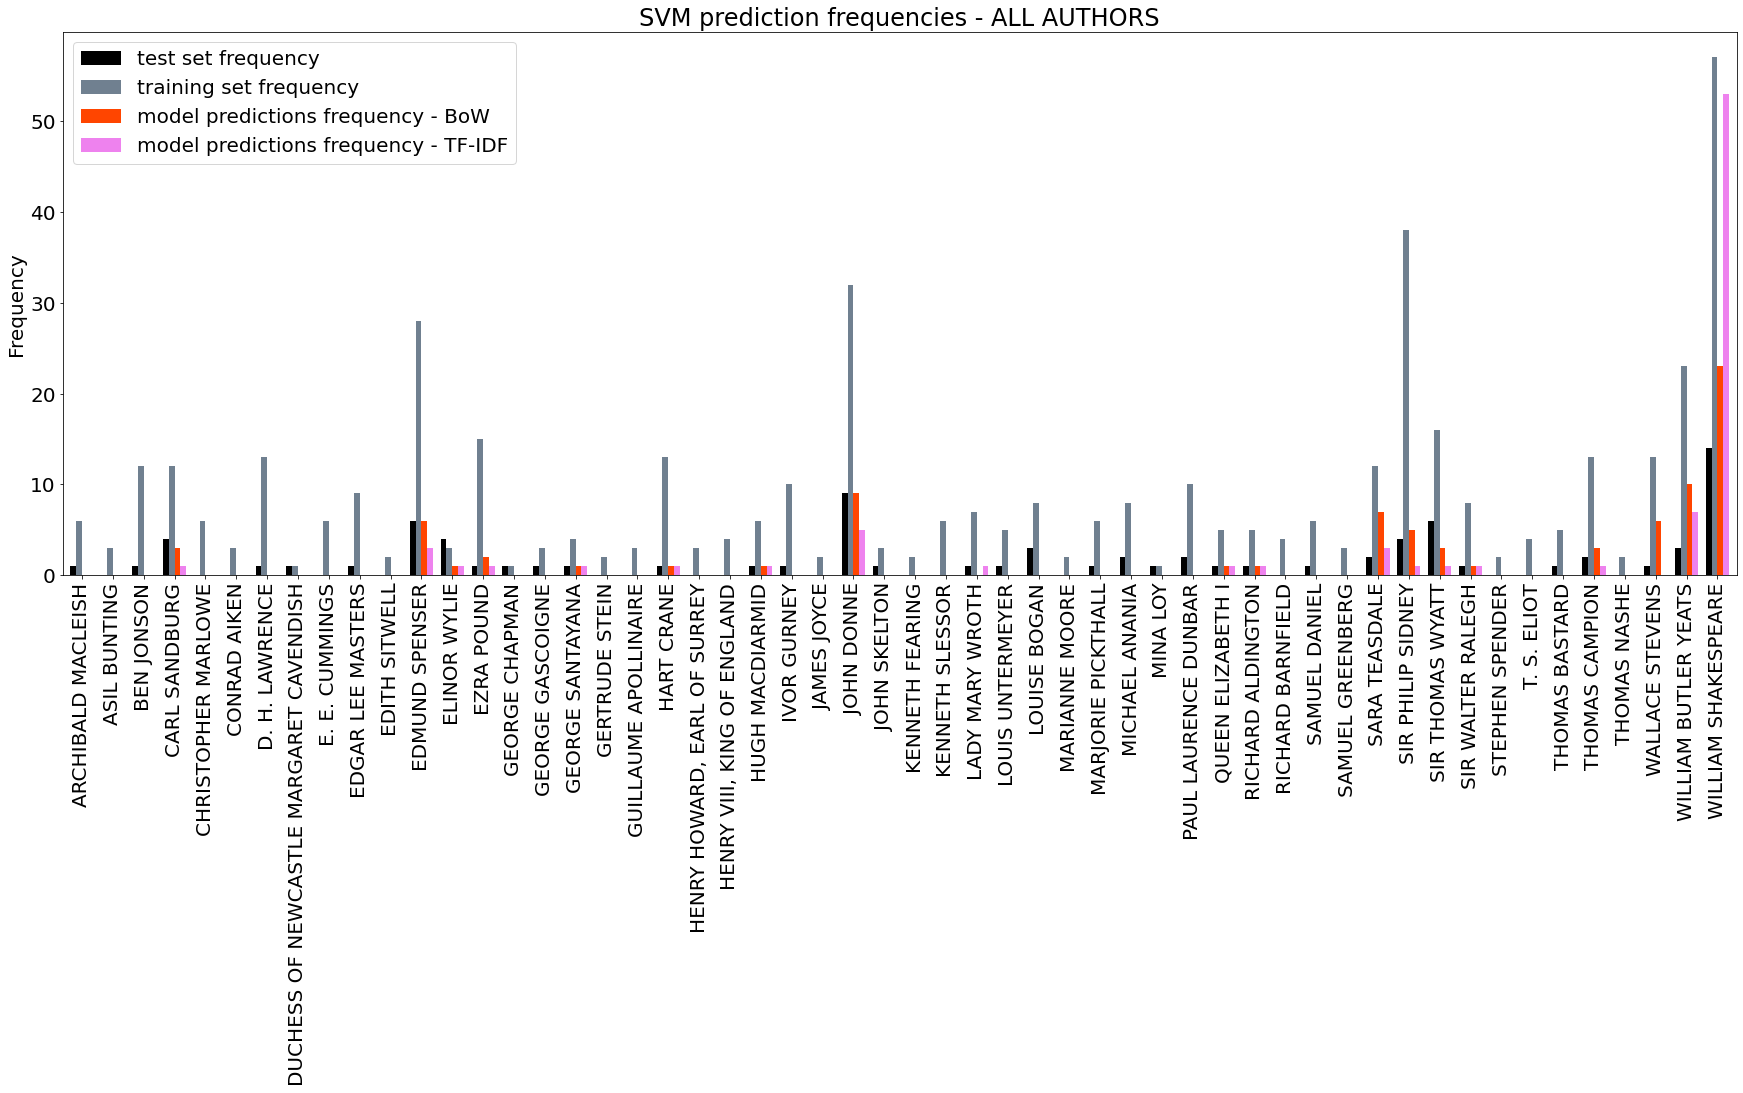

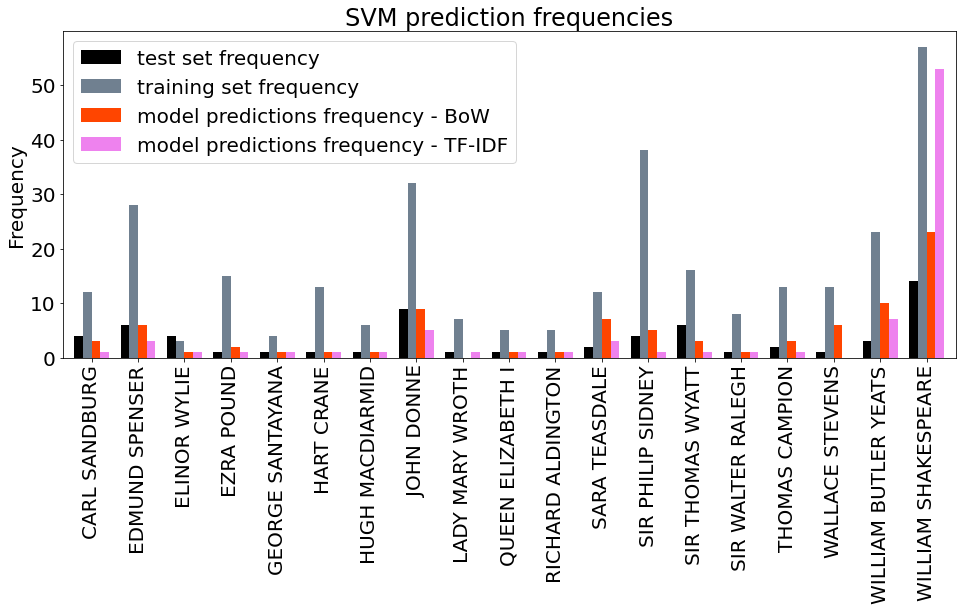

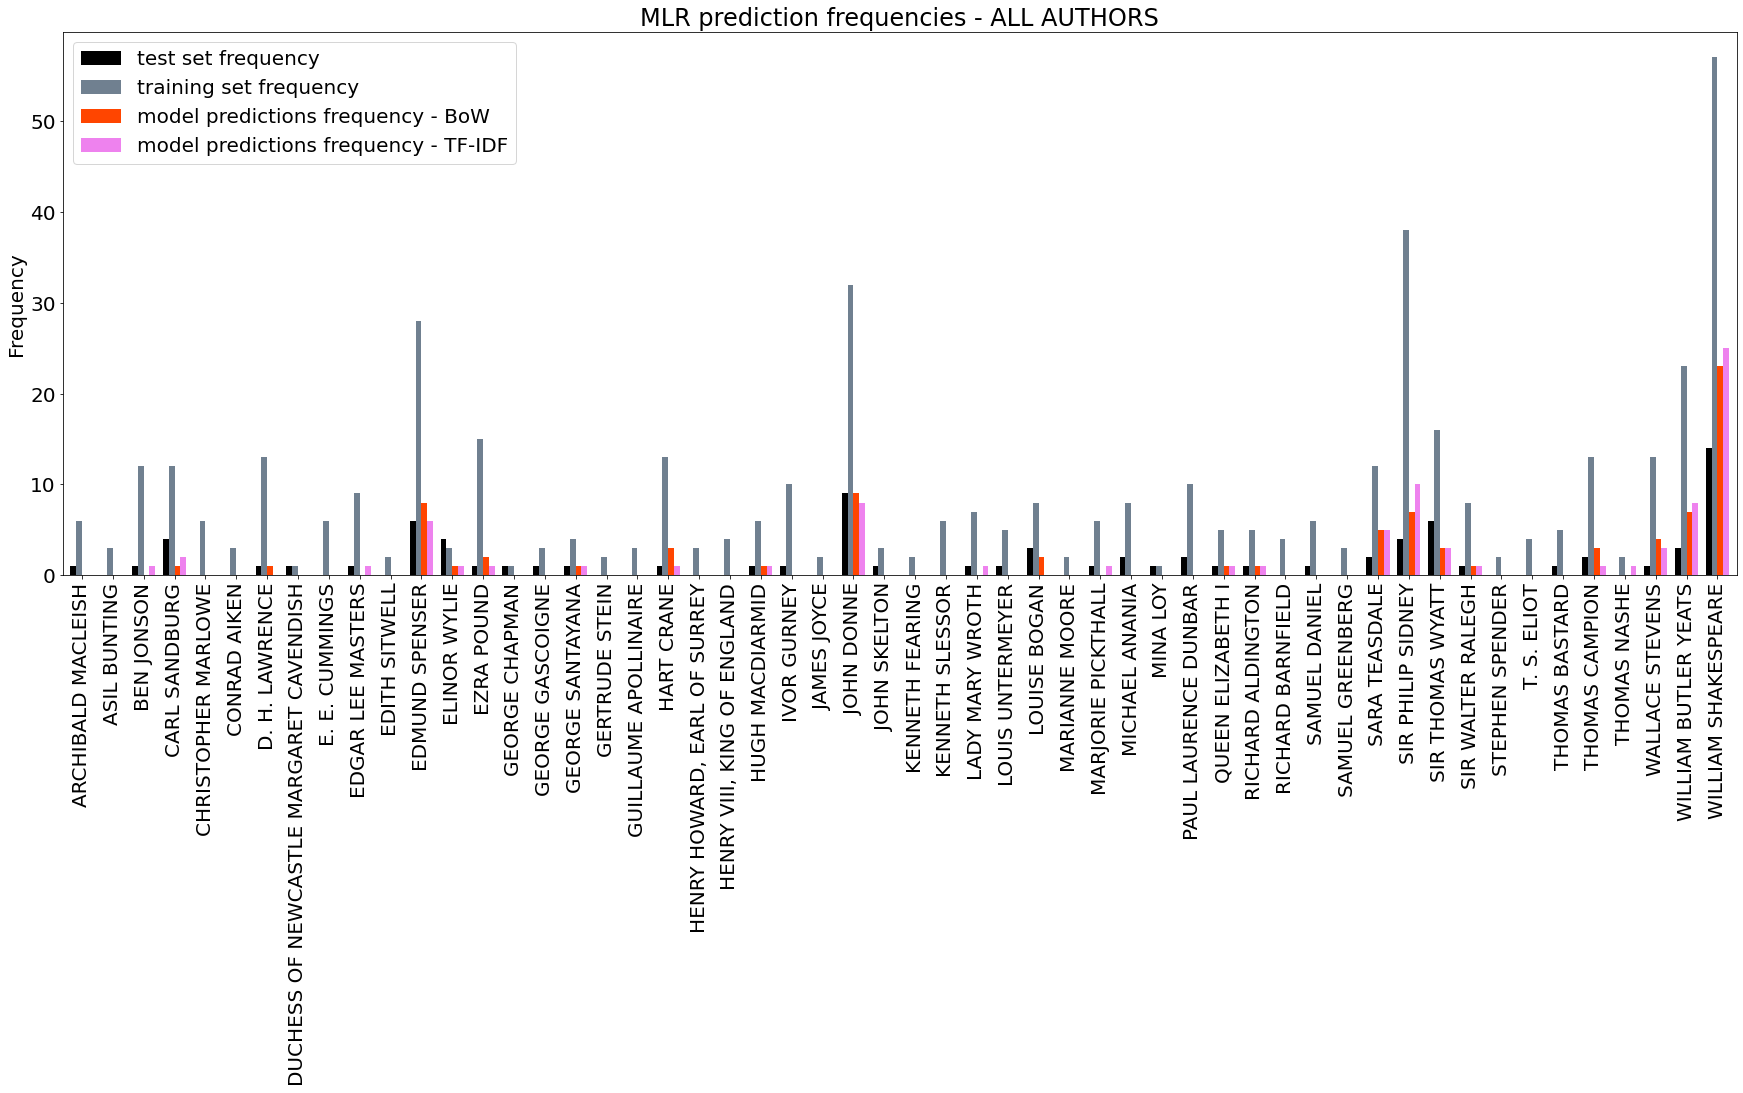

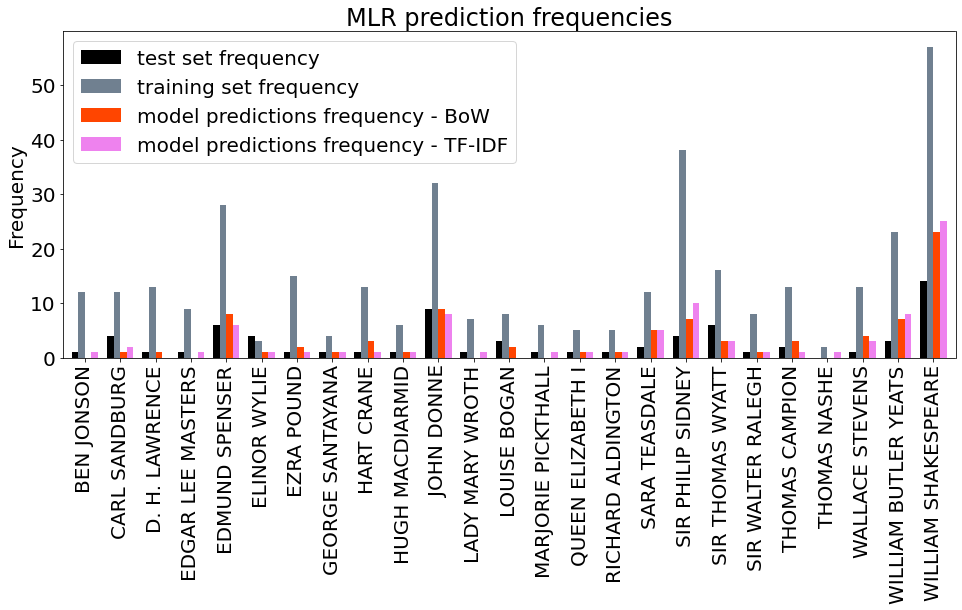

In [28]:
plot_author_frequncy_per_model(knn_perform_auth['predicted_labs_BoW'],knn_perform_auth['predicted_labs_tfidf'],"KNN")

plot_author_frequncy_per_model(gnb_perform_auth['predicted_labs_BoW'],gnb_perform_auth['predicted_labs_tfidf'],"gNB")

plot_author_frequncy_per_model(rf_perform_auth['predicted_labs_BoW'],rf_perform_auth['predicted_labs_tfidf'],"RF")

plot_author_frequncy_per_model(svm_perform_auth['predicted_labs_BoW'],svm_perform_auth['predicted_labs_tfidf'],"SVM")

plot_author_frequncy_per_model(mlr_perform_auth['predicted_labs_BoW'],mlr_perform_auth['predicted_labs_tfidf'],"MLR")

## Part 3: Compare performance of unsupervised clustering algorithms (KMeans, Spectral Clustering, DBSCAN) on clustering author, era, and subect 

In [33]:
#determining the K values that will be used in clustering 
no_authors = len(np.unique(auth_train))
no_eras = len(np.unique(era_train))
no_subjects = len(np.unique(sub_train))

In [35]:
#duplicating original vectors before they were partitioned (clustering does not require breaking data into training and testing sets)
BoW = copy.copy(poem_word_freq)
TFIDF = copy.copy(poem_word_tfidf) 
authors = copy.copy(poem_author)
eras = copy.copy(poem_age) 
subjects = copy.copy(poem_type)

#### 1. Determining frequency of each author, subject, and era in the dataset. (Inverse) frequency will be used to weight sample during K-means clustering procedure (to account for unequal occurence of each label in these categoes)

#### 2. Also deriving the labels corresponding with these frequency values to be used as the 'ground truth' of clustering procedure.

In [36]:
author_counts = poems['author'].value_counts()
#list of unique authors
authors_uniq = list(author_counts.index)
#list of author frequencies in dataset
authors_freq = list(author_counts)
#inverse frequency of authors in dataset 
authors_inverse_freq = [sum(authors_freq)/freq for freq in authors_freq]
#list of inverse frequencies corresponding with sample algorithms will be fit on
authors_inverse_freq_samp = [authors_inverse_freq[authors_uniq.index(auth)]for auth in authors]

era_counts = poems['age'].value_counts()
eras_uniq = list(era_counts.index)
eras_freq = list(era_counts)
eras_inverse_freq = [sum(eras_freq)/freq for freq in eras_freq]
eras_inverse_freq_samp = [eras_inverse_freq[eras_uniq.index(er)]for er in eras]

subject_counts = poems['type'].value_counts()
subjects_uniq = list(subject_counts.index)
subject_freq = list(subject_counts)
subject_inverse_freq = [sum(subject_freq)/freq for freq in subject_freq]
subject_inverse_freq_samp = [subject_inverse_freq[subjects_uniq.index(sub)]for sub in subjects]

#### 3. Determine 'epsilon' value to be used in DBSCAN algorithm accoring to the following technique: https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf. The distances between each pairwise combination of 2 datapoints are calculated using KNN algorithm. These distances are then plotted with epsilon on y-axis and frequency on x-axis. The point at which the slope of the line drastically shifts is considered the best eps value.

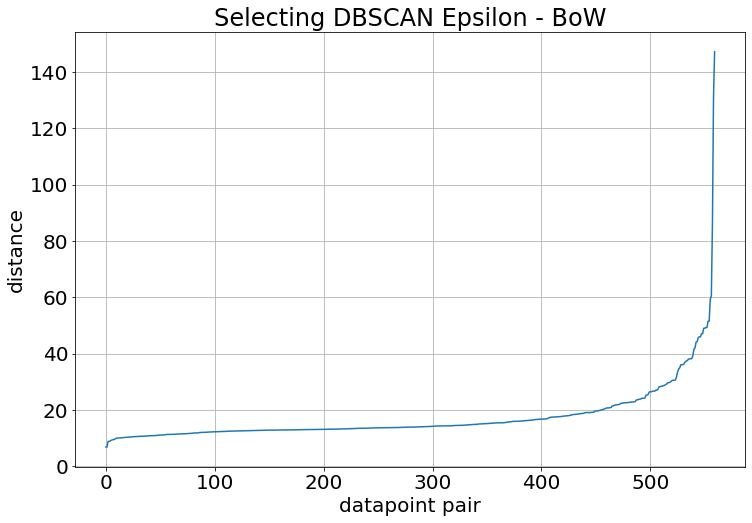

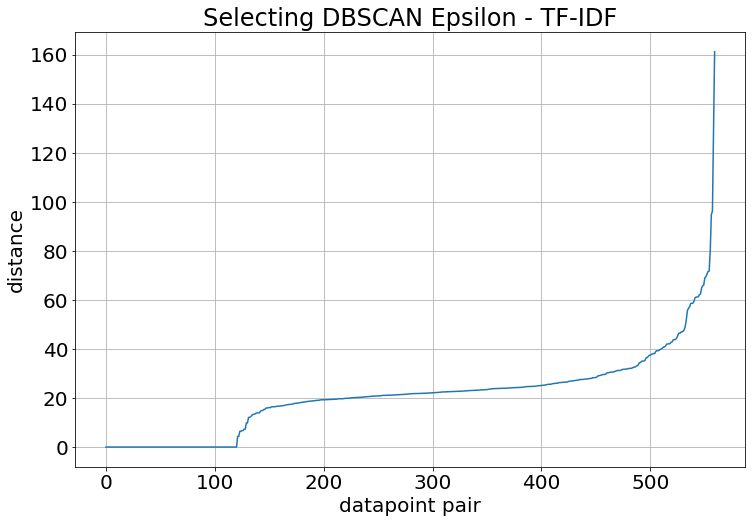

In [37]:
from sklearn.neighbors import NearestNeighbors

KNNalgo = NearestNeighbors(n_neighbors=2)
neighbs_BoW = KNNalgo.fit(BoW)
neighbs_TFIDF = KNNalgo.fit(TFIDF)
distances_bow, indices_bow = neighbs_BoW.kneighbors(BoW)
distances_tfidf, indices_tfidf = neighbs_TFIDF.kneighbors(TFIDF)

distances_bow = np.sort(distances_bow, axis=0)
distances_bow = distances_bow[:,1]
plt.plot(distances_bow)
plt.grid('both')
plt.xlabel("datapoint pair")
plt.ylabel("distance")
plt.title("Selecting DBSCAN Epsilon - BoW")
fig = plt.gcf()
fig.set_size_inches(12, 8, forward=True)
plt.savefig("Selecting_DBSCAN_Epsilon_bow",format='png',dpi=200,bbox_inches='tight')
plt.show()
#best epsilon value is 37 for BoW
epsilon_BoW = 37

distances_tfidf = np.sort(distances_tfidf, axis=0)
distances_tfidf = distances_tfidf[:,1]
plt.plot(distances_tfidf)
plt.grid('both')
plt.xlabel("datapoint pair")
plt.ylabel("distance")
plt.title("Selecting DBSCAN Epsilon - TF-IDF")
fig = plt.gcf()
fig.set_size_inches(12, 8, forward=True)
plt.savefig("Selecting_DBSCAN_Epsilon_tfidf",format='png',dpi=200,bbox_inches='tight')
plt.show()
#best epsilon value is 45 for TFIDF
epsilon_TFIDF = 50

#### 4. Running clustering algorithms 

In [38]:
#Running K-Means algorithm
from sklearn.cluster import KMeans

##NOTE THAT SAMPLE_WEIGHTS PASSED INTO FIT FUNCTION WEIGHS DATAPOINTS BY THEIR INVERSE FREQUENCY (CALCULATED ABOVE)

#BoW
#Based on author
author_clust_KM_bow = KMeans(n_clusters = no_authors).fit(BoW,sample_weight = authors_inverse_freq_samp)
#Based on era 
era_clust_KM_bow = KMeans(n_clusters = no_eras).fit(BoW, sample_weight = eras_inverse_freq_samp)
#Based on subject 
subject_clust_KM_bow = KMeans(n_clusters = no_subjects).fit(BoW, sample_weight = subject_inverse_freq_samp)

#TF-IDF
#Based on author
author_clust_KM_tfidf = KMeans(n_clusters = no_authors).fit(TFIDF,sample_weight = authors_inverse_freq_samp)
#Based on era 
era_clust_KM_tfidf = KMeans(n_clusters = no_eras).fit(TFIDF, sample_weight = eras_inverse_freq_samp)
#Based on subject 
subject_clust_KM_tfidf = KMeans(n_clusters = no_subjects).fit(TFIDF, sample_weight = subject_inverse_freq_samp)


#Running Spectral Clustering algorithm 
from sklearn.cluster import SpectralClustering 

#BoW
#Based on author
author_clust_SC_bow = SpectralClustering(n_clusters = no_authors, assign_labels='discretize').fit(BoW)
#Based on era 
era_clust_SC_bow = SpectralClustering(n_clusters = no_eras, assign_labels='discretize').fit(BoW)
#Based on subject 
subject_clust_SC_bow = SpectralClustering(n_clusters = no_subjects, assign_labels='discretize').fit(BoW)

#TF-IDF
#Based on author
author_clust_SC_tfidf = SpectralClustering(n_clusters = no_authors, assign_labels='discretize').fit(TFIDF)
#Based on era 
era_clust_SC_tfidf = SpectralClustering(n_clusters = no_eras, assign_labels='discretize').fit(TFIDF)
#Based on subject 
subject_clust_SC_tfidf = SpectralClustering(n_clusters = no_subjects, assign_labels='discretize').fit(TFIDF)



#Running DBSCAN algorithm 
from sklearn.cluster import DBSCAN

##NOTE THAT UNLIKE KMEANS AND SPECTRAL CLUSTERING, DBSCAN DOES NOT TAKE NO CLUSTERS AS AN ARGUMENT (THIS IS INFERRED)
#eps = maximum distance between two points for them to be considered in the same neighborhood 

#BoW
#Based on author
author_clust_DBS_bow = DBSCAN(eps=epsilon_BoW).fit(BoW, sample_weight = authors_inverse_freq_samp)
#Based on era 
era_clust_DBS_bow = DBSCAN(eps=epsilon_BoW).fit(BoW, sample_weight = eras_inverse_freq_samp)
#Based on subject 
subject_clust_DBS_bow = DBSCAN(eps=epsilon_BoW).fit(BoW, sample_weight = subject_inverse_freq_samp)

#TF-IDF
#Based on author
author_clust_DBS_tfidf = DBSCAN(eps=epsilon_TFIDF).fit(TFIDF,sample_weight = authors_inverse_freq_samp)
#Based on era 
era_clust_DBS_tfidf = DBSCAN(eps=epsilon_TFIDF).fit(TFIDF, sample_weight = eras_inverse_freq_samp)
#Based on subject 
subject_clust_DBS_tfidf = DBSCAN(eps=epsilon_TFIDF).fit(TFIDF, sample_weight = subject_inverse_freq_samp)



C:\Users\Cassandra .DESKTOP-UDR64AF\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Cassandra .DESKTOP-UDR64AF\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Cassandra .DESKTOP-UDR64AF\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Cassandra .DESKTOP-UDR64AF\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.

#### 5. Evaluating performance of algorithms 

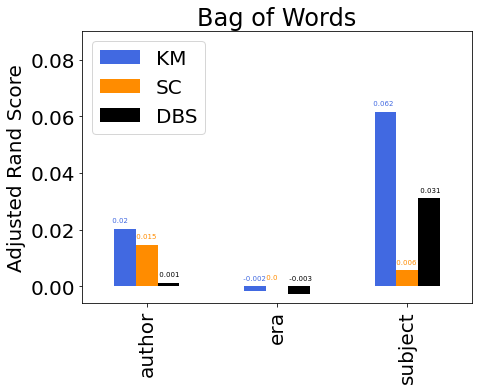

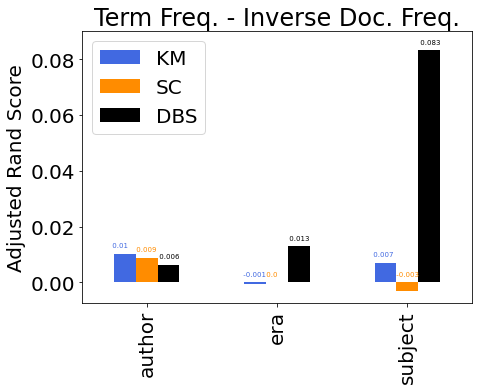

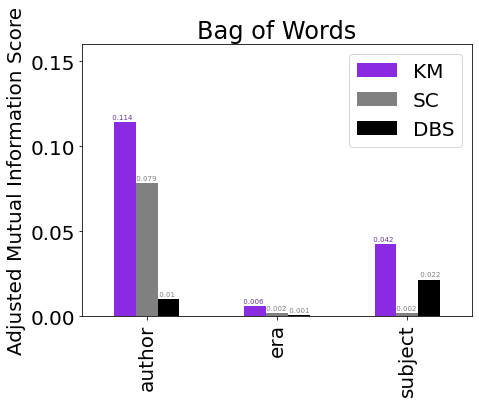

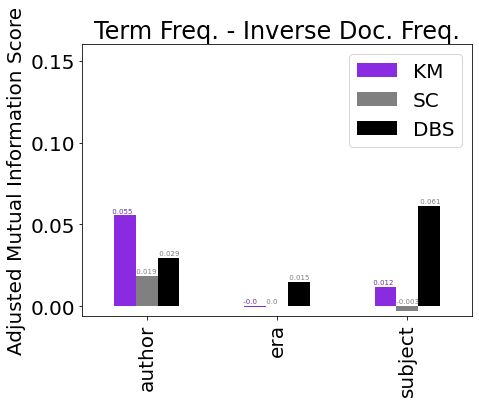

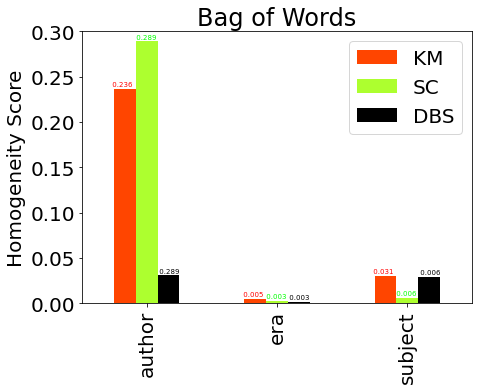

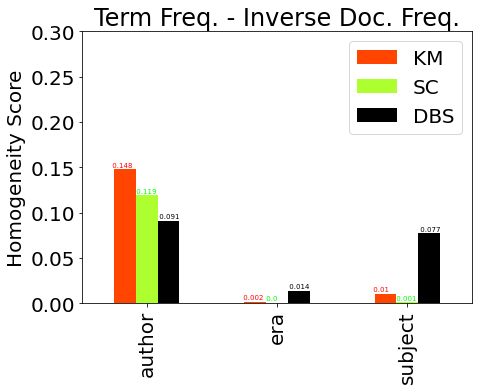

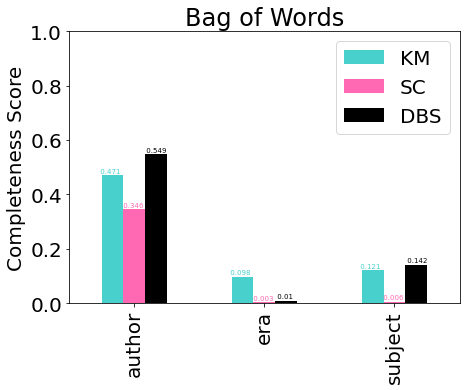

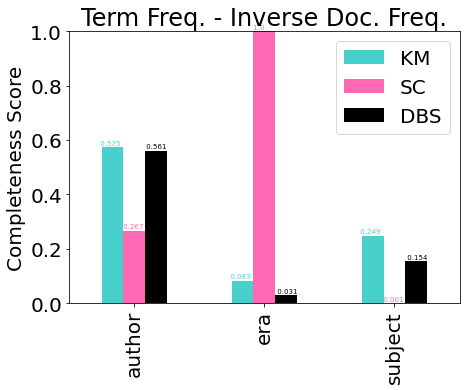

In [47]:
##Evaluate performance of clustering algorithms by comparing to ground truth (using Rand Index)
from sklearn.metrics import adjusted_rand_score 
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score 

#####################ADJUSTED RAND SCORE
#KMeans
#BoW
adj_rand_KM_authors_BoW = adjusted_rand_score(authors,author_clust_KM_bow.labels_)
adj_rand_KM_eras_BoW = adjusted_rand_score(eras,era_clust_KM_bow.labels_)
adj_rand_KM_subs_BoW = adjusted_rand_score(subjects,subject_clust_KM_bow.labels_)
#TF-IDF
adj_rand_KM_authors_TFIDF = adjusted_rand_score(authors,author_clust_KM_tfidf.labels_)
adj_rand_KM_eras_TFIDF = adjusted_rand_score(eras,era_clust_KM_tfidf.labels_)
adj_rand_KM_subs_TFIDF = adjusted_rand_score(subjects,subject_clust_KM_tfidf.labels_)

#Spectral Clustering
#BoW
adj_rand_SC_authors_BoW = adjusted_rand_score(authors,author_clust_SC_bow.labels_)
adj_rand_SC_eras_BoW = adjusted_rand_score(eras,era_clust_SC_bow.labels_)
adj_rand_SC_subs_BoW = adjusted_rand_score(subjects,subject_clust_SC_bow.labels_)
#TF-IDF
adj_rand_SC_authors_TFIDF = adjusted_rand_score(authors,author_clust_SC_tfidf.labels_)
adj_rand_SC_eras_TFIDF = adjusted_rand_score(eras,era_clust_SC_tfidf.labels_)
adj_rand_SC_subs_TFIDF = adjusted_rand_score(subjects,subject_clust_SC_tfidf.labels_)

#DBSCAN
#BoW
adj_rand_DBS_authors_BoW = adjusted_rand_score(authors,author_clust_DBS_bow.labels_)
adj_rand_DBS_eras_BoW = adjusted_rand_score(eras,era_clust_DBS_bow.labels_)
adj_rand_DBS_subs_BoW = adjusted_rand_score(subjects,subject_clust_DBS_bow.labels_)
#TF-IDF
adj_rand_DBS_authors_TFIDF = adjusted_rand_score(authors,author_clust_DBS_tfidf.labels_)
adj_rand_DBS_eras_TFIDF = adjusted_rand_score(eras,era_clust_DBS_tfidf.labels_)
adj_rand_DBS_subs_TFIDF = adjusted_rand_score(subjects,subject_clust_DBS_tfidf.labels_)




#####################ADJUSTED MUTUAL INFORMATION SCORE
#KMeans
#BoW
adj_MI_KM_authors_BoW = adjusted_mutual_info_score(authors,author_clust_KM_bow.labels_)
adj_MI_KM_eras_BoW = adjusted_mutual_info_score(eras,era_clust_KM_bow.labels_)
adj_MI_KM_subs_BoW = adjusted_mutual_info_score(subjects,subject_clust_KM_bow.labels_)
#TF-IDF
adj_MI_KM_authors_TFIDF = adjusted_mutual_info_score(authors,author_clust_KM_tfidf.labels_)
adj_MI_KM_eras_TFIDF = adjusted_mutual_info_score(eras,era_clust_KM_tfidf.labels_)
adj_MI_KM_subs_TFIDF = adjusted_mutual_info_score(subjects,subject_clust_KM_tfidf.labels_)

#Spectral Clustering
#BoW
adj_MI_SC_authors_BoW = adjusted_mutual_info_score(authors,author_clust_SC_bow.labels_)
adj_MI_SC_eras_BoW = adjusted_mutual_info_score(eras,era_clust_SC_bow.labels_)
adj_MI_SC_subs_BoW = adjusted_mutual_info_score(subjects,subject_clust_SC_bow.labels_)
#TF-IDF
adj_MI_SC_authors_TFIDF = adjusted_mutual_info_score(authors,author_clust_SC_tfidf.labels_)
adj_MI_SC_eras_TFIDF = adjusted_mutual_info_score(eras,era_clust_SC_tfidf.labels_)
adj_MI_SC_subs_TFIDF = adjusted_mutual_info_score(subjects,subject_clust_SC_tfidf.labels_)

#DBSCAN
#BoW
adj_MI_DBS_authors_BoW = adjusted_mutual_info_score(authors,author_clust_DBS_bow.labels_)
adj_MI_DBS_eras_BoW = adjusted_mutual_info_score(eras,era_clust_DBS_bow.labels_)
adj_MI_DBS_subs_BoW = adjusted_mutual_info_score(subjects,subject_clust_DBS_bow.labels_)
#TF-IDF
adj_MI_DBS_authors_TFIDF = adjusted_mutual_info_score(authors,author_clust_DBS_tfidf.labels_)
adj_MI_DBS_eras_TFIDF = adjusted_mutual_info_score(eras,era_clust_DBS_tfidf.labels_)
adj_MI_DBS_subs_TFIDF = adjusted_mutual_info_score(subjects,subject_clust_DBS_tfidf.labels_)




#####################HOMOGENEITY SCORE
#KMeans
#BoW
adj_hom_KM_authors_BoW = homogeneity_score(authors,author_clust_KM_bow.labels_)
adj_hom_KM_eras_BoW = homogeneity_score(eras,era_clust_KM_bow.labels_)
adj_hom_KM_subs_BoW = homogeneity_score(subjects,subject_clust_KM_bow.labels_)
#TF-IDF
adj_hom_KM_authors_TFIDF = homogeneity_score(authors,author_clust_KM_tfidf.labels_)
adj_hom_KM_eras_TFIDF = homogeneity_score(eras,era_clust_KM_tfidf.labels_)
adj_hom_KM_subs_TFIDF = homogeneity_score(subjects,subject_clust_KM_tfidf.labels_)

#Spectral Clustering
#BoW
adj_hom_SC_authors_BoW = homogeneity_score(authors,author_clust_SC_bow.labels_)
adj_hom_SC_eras_BoW = homogeneity_score(eras,era_clust_SC_bow.labels_)
adj_hom_SC_subs_BoW = homogeneity_score(subjects,subject_clust_SC_bow.labels_)
#TF-IDF
adj_hom_SC_authors_TFIDF = homogeneity_score(authors,author_clust_SC_tfidf.labels_)
adj_hom_SC_eras_TFIDF = homogeneity_score(eras,era_clust_SC_tfidf.labels_)
adj_hom_SC_subs_TFIDF = homogeneity_score(subjects,subject_clust_SC_tfidf.labels_)

#DBSCAN
#BoW
adj_hom_DBS_authors_BoW = homogeneity_score(authors,author_clust_DBS_bow.labels_)
adj_hom_DBS_eras_BoW = homogeneity_score(eras,era_clust_DBS_bow.labels_)
adj_hom_DBS_subs_BoW = homogeneity_score(subjects,subject_clust_DBS_bow.labels_)
#TF-IDF
adj_hom_DBS_authors_TFIDF = homogeneity_score(authors,author_clust_DBS_tfidf.labels_)
adj_hom_DBS_eras_TFIDF = homogeneity_score(eras,era_clust_DBS_tfidf.labels_)
adj_hom_DBS_subs_TFIDF = homogeneity_score(subjects,subject_clust_DBS_tfidf.labels_)



#####################COMPLETENESS SCORE
#KMeans
#BoW
adj_comp_KM_authors_BoW = completeness_score(authors,author_clust_KM_bow.labels_)
adj_comp_KM_eras_BoW = completeness_score(eras,era_clust_KM_bow.labels_)
adj_comp_KM_subs_BoW = completeness_score(subjects,subject_clust_KM_bow.labels_)
#TF-IDF
adj_comp_KM_authors_TFIDF = completeness_score(authors,author_clust_KM_tfidf.labels_)
adj_comp_KM_eras_TFIDF = completeness_score(eras,era_clust_KM_tfidf.labels_)
adj_comp_KM_subs_TFIDF = completeness_score(subjects,subject_clust_KM_tfidf.labels_)

#Spectral Clustering
#BoW
adj_comp_SC_authors_BoW = completeness_score(authors,author_clust_SC_bow.labels_)
adj_comp_SC_eras_BoW = completeness_score(eras,era_clust_SC_bow.labels_)
adj_comp_SC_subs_BoW = completeness_score(subjects,subject_clust_SC_bow.labels_)
#TF-IDF
adj_comp_SC_authors_TFIDF = completeness_score(authors,author_clust_SC_tfidf.labels_)
adj_comp_SC_eras_TFIDF = completeness_score(eras,era_clust_SC_tfidf.labels_)
adj_comp_SC_subs_TFIDF = completeness_score(subjects,subject_clust_SC_tfidf.labels_)




#DBSCAN
#BoW
adj_comp_DBS_authors_BoW = completeness_score(authors,author_clust_DBS_bow.labels_)
adj_comp_DBS_eras_BoW = completeness_score(eras,era_clust_DBS_bow.labels_)
adj_comp_DBS_subs_BoW = completeness_score(subjects,subject_clust_DBS_bow.labels_)
#TF-IDF
adj_comp_DBS_authors_TFIDF = completeness_score(authors,author_clust_DBS_tfidf.labels_)
adj_comp_DBS_eras_TFIDF = completeness_score(eras,era_clust_DBS_tfidf.labels_)
adj_comp_DBS_subs_TFIDF = completeness_score(subjects,subject_clust_DBS_tfidf.labels_)


#################################################
#################################################
#PLOT RESULTS FOR COMPARISON#####################

#Adjusted Rand Score 
#BoW
BoW_d = {'type':['author','era','subject'],'KM':[adj_rand_KM_authors_BoW,adj_rand_KM_eras_BoW,adj_rand_KM_subs_BoW],'SC':[adj_rand_SC_authors_BoW,adj_rand_SC_eras_BoW,adj_rand_SC_subs_BoW],'DBS':[adj_rand_DBS_authors_BoW,adj_rand_DBS_eras_BoW,adj_rand_DBS_subs_BoW]}
BoW_df = pd.DataFrame(data=BoW_d)
BoW_df.plot(x='type',y=['KM','SC',"DBS"],kind='bar',color=['royalblue','darkorange','black'])
plt.xlabel("")
plt.ylabel("Adjusted Rand Score")
plt.title("Bag of Words")
plt.ylim(top=.09)
for i in range(3):
    text_top_KM = 0
    if BoW_d['KM'][i]>0:
        text_top_KM = BoW_d['KM'][i]
    text_top_SC = 0
    if BoW_d['SC'][i]>0:
        text_top_SC = BoW_d['SC'][i]
    text_top_DBS = 0
    if BoW_d['DBS'][i]>0:
        text_top_DBS = BoW_d['DBS'][i]
    plt.text(i-.28,text_top_KM+ .003, " "+str(round(BoW_d['KM'][i],ndigits=3)), color='royalblue', va='center', fontsize=7)
    plt.text(i-.1,text_top_SC+ .003, " "+str(round(BoW_d['SC'][i],ndigits=3)), color='darkorange', va='center', fontsize=7)
    plt.text(i+.08,text_top_DBS+ .003, " "+str(round(BoW_d['DBS'][i],ndigits=3)), color='black', va='center', fontsize=7)
fig = plt.gcf()
fig.set_size_inches(7, 5, forward=True)
plt.savefig("BoW_clustering_comparison_randscore_C.png",format='png',dpi=200,bbox_inches='tight')
plt.show()
    
#TF-IDF
TFIDF_d = {'type':['author','era','subject'],'KM':[adj_rand_KM_authors_TFIDF,adj_rand_KM_eras_TFIDF,adj_rand_KM_subs_TFIDF],'SC':[adj_rand_SC_authors_TFIDF,adj_rand_SC_eras_TFIDF,adj_rand_SC_subs_TFIDF],'DBS':[adj_rand_DBS_authors_TFIDF,adj_rand_DBS_eras_TFIDF,adj_rand_DBS_subs_TFIDF]}
TFIDF_df = pd.DataFrame(data=TFIDF_d)
TFIDF_df.plot(x='type',y=['KM','SC','DBS'],kind='bar',color=['royalblue','darkorange','black'])
plt.xlabel("")
plt.ylabel("Adjusted Rand Score")
plt.title("Term Freq. - Inverse Doc. Freq.")
plt.ylim(top=.09)
for i in range(3):
    text_top_KM = 0
    if TFIDF_d['KM'][i]>0:
        text_top_KM = TFIDF_d['KM'][i]
    text_top_SC = 0
    if TFIDF_d['SC'][i]>0:
        text_top_SC = TFIDF_d['SC'][i]
    text_top_DBS = 0
    if TFIDF_d['DBS'][i]>0:
        text_top_DBS = TFIDF_d['DBS'][i]
    plt.text(i-.28,text_top_KM+.003 , " "+str(round(TFIDF_d['KM'][i],ndigits=3)), color='royalblue', va='center', fontsize=7)
    plt.text(i-.1,text_top_SC+.003 , " "+str(round(TFIDF_d['SC'][i],ndigits=3)), color='darkorange', va='center', fontsize=7)
    plt.text(i+.08,text_top_DBS+.003 , " "+str(round(TFIDF_d['DBS'][i],ndigits=3)), color='black', va='center', fontsize=7)
fig = plt.gcf()
fig.set_size_inches(7, 5, forward=True)
plt.savefig("TF-IDF_clustering_comparison_randscore_C.png",format='png',dpi=200,bbox_inches='tight')
plt.show(),


#Adjusted Mutual Information Score
#BoW
BoW_d_mi = {'type':['author','era','subject'],'KM':[adj_MI_KM_authors_BoW,adj_MI_KM_eras_BoW,adj_MI_KM_subs_BoW],'SC':[adj_MI_SC_authors_BoW,adj_MI_SC_eras_BoW,adj_MI_SC_subs_BoW],'DBS':[adj_MI_DBS_authors_BoW,adj_MI_DBS_eras_BoW,adj_MI_DBS_subs_BoW]}
BoW_df_mi = pd.DataFrame(data=BoW_d_mi)
BoW_df_mi.plot(x='type',y=['KM','SC','DBS'],kind='bar',color=['blueviolet','gray','black'])
plt.xlabel("")
plt.ylabel("Adjusted Mutual Information Score")
plt.title("Bag of Words")
plt.ylim(top=.16)
for i in range(3):
    text_top_KM = 0
    if BoW_d_mi['KM'][i]>0:
        text_top_KM = BoW_d_mi['KM'][i]
    text_top_SC = 0
    if BoW_d_mi['SC'][i]>0:
        text_top_SC = BoW_d_mi['SC'][i]
    text_top_DBS = 0
    if BoW_d_mi['DBS'][i]>0:
        text_top_DBS = BoW_d_mi['DBS'][i]
    plt.text(i-.28,text_top_KM+.003, " "+str(round(BoW_d_mi['KM'][i],ndigits=3)), color='rebeccapurple', va='center', fontsize=7)
    plt.text(i-.1,text_top_SC+.003, " "+str(round(BoW_d_mi['SC'][i],ndigits=3)), color='gray', va='center', fontsize=7)
    plt.text(i+.08,text_top_DBS+.003, " "+str(round(BoW_d_mi['DBS'][i],ndigits=3)), color='gray', va='center', fontsize=7)
fig = plt.gcf()
fig.set_size_inches(7, 5, forward=True)
plt.savefig("BoW_clustering_comparison_miscore_C.png",format='png',dpi=200,bbox_inches='tight')
plt.show()
    
#TF-IDF
TFIDF_d_mi = {'type':['author','era','subject'],'KM':[adj_MI_KM_authors_TFIDF,adj_MI_KM_eras_TFIDF,adj_MI_KM_subs_TFIDF],'SC':[adj_MI_SC_authors_TFIDF,adj_MI_SC_eras_TFIDF,adj_MI_SC_subs_TFIDF],'DBS':[adj_MI_DBS_authors_TFIDF,adj_MI_DBS_eras_TFIDF,adj_MI_DBS_subs_TFIDF]}
TFIDF_df_mi = pd.DataFrame(data=TFIDF_d_mi)
TFIDF_df_mi.plot(x='type',y=['KM','SC','DBS'],kind='bar',color=['blueviolet','gray','black'])
plt.xlabel("")
plt.ylabel("Adjusted Mutual Information Score")
plt.title("Term Freq. - Inverse Doc. Freq.")
plt.ylim(top=.16)
for i in range(3):
    text_top_KM = 0
    if TFIDF_d_mi['KM'][i]>0:
        text_top_KM = TFIDF_d_mi['KM'][i]
    text_top_SC = 0
    if TFIDF_d_mi['SC'][i]>0:
        text_top_SC = TFIDF_d_mi['SC'][i]
    text_top_DBS = 0
    if TFIDF_d_mi['DBS'][i]>0:
        text_top_DBS = TFIDF_d_mi['DBS'][i]
    plt.text(i-.28,text_top_KM+.003, " "+str(round(TFIDF_d_mi['KM'][i],ndigits=3)), color='rebeccapurple', va='center', fontsize=7)
    plt.text(i-.1,text_top_SC+.003, " "+str(round(TFIDF_d_mi['SC'][i],ndigits=3)), color='gray', va='center', fontsize=7)
    plt.text(i+.08,text_top_DBS+.003, " "+str(round(TFIDF_d_mi['DBS'][i],ndigits=3)), color='gray', va='center', fontsize=7)
fig = plt.gcf()
fig.set_size_inches(7, 5, forward=True)
plt.savefig("TF-IDF_clustering_comparison_miscore_C.png",format='png',dpi=200,bbox_inches='tight')
plt.show()


#Homogeneity score 
#BoW
BoW_d_hom = {'type':['author','era','subject'],'KM':[adj_hom_KM_authors_BoW,adj_hom_KM_eras_BoW,adj_hom_KM_subs_BoW],'SC':[adj_hom_SC_authors_BoW,adj_hom_SC_eras_BoW,adj_hom_SC_subs_BoW],'DBS':[adj_hom_DBS_authors_BoW,adj_hom_DBS_eras_BoW,adj_hom_DBS_subs_BoW]}
BoW_df_hom = pd.DataFrame(data=BoW_d_hom)
BoW_df_hom.plot(x='type',y=['KM','SC','DBS'],kind='bar',color=['orangered','greenyellow','black'])
plt.xlabel("")
plt.ylabel("Homogeneity Score")
plt.title("Bag of Words")
plt.ylim(top=.30)
for i in range(3):
    plt.text(i-.28,BoW_d_hom['KM'][i]+.005, " "+str(round(BoW_d_hom['KM'][i],ndigits=3)), color='red', va='center', fontsize=7)
    plt.text(i-.1,BoW_d_hom['SC'][i]+.005, " "+str(round(BoW_d_hom['SC'][i],ndigits=3)), color='lime', va='center', fontsize=7)
    plt.text(i+.08,BoW_d_hom['DBS'][i]+.005, " "+str(round(BoW_d_hom['SC'][i],ndigits=3)), color='black', va='center', fontsize=7)
fig = plt.gcf()
fig.set_size_inches(7, 5, forward=True)
plt.savefig("BoW_clustering_comparison_homscore_C.png",format='png',dpi=200,bbox_inches='tight')
plt.show()
    
#TF-IDF
TFIDF_d_hom = {'type':['author','era','subject'],'KM':[adj_hom_KM_authors_TFIDF,adj_hom_KM_eras_TFIDF,adj_hom_KM_subs_TFIDF],'SC':[adj_hom_SC_authors_TFIDF,adj_hom_SC_eras_TFIDF,adj_hom_SC_subs_TFIDF],'DBS':[adj_hom_DBS_authors_TFIDF,adj_hom_DBS_eras_TFIDF,adj_hom_DBS_subs_TFIDF]}
TFIDF_df_hom = pd.DataFrame(data=TFIDF_d_hom)
TFIDF_df_hom.plot(x='type',y=['KM','SC','DBS'],kind='bar',color=['orangered','greenyellow','black'])
plt.xlabel("")
plt.ylabel("Homogeneity Score")
plt.title("Term Freq. - Inverse Doc. Freq.")
plt.ylim(top=.30)
for i in range(3):
    plt.text(i-.28,TFIDF_d_hom['KM'][i]+.005, " "+str(round(TFIDF_d_hom['KM'][i],ndigits=3)), color='red', va='center', fontsize=7)
    plt.text(i-.1,TFIDF_d_hom['SC'][i]+.005, " "+str(round(TFIDF_d_hom['SC'][i],ndigits=3)), color='lime', va='center', fontsize=7)
    plt.text(i+.08,TFIDF_d_hom['DBS'][i]+.005, " "+str(round(TFIDF_d_hom['DBS'][i],ndigits=3)), color='black', va='center', fontsize=7)
fig = plt.gcf()
fig.set_size_inches(7, 5, forward=True)
plt.savefig("TF-IDF_clustering_comparison_homscore_C.png",format='png',dpi=200,bbox_inches='tight')
plt.show()



#Completeness score 
#BoW
BoW_d_comp = {'type':['author','era','subject'],'KM':[adj_comp_KM_authors_BoW,adj_comp_KM_eras_BoW,adj_comp_KM_subs_BoW],'SC':[adj_comp_SC_authors_BoW,adj_comp_SC_eras_BoW,adj_comp_SC_subs_BoW],'DBS':[adj_comp_DBS_authors_BoW,adj_comp_DBS_eras_BoW,adj_comp_DBS_subs_BoW]}
BoW_df_comp = pd.DataFrame(data=BoW_d_comp)
BoW_df_comp.plot(x='type',y=['KM','SC','DBS'],kind='bar',color=['mediumturquoise','hotpink','black'])
plt.xlabel("")
plt.ylabel("Completeness Score")
plt.title("Bag of Words")
plt.ylim(top=1)
for i in range(3):
    plt.text(i-.28,BoW_d_comp['KM'][i]+.015, " "+str(round(BoW_d_comp['KM'][i],ndigits=3)), color='mediumturquoise', va='center', fontsize=7)
    plt.text(i-.1,BoW_d_comp['SC'][i]+.015, " "+str(round(BoW_d_comp['SC'][i],ndigits=3)), color='hotpink', va='center', fontsize=7)
    plt.text(i+.08,BoW_d_comp['DBS'][i]+.015, " "+str(round(BoW_d_comp['DBS'][i],ndigits=3)), color='black', va='center', fontsize=7)
fig = plt.gcf()
fig.set_size_inches(7, 5, forward=True)
plt.savefig("BoW_clustering_comparison_compscore_C.png",format='png',dpi=200,bbox_inches='tight')
plt.show()
    
#TF-IDF
TFIDF_d_comp = {'type':['author','era','subject'],'KM':[adj_comp_KM_authors_TFIDF,adj_comp_KM_eras_TFIDF,adj_comp_KM_subs_TFIDF],'SC':[adj_comp_SC_authors_TFIDF,adj_comp_SC_eras_TFIDF,adj_comp_SC_subs_TFIDF],'DBS':[adj_comp_DBS_authors_TFIDF,adj_comp_DBS_eras_TFIDF,adj_comp_DBS_subs_TFIDF]}
TFIDF_df_comp = pd.DataFrame(data=TFIDF_d_comp)
TFIDF_df_comp.plot(x='type',y=['KM','SC','DBS'],kind='bar',color=['mediumturquoise','hotpink','black'])
plt.xlabel("")
plt.ylabel("Completeness Score")
plt.title("Term Freq. - Inverse Doc. Freq.")
plt.ylim(top=1)
for i in range(3):
    plt.text(i-.28,TFIDF_d_comp['KM'][i]+.015, " "+str(round(TFIDF_d_comp['KM'][i],ndigits=3)), color='mediumturquoise', va='center', fontsize=7)
    plt.text(i-.1,TFIDF_d_comp['SC'][i]+.015, " "+str(round(TFIDF_d_comp['SC'][i],ndigits=3)), color='hotpink', va='center', fontsize=7)
    plt.text(i+.08,TFIDF_d_comp['DBS'][i]+.015, " "+str(round(TFIDF_d_comp['DBS'][i],ndigits=3)), color='black', va='center', fontsize=7)
fig = plt.gcf()
fig.set_size_inches(7, 5, forward=True)
plt.savefig("TFIDF_clustering_comparison_compscore_C.png",format='png',dpi=200,bbox_inches='tight')
plt.show()

## PART 4: Visualize each poem as in a network

#### 1. Compute Jaccard Similarity to create similarity matrix for all entries 

In [41]:
##function to calculate Jaccard Similarity. Note that it only measures if a word is present in the poem, not how many times it is present.
def jaccard(vec1,vec2):
    words_union = 0
    words_intersection = 0
    for w in range(len(vec1)):
        if vec1[w]!=0:
            words_union = words_union + 1
            if vec2[w]!=0:
                words_intersection = words_intersection + 1  
        elif vec2[w]!=0:
            words_union = words_union + 1
    
    jaccard = words_intersection / words_union
    return jaccard       

#### 2. Construct and plot similarity matrix 

In [42]:
##function to construct similarity matrix using jaccard similarity 
##Note that all_poem_entries represent the poems being compared, already vectorized 
def similarity_matrix(all_poem_vectors):
    #initialize matrix
    sim_matrix = np.zeros([len(all_poem_vectors), len(all_poem_vectors)])
    for p1 in range(sim_matrix.shape[0]):
        for p2 in range(sim_matrix.shape[0]):
            sim_matrix[p1,p2] = jaccard(all_poem_vectors[p1],all_poem_vectors[p2])
    return sim_matrix

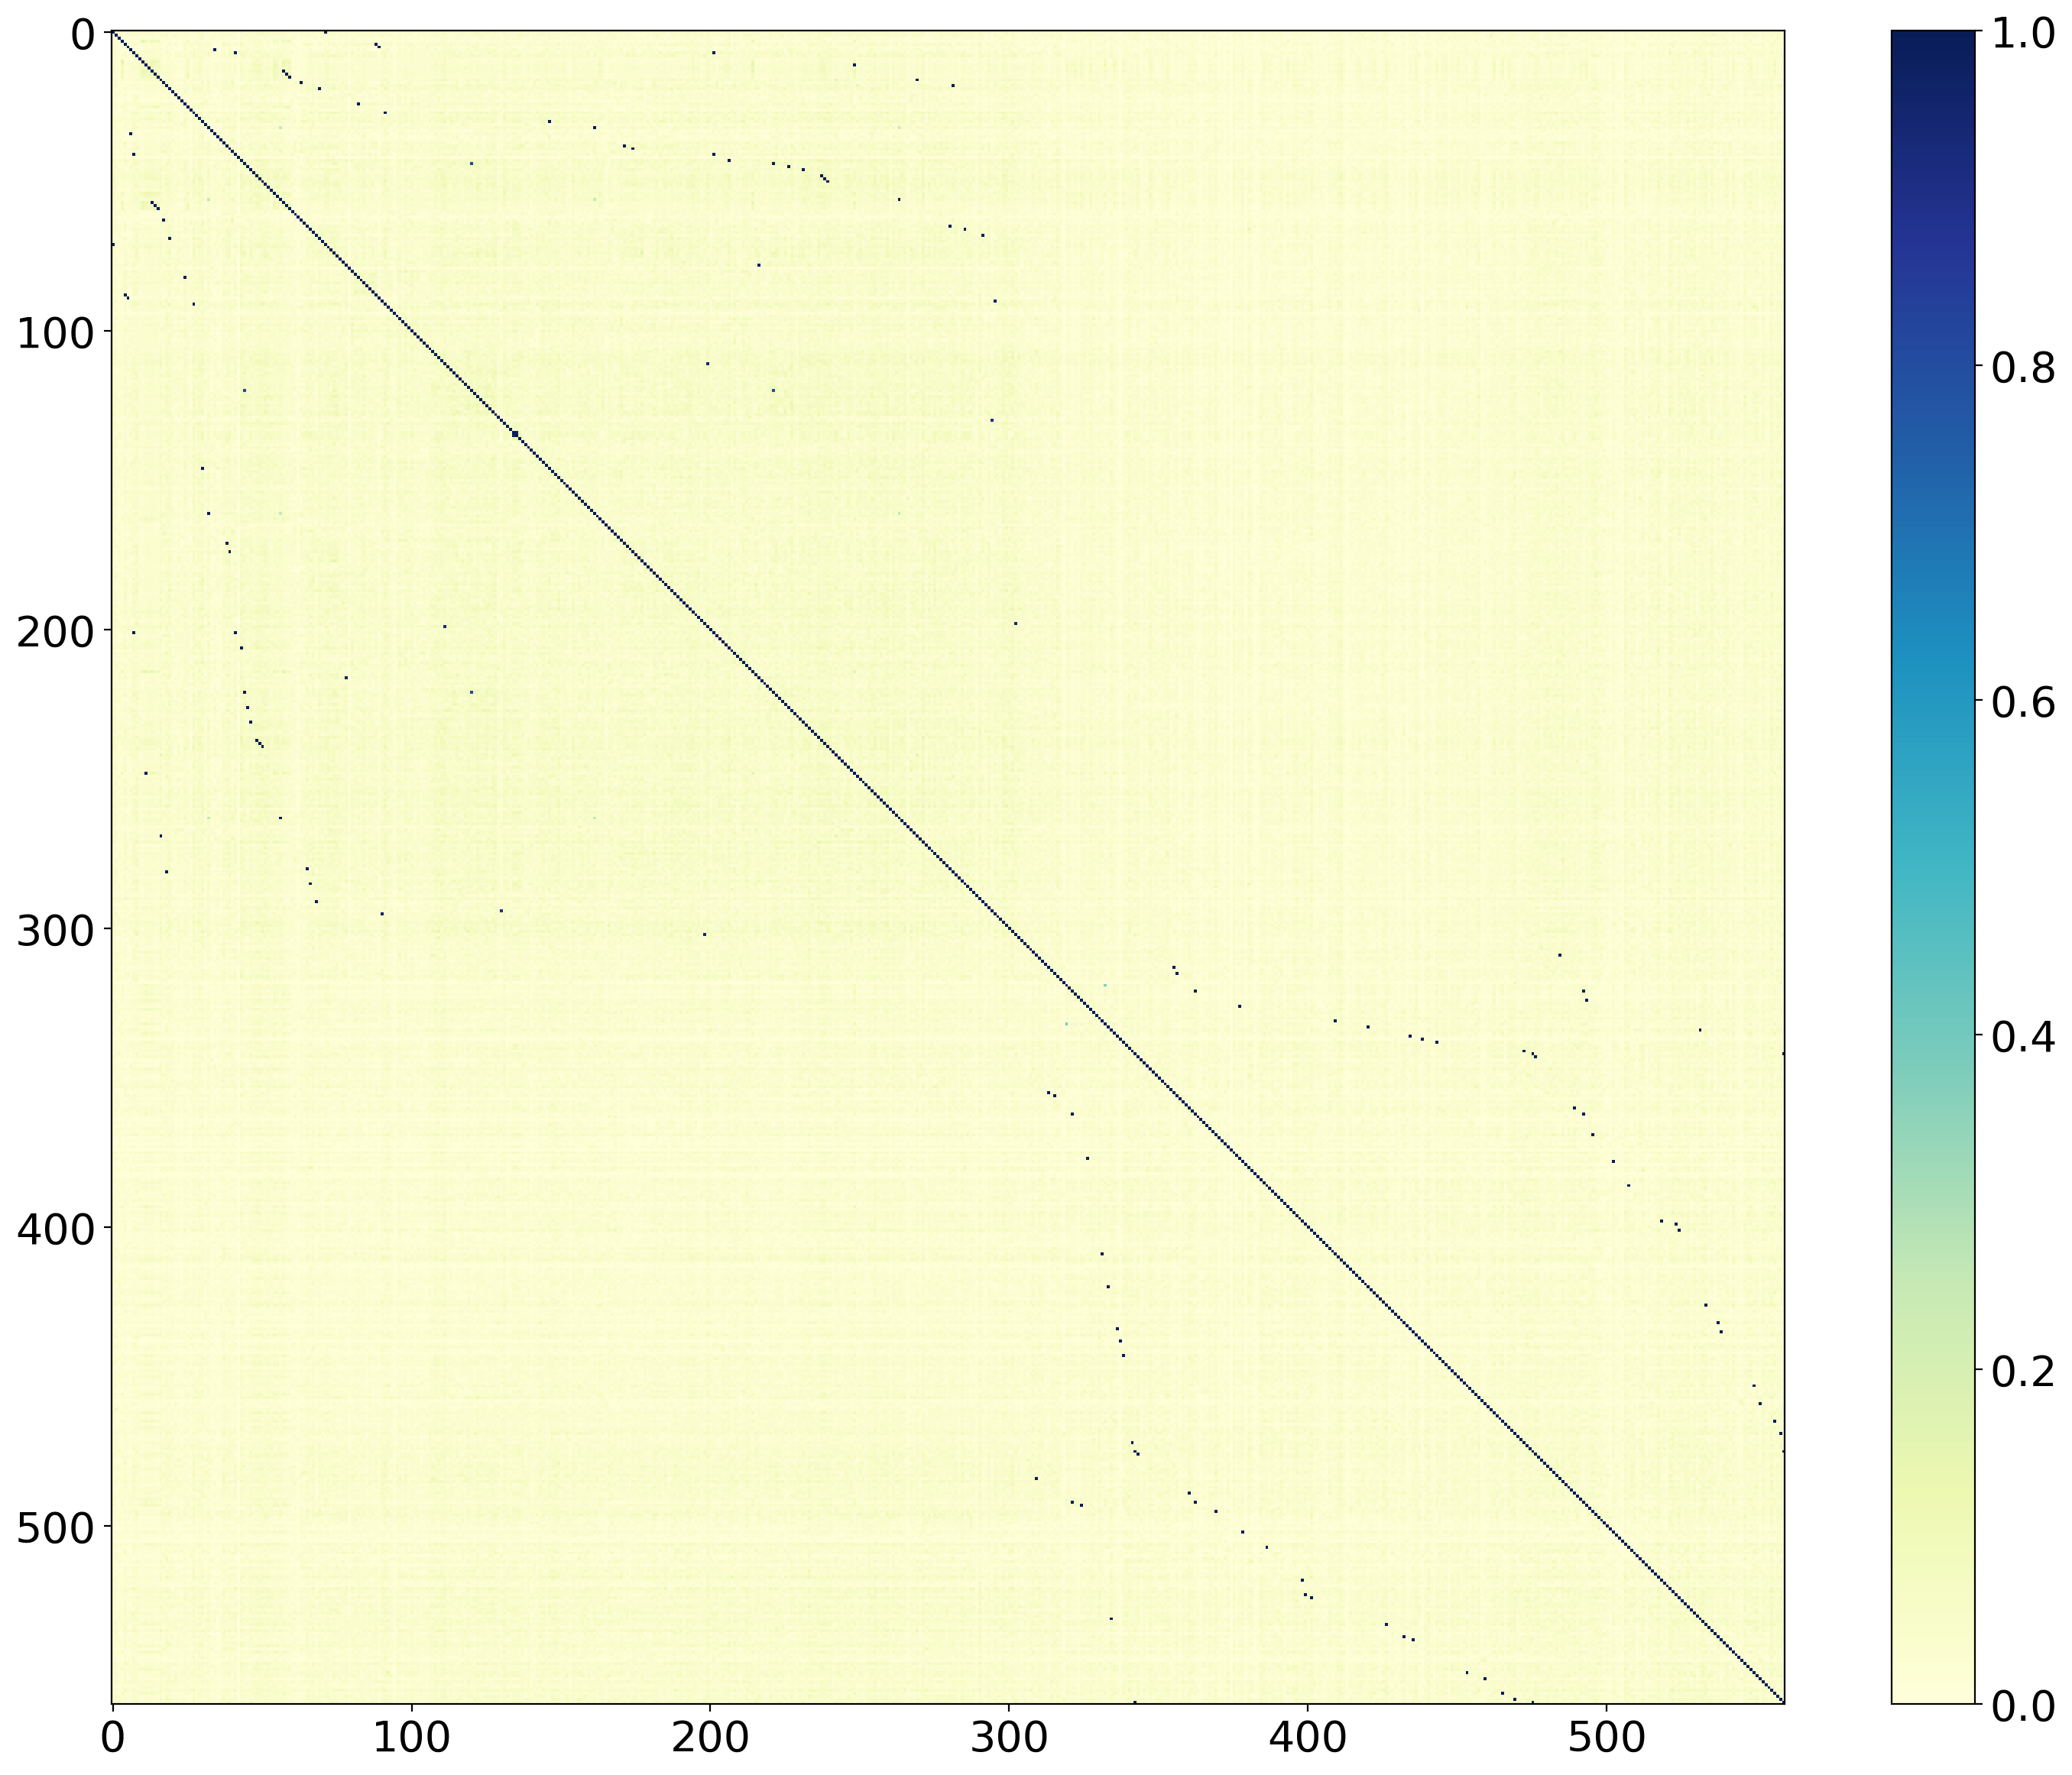

In [43]:
sim_matrix = similarity_matrix(BoW)

#Plot Similarity matrix 
plt.imshow(sim_matrix, interpolation='nearest', cmap="YlGnBu")
plt.colorbar()
fig = plt.gcf()
fig.set_size_inches(18, 14.5, forward=True)
fig.set_dpi(200)
plt.savefig("similarity_matrix_all_poems", bbox_inches = "tight")
plt.show()


#### 3. Sort similarity matrix so that aubject/era/author are consolidated (3 separate sim matrices constructed)

In [44]:
##Reorder similarity matrix so that entries are ordered by AUTHOR
authors_sorted = sorted(authors)
authors_sorted_ind = sorted(range(len(authors)), key=lambda k: authors[k])
sim_matrix_authsort = sim_matrix[np.ix_(authors_sorted_ind,authors_sorted_ind)]
##iterating through authors_sorted list to get count of each author in order
auth_count_ordered = np.zeros(no_authors,dtype=int)
counter = 0
for n in range(1,len(authors_sorted)):
    if authors_sorted[n] == authors_sorted[n-1]:
        auth_count_ordered[counter] = auth_count_ordered[counter] + 1
    else:
        if(counter == 0):
            auth_count_ordered[0] = auth_count_ordered[0] + 1
        counter = counter+1
        auth_count_ordered[counter] = auth_count_ordered[counter] + 1
        

##Reorder similarity matrix so that entries are ordered by ERA 
era_sorted = sorted(eras)
eras_sorted_ind = sorted(range(len(eras)), key=lambda k: eras[k])
sim_matrix_erasort = sim_matrix[np.ix_(eras_sorted_ind,eras_sorted_ind)]
##iterating through authors_sorted list to get count of each author in order
era_count_ordered = np.zeros(2,dtype=int)
counter = 0
for n in range(1,len(era_sorted)):
    if era_sorted[n] == era_sorted[n-1]:
        era_count_ordered[counter] = era_count_ordered[counter] + 1
    else:
        if(counter == 0):
            era_count_ordered[0] = era_count_ordered[0] + 1
        counter = counter+1
        era_count_ordered[counter] = era_count_ordered[counter] + 1

        
        
##Reorder similarity matrix so that entries are ordered by SUBJECT 
sub_sorted = sorted(subjects)
sub_sorted_ind = sorted(range(len(subjects)), key=lambda k: subjects[k])
sim_matrix_subsort = sim_matrix[np.ix_(sub_sorted_ind,sub_sorted_ind)]
##iterating through authors_sorted list to get count of each author in order
sub_count_ordered = np.zeros(3,dtype=int)
counter = 0
for n in range(1,len(sub_sorted)):
    if sub_sorted[n] == sub_sorted[n-1]:
        sub_count_ordered[counter] = sub_count_ordered[counter] + 1
    else:
        if(counter == 0):
            sub_count_ordered[0] = sub_count_ordered[0] + 1
        counter = counter+1
        sub_count_ordered[counter] = sub_count_ordered[counter] + 1

#### 4. Plot graph network, coloring nodes based on each category 

In [ ]:
##displaying 'network' (as a graphic) describing distances between each poem (nodes are colored according to author, era, and subject)
##Inspired by the following post: https://towardsdatascience.com/classifying-literary-movements-through-machine-learning-ea49cb4339c1

import networkx as nx

##Threshold (jac_thresh) represents the smallest Jaccard distance permissable
jac_thresh = .07

####COLORING BASED ON AUTHOR 
##Convert numpy array to graph
NET = nx.from_numpy_array(sim_matrix_authsort>jac_thresh)

lay = nx.kamada_kawai_layout(NET)
plt.figure(figsize=(20, 20))
plt.axis('off')

#Color nodes of graphy based on author:
colors_auth = np.random.rand(no_authors,3)
color_map_auth = []
for n in range(len(auth_count_ordered)):
    for c in range(auth_count_ordered[n]):
        color_map_auth.append(colors_auth[n])

nx.draw_networkx_nodes(NET, lay, node_size=70, cmap=plt.cm.Dark2, node_color = color_map_auth)
nx.draw_networkx_edges(NET, lay, alpha=0.15, width=0.2)
plt.savefig("graph_network_diagram_AUTHORS",dpi=400, bbox_inches = "tight")
plt.show()



####COLORING BASED ON ERA
##Convert numpy array to graph
NET2 = nx.from_numpy_array(sim_matrix_erasort>jac_thresh)

lay2 = nx.kamada_kawai_layout(NET2)
plt.figure(figsize=(20, 20))
plt.axis('off')

#Color nodes of graphy based on author:
colors_era = np.random.rand(2,3)
color_map_era = []
for n in range(len(era_count_ordered)):
    for c in range(era_count_ordered[n]):
        color_map_era.append(colors_era[n])

nx.draw_networkx_nodes(NET2, lay2, node_size=70, cmap=plt.cm.Dark2, node_color = color_map_era)
nx.draw_networkx_edges(NET2, lay2, alpha=0.15, width=0.2)
plt.savefig("graph_network_diagram_ERAS", dpi=400, bbox_inches = "tight")
plt.show()



####COLORING BASED ON SUBJECT
##Convert numpy array to graph
NET3 = nx.from_numpy_array(sim_matrix_subsort>jac_thresh)

lay3 = nx.kamada_kawai_layout(NET3)
plt.figure(figsize=(20, 20))
plt.axis('off')

#Color nodes of graphy based on author:
colors_sub = np.random.rand(3,3)
color_map_sub = []
for n in range(len(sub_count_ordered)):
    for c in range(sub_count_ordered[n]):
        color_map_sub.append(colors_sub[n])

nx.draw_networkx_nodes(NET3, lay3, node_size=70, cmap=plt.cm.Dark2, node_color = color_map_sub)
nx.draw_networkx_edges(NET3, lay3, alpha=0.15, width=0.2)
plt.savefig("graph_network_diagram_SUBJECTS", dpi=400, bbox_inches = "tight")
plt.show()

